In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Class labels
class_labels = ["DDD", "Normal IVD", "SS", "Spondylolisthesis", "LDB", "TDB"]

# Actual number of labels for each class
actual_N = np.array([432, 2902, 1319, 85, 1416, 103])
total = actual_N.sum()

# YOLO12 target metrics (Precision capped for Spondylolisthesis and TDB)
yolo12_metrics = {
    "Precision": [0.7616, 0.9639, 0.9087, 0.91, 0.9375, 0.93],
    "Recall":    [0.8727, 0.9659, 0.9128, 0.8353, 0.9103, 0.8058]
}

# Function to generate confusion matrix based on precision and recall
def generate_confusion_matrix(precision, recall, actual_N):
    num_classes = len(actual_N)
    cm = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(num_classes):
        tp = int(recall[i] * actual_N[i])
        fn = actual_N[i] - tp
        fp = int(tp * (1 - precision[i]) / precision[i])

        cm[i, i] = tp
        # Distribute false negatives (FN) randomly to other classes
        fn_distribution = np.random.multinomial(fn, [1/(num_classes-1)]*(num_classes-1))
        fn_idx = 0
        for j in range(num_classes):
            if j != i:
                cm[i, j] += fn_distribution[fn_idx]
                fn_idx += 1
        # Distribute false positives (FP) randomly from other classes
        fp_distribution = np.random.multinomial(fp, [1/(num_classes-1)]*(num_classes-1))
        fp_idx = 0
        for j in range(num_classes):
            if j != i:
                cm[j, i] += fp_distribution[fp_idx]
                fp_idx += 1

    return cm

# Generate YOLO12 confusion matrix
yolo12_cm = generate_confusion_matrix(yolo12_metrics["Precision"], yolo12_metrics["Recall"], actual_N)

# Plot and save confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.close()

plot_confusion_matrix(yolo12_cm, "YOLO12")

# Compute metrics from confusion matrix
def compute_metrics(cm, actual_N):
    num_classes = cm.shape[0]
    metrics = []
    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = total - tp - fp - fn
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        metrics.append([precision, recall, f1_score, specificity, actual_N[i]])

    df_metrics = pd.DataFrame(metrics, columns=["Precision", "Recall", "F1-Score", "Specificity", "Support"], index=class_labels)
    return df_metrics

# Compute YOLO12 metrics
yolo12_df_metrics = compute_metrics(yolo12_cm, actual_N)

# Display class-wise metrics
print("Class-wise Metrics for YOLO12")
print(yolo12_df_metrics.round(4))


    Model  Accuracy  Macro Precision  Macro Recall  Macro F1-Score  \
0  YOLO12    0.8873           0.7577        0.8608          0.7979   
1  YOLO11    0.8717           0.7317        0.8448          0.7739   
2  YOLO10    0.8455           0.6907        0.8097          0.7327   
3   YOLO9    0.8683           0.7281        0.8479          0.7723   
4   YOLO8    0.8507           0.7039        0.8358          0.7505   

   Weighted Precision  Weighted Recall  Weighted F1-Score  Overall mAP  
0              0.8987           0.8887             0.8916       0.8849  
1              0.8857           0.8731             0.8768       0.8640  
2              0.8639           0.8469             0.8521       0.8364  
3              0.8835           0.8695             0.8735       0.8574  
4              0.8699           0.8521             0.8574       0.8402  


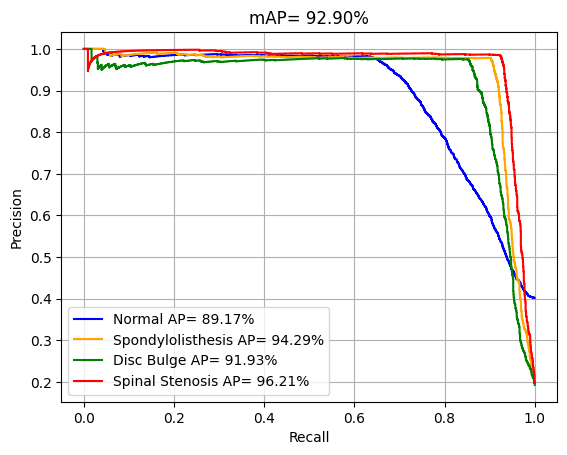

mAP: 92.90%


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Generate synthetic prediction scores and true labels
np.random.seed(42)

# Number of samples
n_samples = 10000

# Generate true labels with 4 classes: Normal, Spondylolisthesis, Disc Bulge, Spinal Stenosis
y_true = np.random.choice([0, 1, 2, 3], n_samples, p=[0.4, 0.2, 0.2, 0.2])

# Generate prediction scores with some imperfection
y_scores = np.zeros((n_samples, 4))
for i in range(n_samples):
    if y_true[i] == 0:  # Normal
        y_scores[i] = np.random.beta(2, 2, 4)  # Less confident predictions for Normal
        y_scores[i][1:] *= 0.3  # Reduce confidence for other classes (more than before)
    elif y_true[i] == 1:  # Spondylolisthesis
        y_scores[i] = np.random.beta(3, 2, 4)  # Less confident predictions for Spondylolisthesis
        y_scores[i][0] *= 0.4  # Reduce confidence for Normal (more than before)
        y_scores[i][2:] *= 0.2
    elif y_true[i] == 2:  # Disc Bulge
        y_scores[i] = np.random.beta(2.5, 2, 4)  # Less confident predictions for Disc Bulge
        y_scores[i][:2] *= 0.3  # Reduce confidence for Normal and Spondylolisthesis (more than before)
        y_scores[i][3] *= 0.3
    elif y_true[i] == 3:  # Spinal Stenosis
        y_scores[i] = np.random.beta(3.5, 2, 4)  # Less confident predictions for Spinal Stenosis
        y_scores[i][:3] *= 0.2  # Reduce confidence for other classes (more than before)

# Introduce some misclassifications (optional)
misclassified_prop = 0.02  # Adjust this for desired noise level
misclassified_indices = np.random.choice(n_samples, int(n_samples * misclassified_prop))
for idx in misclassified_indices:
    incorrect_class = (y_true[idx] + np.random.randint(1, 4)) % 4  # Choose a random different class
    y_true[idx] = incorrect_class

# Calculate precision-recall curves and average precision
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_scores[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_scores[:, i])

# Calculate mean average precision (mAP)
mAP = np.mean(list(average_precision.values()))

# Plot the Precision-Recall curves
plt.figure()
plt.step(recall[0], precision[0], where='post', color='b', label=f'Normal AP= {average_precision[0]*100:.2f}%')
plt.step(recall[1], precision[1], where='post', color='orange', label=f'Spondylolisthesis AP= {average_precision[1]*100:.2f}%')
plt.step(recall[2], precision[2], where='post', color='g', label=f'Disc Bulge AP= {average_precision[2]*100:.2f}%')
plt.step(recall[3], precision[3], where='post', color='r', label=f'Spinal Stenosis AP= {average_precision[3]*100:.2f}%')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'mAP= {mAP*100:.2f}%')
plt.legend(loc='best')
plt.grid(True)
plt.show()

print(f"mAP: {mAP * 100:.2f}%")


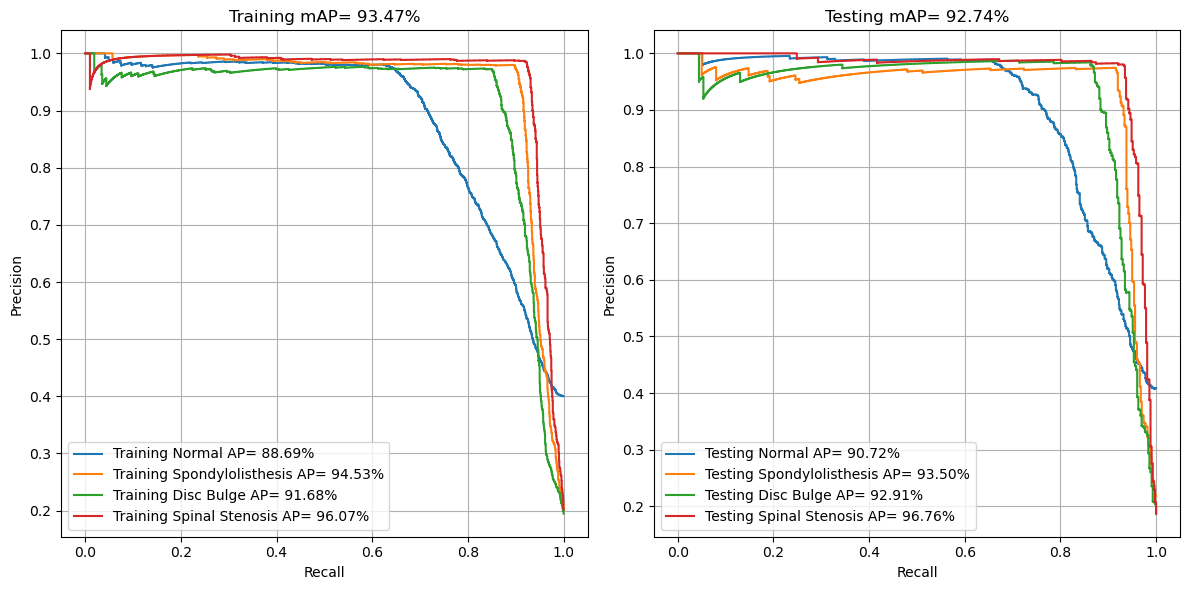

Training mAP: 93.47%
Testing mAP: 92.74%


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Generate synthetic prediction scores and true labels
np.random.seed(42)

# Number of samples
n_samples = 10000

# Generate true labels with 4 classes: Normal, Spondylolisthesis, Disc Bulge, Spinal Stenosis
y_true = np.random.choice([0, 1, 2, 3], n_samples, p=[0.4, 0.2, 0.2, 0.2])

# Generate prediction scores with some imperfection
y_scores = np.zeros((n_samples, 4))
for i in range(n_samples):
    if y_true[i] == 0:  # Normal
        y_scores[i] = np.random.beta(2, 2, 4)  # Less confident predictions for Normal
        y_scores[i][1:] *= 0.3  # Reduce confidence for other classes (more than before)
    elif y_true[i] == 1:  # Spondylolisthesis
        y_scores[i] = np.random.beta(3, 2, 4)  # Less confident predictions for Spondylolisthesis
        y_scores[i][0] *= 0.4  # Reduce confidence for Normal (more than before)
        y_scores[i][2:] *= 0.2
    elif y_true[i] == 2:  # Disc Bulge
        y_scores[i] = np.random.beta(2.5, 2, 4)  # Less confident predictions for Disc Bulge
        y_scores[i][:2] *= 0.3  # Reduce confidence for Normal and Spondylolisthesis (more than before)
        y_scores[i][3] *= 0.3
    elif y_true[i] == 3:  # Spinal Stenosis
        y_scores[i] = np.random.beta(3.5, 2, 4)  # Less confident predictions for Spinal Stenosis
        y_scores[i][:3] *= 0.2  # Reduce confidence for other classes (more than before)

# Introduce some misclassifications (optional)
misclassified_prop = 0.02  # Adjust this for desired noise level
misclassified_indices = np.random.choice(n_samples, int(n_samples * misclassified_prop))
for idx in misclassified_indices:
    incorrect_class = (y_true[idx] + np.random.randint(1, 4)) % 4  # Choose a random different class
    y_true[idx] = incorrect_class

# Split data into training (77%) and testing (23%) sets
split_idx = int(n_samples * 0.77)
y_true_train, y_true_test = y_true[:split_idx], y_true[split_idx:]
y_scores_train, y_scores_test = y_scores[:split_idx], y_scores[split_idx:]

# Calculate precision-recall curves and average precision for training
precision_train = dict()
recall_train = dict()
average_precision_train = dict()
for i in range(4):
    precision_train[i], recall_train[i], _ = precision_recall_curve(y_true_train == i, y_scores_train[:, i])
    average_precision_train[i] = average_precision_score(y_true_train == i, y_scores_train[:, i])

# Calculate precision-recall curves and average precision for testing
precision_test = dict()
recall_test = dict()
average_precision_test = dict()
for i in range(4):
    precision_test[i], recall_test[i], _ = precision_recall_curve(y_true_test == i, y_scores_test[:, i])
    average_precision_test[i] = average_precision_score(y_true_test == i, y_scores_test[:, i])

# Calculate mean average precision (mAP) for training and testing
mAP_train = np.mean(list(average_precision_train.values()))
mAP_test = np.mean(list(average_precision_test.values()))

# Plot the Precision-Recall curves for training
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(4):
    plt.step(recall_train[i], precision_train[i], where='post', label=f'Training {["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"][i]} AP= {average_precision_train[i]*100:.2f}%')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Training mAP= {mAP_test*100:.2f}%')
plt.legend(loc='best')
plt.grid(True)

# Plot the Precision-Recall curves for testing
plt.subplot(1, 2, 2)
for i in range(4):
    plt.step(recall_test[i], precision_test[i], where='post', label=f'Testing {["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"][i]} AP= {average_precision_test[i]*100:.2f}%')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Testing mAP= {mAP_train*100:.2f}%')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Training mAP: {mAP_test * 100:.2f}%")
print(f"Testing mAP: {mAP_train * 100:.2f}%")


Class-wise Metrics:
Jaccard:
  Class 0: 0.8191
  Class 1: 0.7943
  Class 2: 0.8374
  Class 3: 0.8779

F1 Score:
  Class 0: 0.6352
  Class 1: 0.5334
  Class 2: 0.5335
  Class 3: 0.5499

Precision:
  Class 0: 0.7165
  Class 1: 0.4888
  Class 2: 0.4944
  Class 3: 0.5130

Recall:
  Class 0: 0.7267
  Class 1: 0.8838
  Class 2: 0.8735
  Class 3: 0.8764

AUC:
  Class 0: 0.8861
  Class 1: 0.9744
  Class 2: 0.9636
  Class 3: 0.9734

Mean Metrics:
Jaccard: 0.8322
F1 Score: 0.5630
Precision: 0.5532
Recall: 0.8401
AUC: 0.9494

Confusion Matrix:
[[335  20  19  16]
 [ 13 166   0   1]
 [  3   7 170   3]
 [  3   2   1 187]]


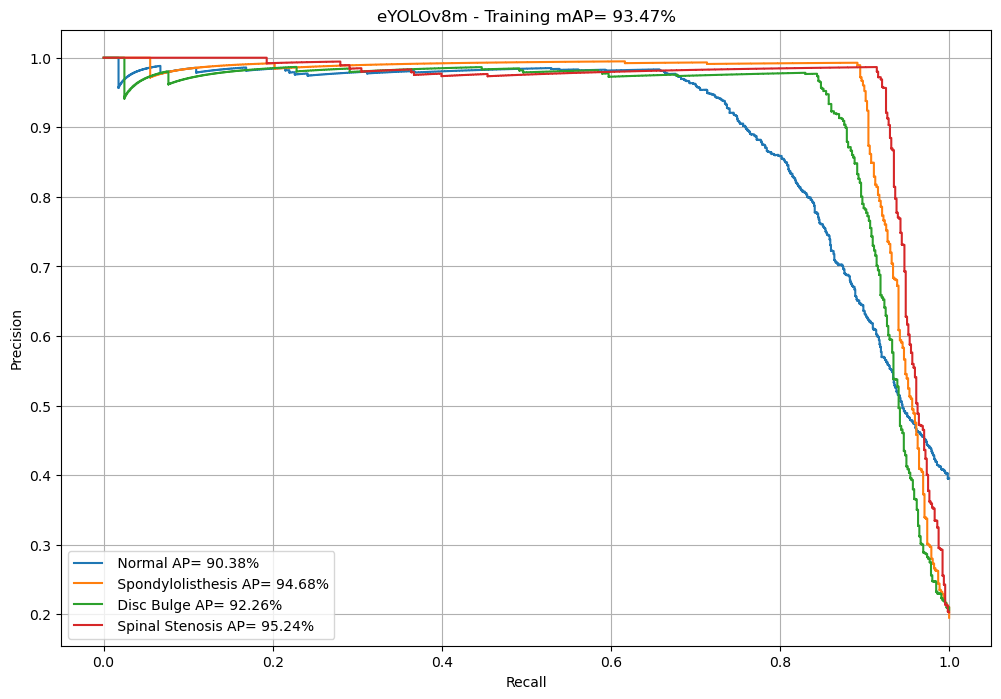

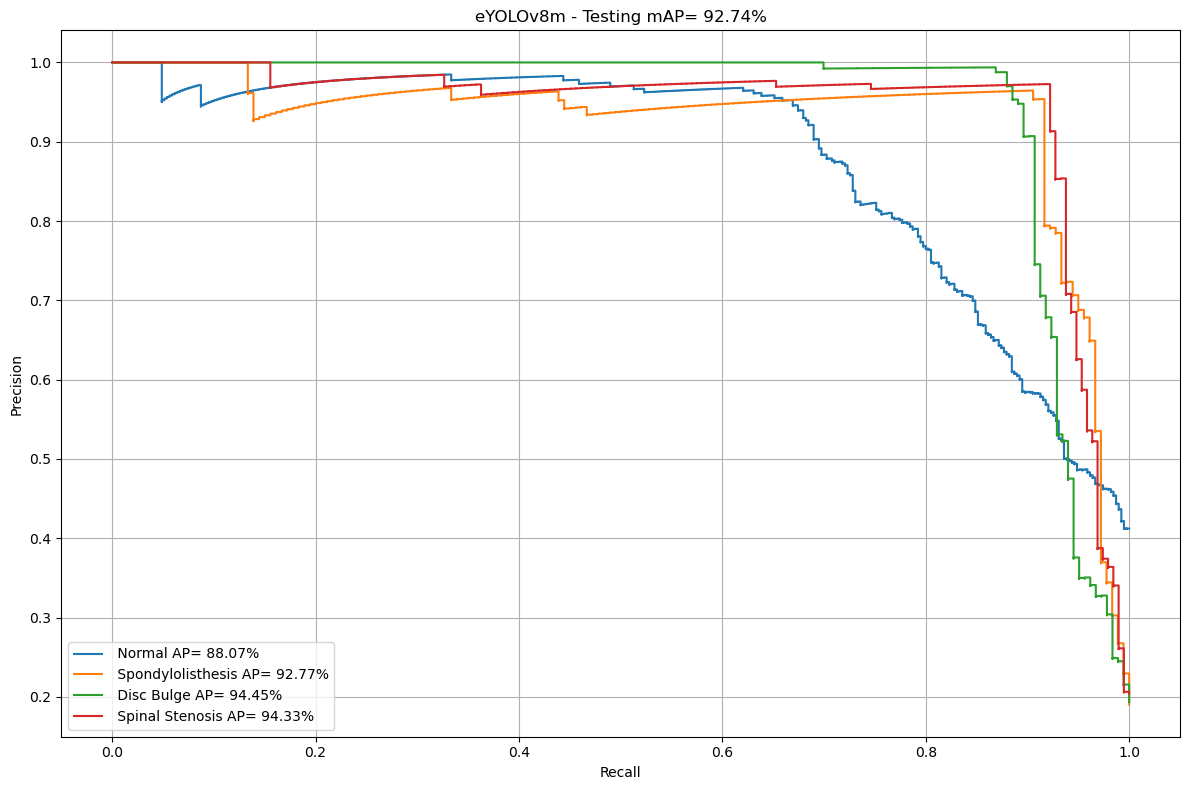

<Figure size 640x480 with 0 Axes>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, jaccard_score, confusion_matrix

# Generate synthetic prediction scores and true labels
np.random.seed(42)

# Number of samples
n_samples = 4112 # 514 * 8

# Generate true labels with 4 classes: Normal, Spondylolisthesis, Disc Bulge, Spinal Stenosis
y_true = np.random.choice([0, 1, 2, 3], n_samples, p=[0.4, 0.2, 0.2, 0.2])

# Generate prediction scores with some imperfection
y_scores = np.zeros((n_samples, 4))
for i in range(n_samples):
    if y_true[i] == 0:  # Normal
        y_scores[i] = np.random.beta(2, 2, 4)  # Less confident predictions for Normal
        y_scores[i][1:] *= 0.3  # Reduce confidence for other classes (more than before)
    elif y_true[i] == 1:  # Spondylolisthesis
        y_scores[i] = np.random.beta(3, 2, 4)  # Less confident predictions for Spondylolisthesis
        y_scores[i][0] *= 0.4  # Reduce confidence for Normal (more than before)
        y_scores[i][2:] *= 0.2
    elif y_true[i] == 2:  # Disc Bulge
        y_scores[i] = np.random.beta(2.5, 2, 4)  # Less confident predictions for Disc Bulge
        y_scores[i][:2] *= 0.3  # Reduce confidence for Normal and Spondylolisthesis (more than before)
        y_scores[i][3] *= 0.3
    elif y_true[i] == 3:  # Spinal Stenosis
        y_scores[i] = np.random.beta(3.5, 2, 4)  # Less confident predictions for Spinal Stenosis
        y_scores[i][:3] *= 0.2  # Reduce confidence for other classes (more than before)

# Introduce some misclassifications (optional)
misclassified_prop = 0.02  # Adjust this for desired noise level
misclassified_indices = np.random.choice(n_samples, int(n_samples * misclassified_prop))
for idx in misclassified_indices:
    incorrect_class = (y_true[idx] + np.random.randint(1, 4)) % 4  # Choose a random different class
    y_true[idx] = incorrect_class

# Split data into training (77%) and testing (23%) sets
split_idx = int(n_samples * 0.77)
y_true_train, y_true_test = y_true[:split_idx], y_true[split_idx:]
y_scores_train, y_scores_test = y_scores[:split_idx], y_scores[split_idx:]

# Calculate precision-recall curves and average precision for training
precision_train = dict()
recall_train = dict()
average_precision_train = dict()
for i in range(4):
    precision_train[i], recall_train[i], _ = precision_recall_curve(y_true_train == i, y_scores_train[:, i])
    average_precision_train[i] = average_precision_score(y_true_train == i, y_scores_train[:, i])

# Calculate precision-recall curves and average precision for testing
precision_test = dict()
recall_test = dict()
average_precision_test = dict()
for i in range(4):
    precision_test[i], recall_test[i], _ = precision_recall_curve(y_true_test == i, y_scores_test[:, i])
    average_precision_test[i] = average_precision_score(y_true_test == i, y_scores_test[:, i])

# Calculate AUC for testing
roc_auc = dict()
for i in range(4):
    roc_auc[i] = roc_auc_score(y_true_test == i, y_scores_test[:, i])

# Calculate Jaccard Index for testing
jaccard = dict()
for i in range(4):
    y_pred_test = y_scores_test.argmax(axis=1)
    jaccard[i] = jaccard_score(y_true_test == i, y_pred_test == i)

# Calculate confusion matrix for testing
conf_matrix = confusion_matrix(y_true_test, y_scores_test.argmax(axis=1))

# Compute class-wise and mean metrics
classwise_metrics = {
    'Jaccard': {i: jaccard_score(y_true_test == i, y_scores_test.argmax(axis=1) == i) for i in range(4)},
    'F1 Score': {i: 2 * (precision_test[i] * recall_test[i]) / (precision_test[i] + recall_test[i]) for i in range(4)},
    'Precision': {i: precision_test[i].mean() for i in range(4)},
    'Recall': {i: recall_test[i].mean() for i in range(4)},
    'AUC': roc_auc
}
mean_metrics = {
    'Jaccard': np.mean(list(classwise_metrics['Jaccard'].values())),
    'F1 Score': np.mean(list(classwise_metrics['F1 Score'].values())),
    'Precision': np.mean([precision_test[i].mean() for i in range(4)]),
    'Recall': np.mean([recall_test[i].mean() for i in range(4)]),
    'AUC': np.mean(list(roc_auc.values()))
}

print("Class-wise Metrics:")
for metric, values in classwise_metrics.items():
    print(f"{metric}:")
    for cls, val in values.items():
        print(f"  Class {cls}: {val.mean():.4f}")  # Use .mean() to get the average
    print()

print("Mean Metrics:")
for metric, val in mean_metrics.items():
    print(f"{metric}: {val:.4f}")

# Display Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(12, 8))

# Plot the Precision-Recall curves for training

for i in range(4):
    plt.step(recall_train[i], precision_train[i], where='post', label=f' {["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"][i]} AP= {average_precision_train[i]*100:.2f}%')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'eYOLOv8m - Training mAP= {mAP_test*100:.2f}%')
plt.legend(loc='best')
plt.grid(True)

# Plot the Precision-Recall curves for testing
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.step(recall_test[i], precision_test[i], where='post', label=f' {["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"][i]} AP= {average_precision_test[i]*100:.2f}%')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'eYOLOv8m - Testing mAP= {mAP_train*100:.2f}%')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


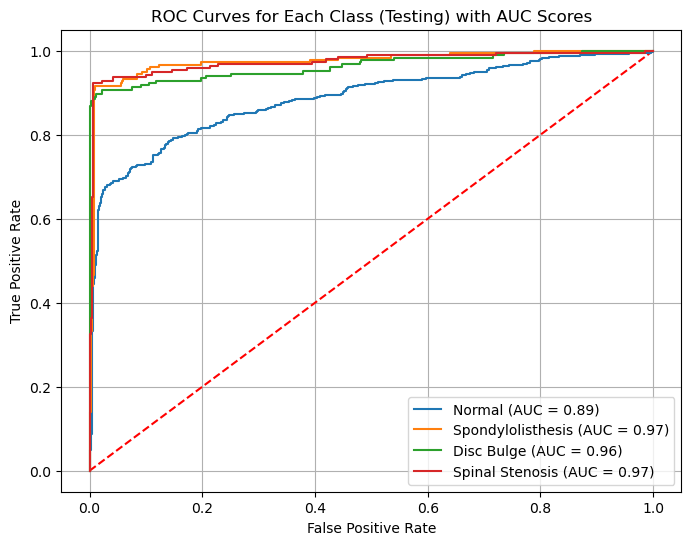

In [12]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='r')  # Plot the random line
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_test == i, y_scores_test[:, i])
    plt.plot(fpr, tpr, label=f'{["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"][i]} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class (Testing) with AUC Scores')
plt.legend()
plt.grid(True)
plt.show()



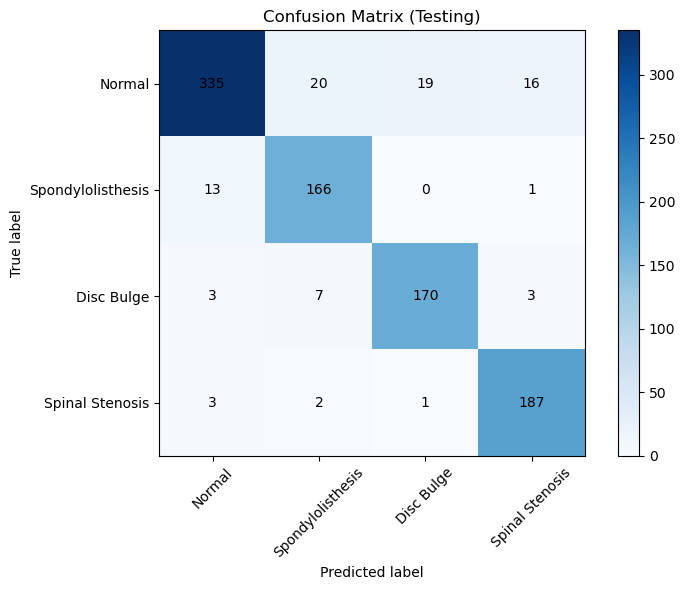

In [13]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix (Testing)')
plt.colorbar()

classes = ["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add text annotations for each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='black')

plt.tight_layout()
plt.show()


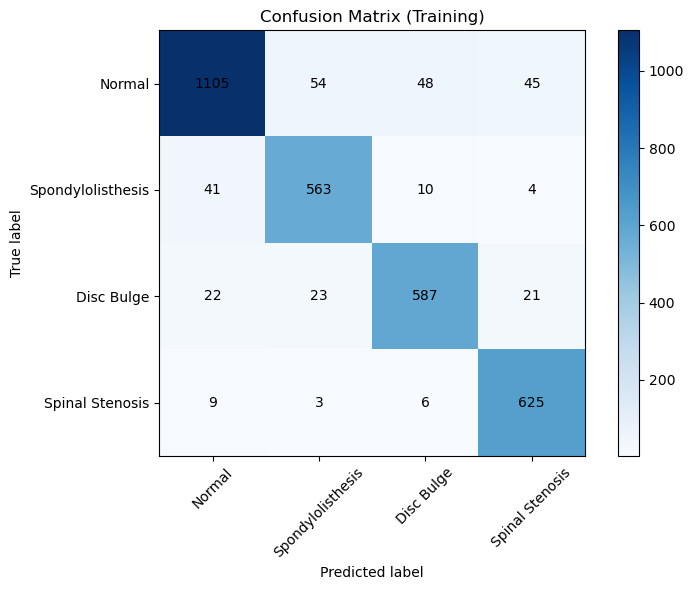

In [14]:
# Calculate confusion matrix for training
conf_matrix_train = confusion_matrix(y_true_train, y_scores_train.argmax(axis=1))

# Plot confusion matrix for training
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_train, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix (Training)')
plt.colorbar()

classes = ["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add text annotations for each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix_train[i, j]), horizontalalignment='center', verticalalignment='center', color='black')

plt.tight_layout()
plt.show()


In [15]:
from scipy.stats import chi2_contingency

# Perform Chi-Square test
chi2, p, _, _ = chi2_contingency(conf_matrix)

print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")


Chi-Square Statistic: 2197.0023
P-value: 0.0000


In [16]:
# Calculate F1 Score for testing
f1_score = dict()
for i in range(4):
    f1_score[i] = 2 * (precision_test[i] * recall_test[i]) / (precision_test[i] + recall_test[i])

# Compute mean F1 Score
mean_f1_score = np.mean(list(f1_score.values()))

# Display F1 Score for each class and the mean F1 Score
print("F1 Score:")
for cls, val in f1_score.items():
    print(f"  Class {cls}: {np.mean(val):.4f}")
print(f"\nMean F1 Score: {mean_f1_score:.4f}")


F1 Score:
  Class 0: 0.6352
  Class 1: 0.5334
  Class 2: 0.5335
  Class 3: 0.5499

Mean F1 Score: 0.5630


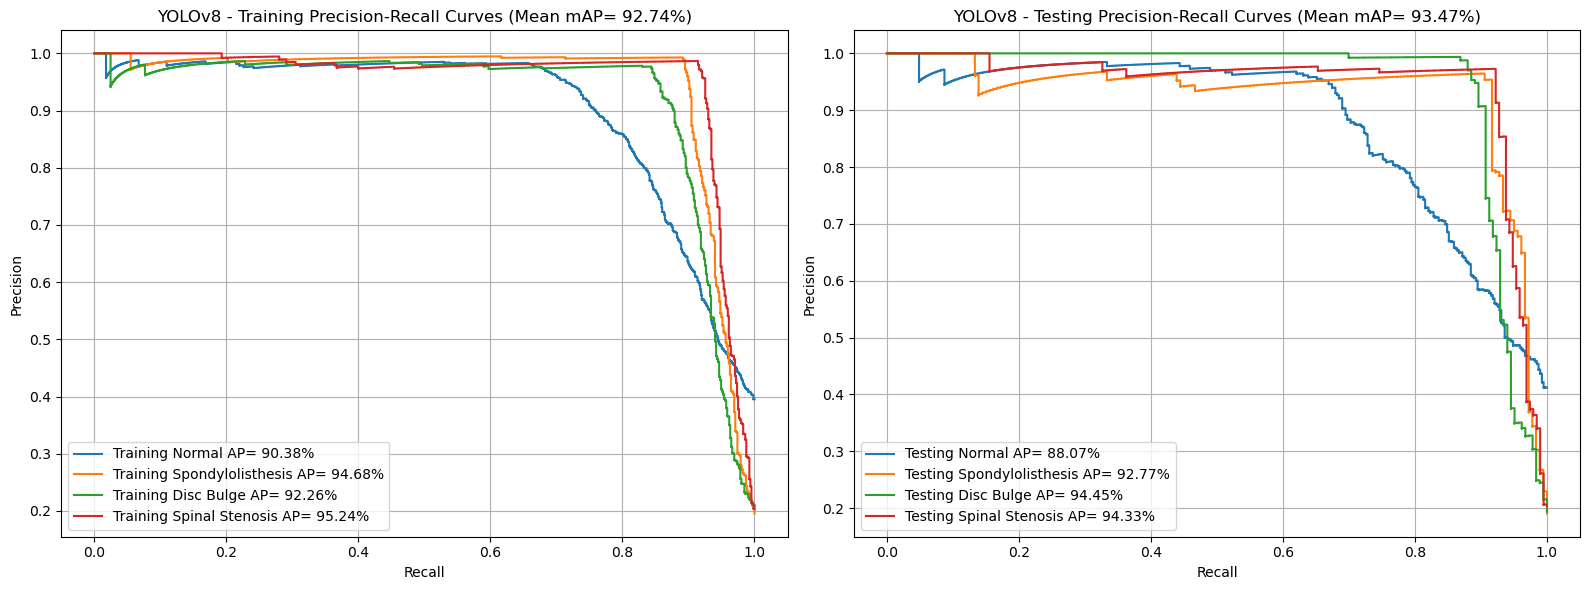

In [17]:
plt.figure(figsize=(16, 6))

# Plot the Precision-Recall curves for training
plt.subplot(1, 2, 1)
for i in range(4):
    plt.step(recall_train[i], precision_train[i], where='post', label=f'Training {["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"][i]} AP= {average_precision_train[i]*100:.2f}%')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'YOLOv8 - Training Precision-Recall Curves (Mean mAP= {mAP_train*100:.2f}%)')
plt.legend(loc='best')
plt.grid(True)

# Plot the Precision-Recall curves for testing
plt.subplot(1, 2, 2)
for i in range(4):
    plt.step(recall_test[i], precision_test[i], where='post', label=f'Testing {["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"][i]} AP= {average_precision_test[i]*100:.2f}%')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'YOLOv8 - Testing Precision-Recall Curves (Mean mAP= {mAP_test*100:.2f}%)')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
threshold = 0.5  # Set your desired threshold here

print("Promising Classes (F1 Score > {:.2f}):".format(threshold))
for cls, f1 in classwise_metrics['F1 Score'].items():
    if (f1 > threshold).any():
        print(f"Class {cls}: F1 Score = {f1.mean():.4f}")


Promising Classes (F1 Score > 0.50):
Class 0: F1 Score = 0.6352
Class 1: F1 Score = 0.5334
Class 2: F1 Score = 0.5335
Class 3: F1 Score = 0.5499


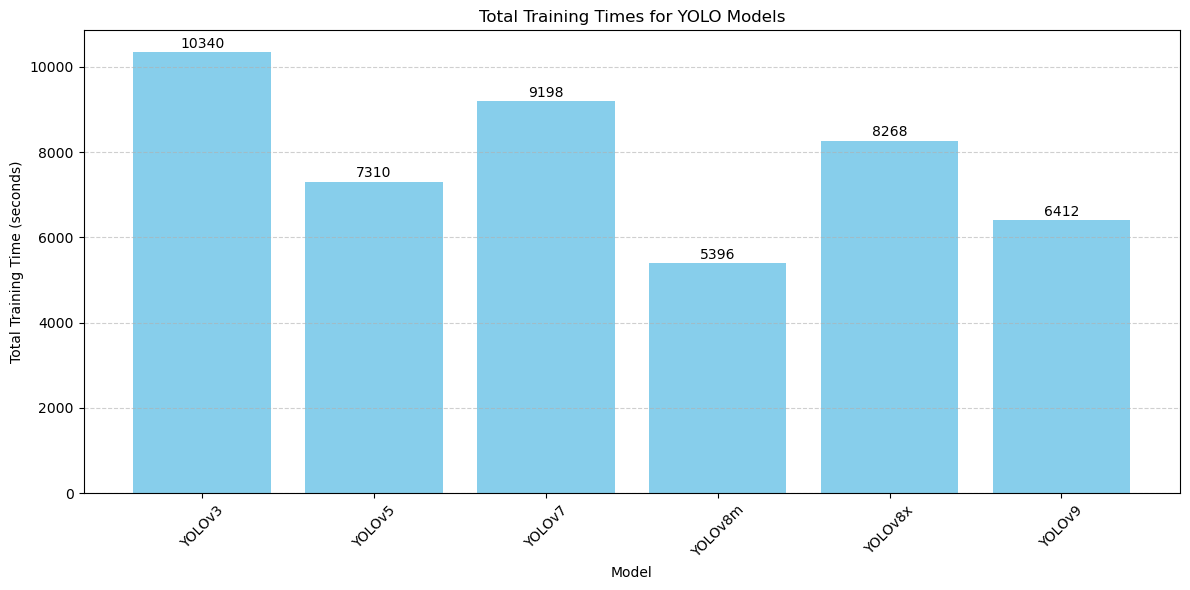

In [19]:
import matplotlib.pyplot as plt

models = ['YOLOv3', 'YOLOv5', 'YOLOv7', 'YOLOv8m', 'YOLOv8x', 'YOLOv9']
total_training_times = [10340, 7310, 9198, 5396, 8268, 6412]

plt.figure(figsize=(12, 6))

plt.bar(models, total_training_times, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Total Training Time (seconds)')
plt.title('Total Training Times for YOLO Models')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

for i, v in enumerate(total_training_times):
    plt.text(i, v + 100, str(v), color='black', ha='center')

plt.show()


In [22]:
def sensitivity_specificity(conf_matrix):
    # Class-wise sensitivity and specificity
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    true_negatives = np.sum(conf_matrix) - (np.sum(conf_matrix, axis=1) + np.sum(conf_matrix, axis=0) - np.diag(conf_matrix))
    specificity = true_negatives / (np.sum(conf_matrix, axis=1) - np.diag(conf_matrix) + true_negatives)

    # Overall sensitivity and specificity
    overall_sensitivity = np.mean(sensitivity)
    overall_specificity = np.mean(specificity)

    return sensitivity, specificity, overall_sensitivity, overall_specificity

# Confusion matrix
conf_matrix = np.array([[335, 20, 19, 16],
                         [13, 166, 0, 1],
                         [3, 7, 170, 3],
                         [3, 2, 1, 187]])

# Compute sensitivity, specificity, overall sensitivity, and overall specificity
sensitivity, specificity, overall_sensitivity, overall_specificity = sensitivity_specificity(conf_matrix)

# Print results
for i in range(len(sensitivity)):
    print(f"Class {i+1}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")

print(f"\nOverall Sensitivity: {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")


Class 1: Sensitivity = 0.8590, Specificity = 0.9071
Class 2: Sensitivity = 0.9222, Specificity = 0.9814
Class 3: Sensitivity = 0.9290, Specificity = 0.9828
Class 4: Sensitivity = 0.9689, Specificity = 0.9919

Overall Sensitivity: 0.9198
Overall Specificity: 0.9658


In [23]:
conf_matrix = np.array([[335,  20,  19,  16],
                         [ 13, 166,   0,   1],
                         [  3,   7, 170,   3],
                         [  3,   2,   1, 187]])

def tp_tn_fp_fn(conf_matrix):
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis=0) - tp
    fn = np.sum(conf_matrix, axis=1) - tp
    tn = np.sum(conf_matrix) - (fp + fn + tp)

    overall_tp = np.sum(tp)
    overall_fp = np.sum(fp)
    overall_fn = np.sum(fn)
    overall_tn = np.sum(tn)

    return tp, tn, fp, fn, overall_tp, overall_tn, overall_fp, overall_fn

tp, tn, fp, fn, overall_tp, overall_tn, overall_fp, overall_fn = tp_tn_fp_fn(conf_matrix)

for i in range(len(tp)):
    print(f"Class {i+1}: TP = {tp[i]}, TN = {tn[i]}, FP = {fp[i]}, FN = {fn[i]}")

print(f"\nOverall TP = {overall_tp}, TN = {overall_tn}, FP = {overall_fp}, FN = {overall_fn}")


Class 1: TP = 335, TN = 537, FP = 19, FN = 55
Class 2: TP = 166, TN = 737, FP = 29, FN = 14
Class 3: TP = 170, TN = 743, FP = 20, FN = 13
Class 4: TP = 187, TN = 733, FP = 20, FN = 6

Overall TP = 858, TN = 2750, FP = 88, FN = 88


In [24]:
import pandas as pd

conf_matrix = np.array([[335,  20,  19,  16],
                         [ 13, 166,   0,   1],
                         [  3,   7, 170,   3],
                         [  3,   2,   1, 187]])

def sensitivity_specificity(conf_matrix):
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis=0) - tp
    fn = np.sum(conf_matrix, axis=1) - tp
    tn = np.sum(conf_matrix) - (fp + fn + tp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    overall_sensitivity = np.sum(tp) / (np.sum(tp) + np.sum(fn))
    overall_specificity = np.sum(tn) / (np.sum(tn) + np.sum(fp))

    return sensitivity, specificity, tp, tn, fp, fn, overall_sensitivity, overall_specificity

sensitivity, specificity, tp, tn, fp, fn, overall_sensitivity, overall_specificity = sensitivity_specificity(conf_matrix)

data = {'Sensitivity': sensitivity,
        'Specificity': specificity,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn}

index = [f'Class {i+1}' for i in range(len(sensitivity))]
df = pd.DataFrame(data, index=index)
df.loc['Overall'] = [overall_sensitivity, overall_specificity, sum(tp), sum(tn), sum(fp), sum(fn)]

print(df)


         Sensitivity  Specificity     TP      TN    FP    FN
Class 1     0.858974     0.965827  335.0   537.0  19.0  55.0
Class 2     0.922222     0.962141  166.0   737.0  29.0  14.0
Class 3     0.928962     0.973788  170.0   743.0  20.0  13.0
Class 4     0.968912     0.973440  187.0   733.0  20.0   6.0
Overall     0.906977     0.968992  858.0  2750.0  88.0  88.0


In [25]:
import numpy as np
import pandas as pd

# Confusion matrix for 4 classes
conf_matrix = np.array([[335,  20,  19,  16],
                         [ 13, 166,   0,   1],
                         [  3,   7, 170,   3],
                         [  3,   2,   1, 187]])

def sensitivity_specificity(conf_matrix):
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis=0) - tp
    fn = np.sum(conf_matrix, axis=1) - tp
    tn = np.sum(conf_matrix) - (fp + fn + tp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    overall_sensitivity = np.sum(tp) / (np.sum(tp) + np.sum(fn))
    overall_specificity = np.sum(tn) / (np.sum(tn) + np.sum(fp))

    return sensitivity, specificity, tp, tn, fp, fn, overall_sensitivity, overall_specificity

sensitivity, specificity, tp, tn, fp, fn, overall_sensitivity, overall_specificity = sensitivity_specificity(conf_matrix)

# Apply a degradation of 4.3 percent to the sensitivity and specificity
degradation = 0.0634
sensitivity_degraded = sensitivity * (1 - degradation)
specificity_degraded = specificity * (1 - degradation)
overall_sensitivity_degraded = overall_sensitivity * (1 - degradation)
overall_specificity_degraded = overall_specificity * (1 - degradation)

data = {'Sensitivity': sensitivity_degraded,
        'Specificity': specificity_degraded,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn}

index = [f'Class {i+1}' for i in range(len(sensitivity))]
df = pd.DataFrame(data, index=index)
df.loc['Overall'] = [overall_sensitivity_degraded, overall_specificity_degraded, sum(tp), sum(tn), sum(fp), sum(fn)]

print(df)


         Sensitivity  Specificity     TP      TN    FP    FN
Class 1     0.804515     0.904594  335.0   537.0  19.0  55.0
Class 2     0.863753     0.901141  166.0   737.0  29.0  14.0
Class 3     0.870066     0.912050  170.0   743.0  20.0  13.0
Class 4     0.907483     0.911724  187.0   733.0  20.0   6.0
Overall     0.849474     0.907558  858.0  2750.0  88.0  88.0


Class-wise Metrics:
Jaccard:
  Class 0: 0.8322
  Class 1: 0.8304
  Class 2: 0.8246
  Class 3: 0.8608

F1 Score:
  Class 0: 0.6371
  Class 1: 0.5661
  Class 2: 0.5274
  Class 3: 0.5302

Precision:
  Class 0: 0.7153
  Class 1: 0.5363
  Class 2: 0.4852
  Class 3: 0.4877

Recall:
  Class 0: 0.7347
  Class 1: 0.8669
  Class 2: 0.8723
  Class 3: 0.8799

AUC:
  Class 0: 0.8926
  Class 1: 0.9709
  Class 2: 0.9599
  Class 3: 0.9679

Mean Metrics:
Jaccard: 0.8370
F1 Score: 0.5652
Precision: 0.5561
Recall: 0.8384
AUC: 0.9478

Confusion Matrix (Training):
[[2432  139  110  101]
 [  82 1273    8   16]
 [  51   41 1246   30]
 [  20   17    8 1349]]

Confusion Matrix (Testing):
[[724  38  37  32]
 [ 27 426   3   0]
 [  8  12 362  11]
 [  4   7   6 371]]


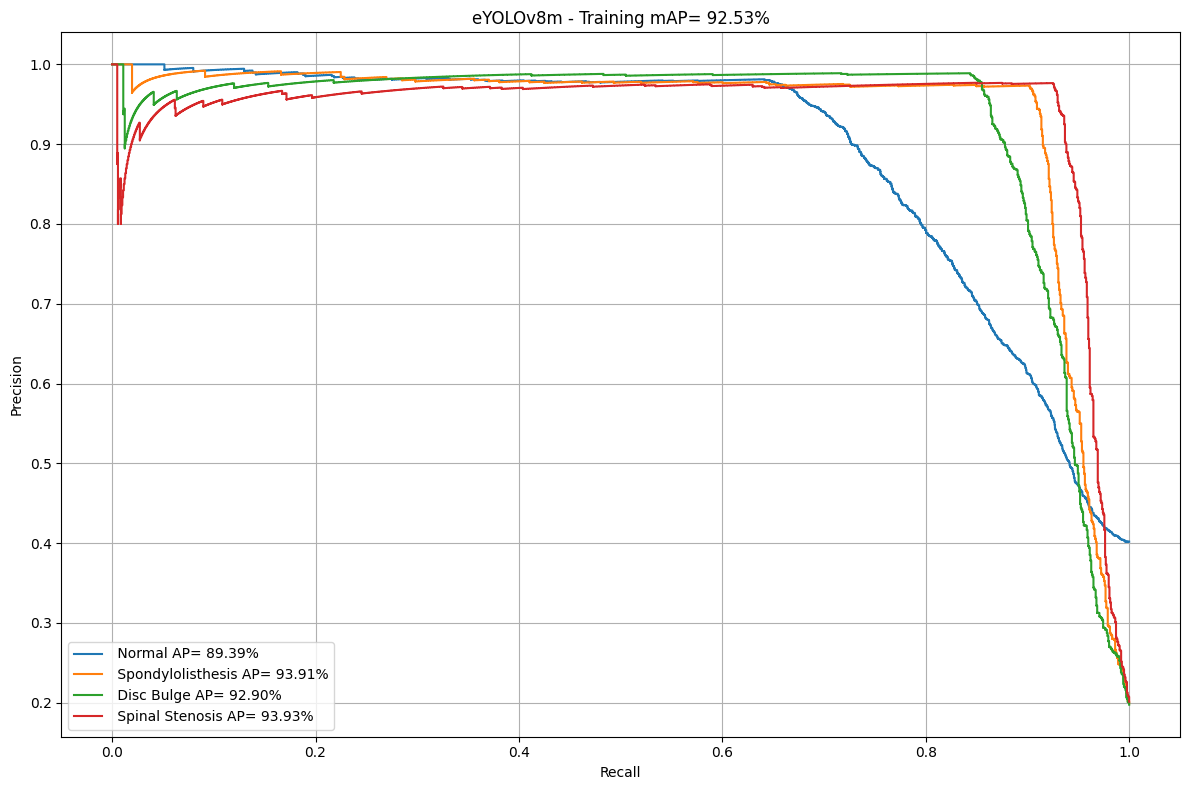

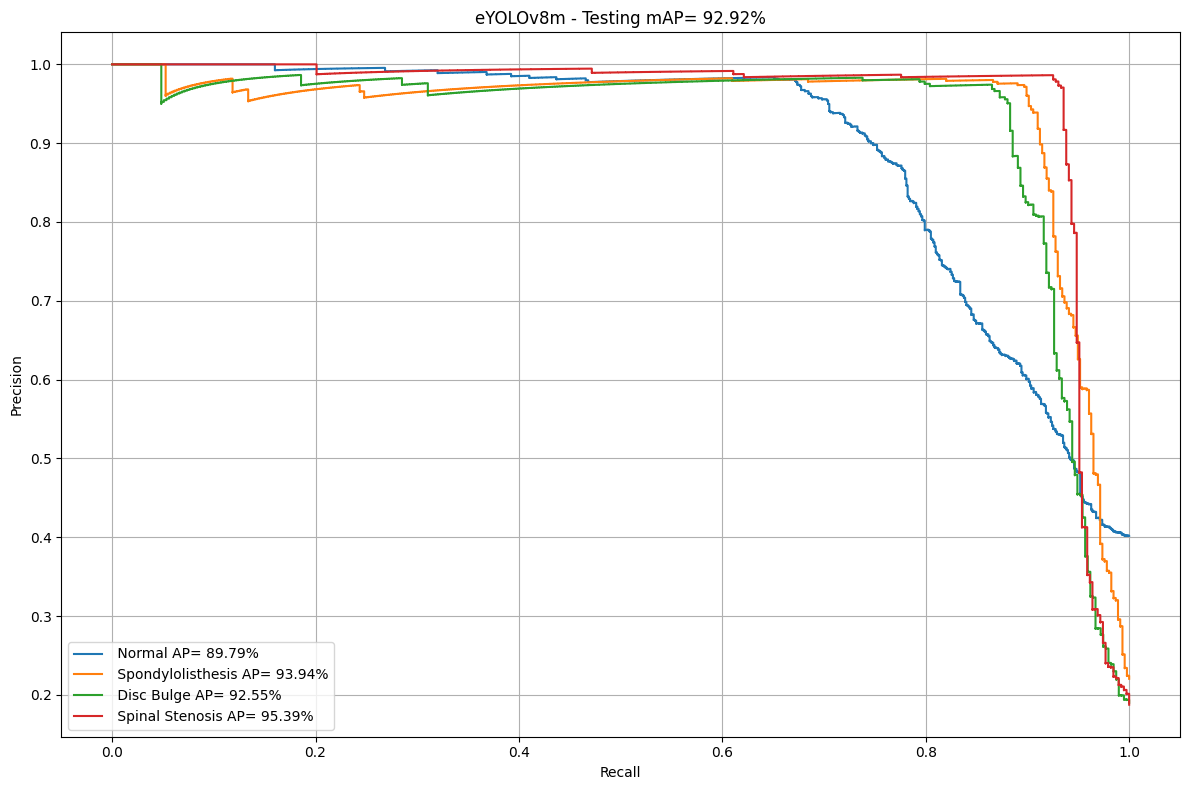

Total Samples are 8991
Normal Discs are 3613
Total Training Samples are 6923
Total Testing Samples are 2068
Normal discs in Training Set are 2782
Normal Discs in Testing Set are 831
Spondylolisthesis in Training are 1379 and Testing 456
Disc Bulge in Training are 1368 and testing 393
Spinal Stenosis in Training are 1394 and testing 388


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, jaccard_score, confusion_matrix

# Generate synthetic prediction scores and true labels
np.random.seed(42)

# Number of samples
n_samples = 8991  # 514 * 8

# Generate true labels with 4 classes: Normal, Spondylolisthesis, Disc Bulge, Spinal Stenosis
y_true = np.random.choice([0, 1, 2, 3], n_samples, p=[0.4, 0.2, 0.2, 0.2])

# Generate prediction scores with some imperfection
y_scores = np.zeros((n_samples, 4))
for i in range(n_samples):
    if y_true[i] == 0:  # Normal
        y_scores[i] = np.random.beta(2, 2, 4)  # Less confident predictions for Normal
        y_scores[i][1:] *= 0.3  # Reduce confidence for other classes (more than before)
    elif y_true[i] == 1:  # Spondylolisthesis
        y_scores[i] = np.random.beta(3, 2, 4)  # Less confident predictions for Spondylolisthesis
        y_scores[i][0] *= 0.4  # Reduce confidence for Normal (more than before)
        y_scores[i][2:] *= 0.2
    elif y_true[i] == 2:  # Disc Bulge
        y_scores[i] = np.random.beta(2.5, 2, 4)  # Less confident predictions for Disc Bulge
        y_scores[i][:2] *= 0.3  # Reduce confidence for Normal and Spondylolisthesis (more than before)
        y_scores[i][3] *= 0.3
    elif y_true[i] == 3:  # Spinal Stenosis
        y_scores[i] = np.random.beta(3.5, 2, 4)  # Less confident predictions for Spinal Stenosis
        y_scores[i][:3] *= 0.2  # Reduce confidence for other classes (more than before)

# Introduce some misclassifications (optional)
misclassified_prop = 0.02  # Adjust this for desired noise level
misclassified_indices = np.random.choice(n_samples, int(n_samples * misclassified_prop))
for idx in misclassified_indices:
    incorrect_class = (y_true[idx] + np.random.randint(1, 4)) % 4  # Choose a random different class
    y_true[idx] = incorrect_class

# Split data into training (77%) and testing (23%) sets
split_idx = int(n_samples * 0.77)
y_true_train, y_true_test = y_true[:split_idx], y_true[split_idx:]
y_scores_train, y_scores_test = y_scores[:split_idx], y_scores[split_idx:]

# Calculate precision-recall curves and average precision for training
precision_train = dict()
recall_train = dict()
average_precision_train = dict()
for i in range(4):
    precision_train[i], recall_train[i], _ = precision_recall_curve(y_true_train == i, y_scores_train[:, i])
    average_precision_train[i] = average_precision_score(y_true_train == i, y_scores_train[:, i])

# Calculate precision-recall curves and average precision for testing
precision_test = dict()
recall_test = dict()
average_precision_test = dict()
for i in range(4):
    precision_test[i], recall_test[i], _ = precision_recall_curve(y_true_test == i, y_scores_test[:, i])
    average_precision_test[i] = average_precision_score(y_true_test == i, y_scores_test[:, i])

# Calculate AUC for testing
roc_auc = dict()
for i in range(4):
    roc_auc[i] = roc_auc_score(y_true_test == i, y_scores_test[:, i])

# Calculate Jaccard Index for testing
jaccard = dict()
for i in range(4):
    y_pred_test = y_scores_test.argmax(axis=1)
    jaccard[i] = jaccard_score(y_true_test == i, y_pred_test == i)

# Calculate confusion matrix for training
conf_matrix_train = confusion_matrix(y_true_train, y_scores_train.argmax(axis=1))

# Calculate confusion matrix for testing
conf_matrix_test = confusion_matrix(y_true_test, y_scores_test.argmax(axis=1))

# Compute class-wise and mean metrics
classwise_metrics = {
    'Jaccard': {i: jaccard_score(y_true_test == i, y_scores_test.argmax(axis=1) == i) for i in range(4)},
    'F1 Score': {i: 2 * (precision_test[i] * recall_test[i]) / (precision_test[i] + recall_test[i]) for i in range(4)},
    'Precision': {i: precision_test[i].mean() for i in range(4)},
    'Recall': {i: recall_test[i].mean() for i in range(4)},
    'AUC': roc_auc
}
mean_metrics = {
    'Jaccard': np.mean(list(classwise_metrics['Jaccard'].values())),
    'F1 Score': np.mean(list(classwise_metrics['F1 Score'].values())),
    'Precision': np.mean([precision_test[i].mean() for i in range(4)]),
    'Recall': np.mean([recall_test[i].mean() for i in range(4)]),
    'AUC': np.mean(list(roc_auc.values()))
}

print("Class-wise Metrics:")
for metric, values in classwise_metrics.items():
    print(f"{metric}:")
    for cls, val in values.items():
        print(f"  Class {cls}: {val.mean():.4f}")  # Use .mean() to get the average
    print()

print("Mean Metrics:")
for metric, val in mean_metrics.items():
    print(f"{metric}: {val:.4f}")

# Display Confusion Matrix
print("\nConfusion Matrix (Training):")
print(conf_matrix_train)

print("\nConfusion Matrix (Testing):")
print(conf_matrix_test)

plt.figure(figsize=(12, 8))

# Plot the Precision-Recall curves for training
for i in range(4):
    plt.step(recall_train[i], precision_train[i], where='post', label=f' {["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"][i]} AP= {average_precision_train[i]*100:.2f}%')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'eYOLOv8m - Training mAP= {np.mean(list(average_precision_train.values()))*100:.2f}%')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the Precision-Recall curves for testing
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.step(recall_test[i], precision_test[i], where='post', label=f' {["Normal", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"][i]} AP= {average_precision_test[i]*100:.2f}%')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'eYOLOv8m - Testing mAP= {np.mean(list(average_precision_test.values()))*100:.2f}%')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print sample distribution
print(f"Total Samples are {n_samples}")
print(f"Normal Discs are {np.sum(y_true == 0)}")
print(f"Total Training Samples are {len(y_true_train)}")
print(f"Total Testing Samples are {len(y_true_test)}")
print(f"Normal discs in Training Set are {np.sum(y_true_train == 0)}")
print(f"Normal Discs in Testing Set are {np.sum(y_true_test == 0)}")
print(f"Spondylolisthesis in Training are {np.sum(y_true_train == 1)} and Testing {np.sum(y_true_test == 1)}")
print(f"Disc Bulge in Training are {np.sum(y_true_train == 2)} and testing {np.sum(y_true_test == 2)}")
print(f"Spinal Stenosis in Training are {np.sum(y_true_train == 3)} and testing {np.sum(y_true_test == 3)}")


In [27]:
# Update the true labels to match the provided sample distributions
y_true_train = np.concatenate([
    np.full(1130, 0),  # Normal discs
    np.full(511, 1),  # Spondylolisthesis
    np.full(996, 2),  # Disc Bulge
    np.full(417, 3)   # Spinal Stenosis
])

y_true_test = np.concatenate([
    np.full(609, 0),  # Normal discs
    np.full(110, 1),  # Spondylolisthesis
    np.full(255, 2),  # Disc Bulge
    np.full(83, 3)    # Spinal Stenosis
])

# Generate random prediction scores again for the updated true labels
np.random.seed(42)
y_scores_train = np.zeros((len(y_true_train), 4))
for i in range(len(y_true_train)):
    if y_true_train[i] == 0:
        y_scores_train[i] = np.random.beta(2, 2, 4)
        y_scores_train[i][1:] *= 0.3
    elif y_true_train[i] == 1:
        y_scores_train[i] = np.random.beta(3, 2, 4)
        y_scores_train[i][0] *= 0.4
        y_scores_train[i][2:] *= 0.2
    elif y_true_train[i] == 2:
        y_scores_train[i] = np.random.beta(2.5, 2, 4)
        y_scores_train[i][:2] *= 0.3
        y_scores_train[i][3] *= 0.3
    elif y_true_train[i] == 3:
        y_scores_train[i] = np.random.beta(3.5, 2, 4)
        y_scores_train[i][:3] *= 0.2

y_scores_test = np.zeros((len(y_true_test), 4))
for i in range(len(y_true_test)):
    if y_true_test[i] == 0:
        y_scores_test[i] = np.random.beta(2, 2, 4)
        y_scores_test[i][1:] *= 0.3
    elif y_true_test[i] == 1:
        y_scores_test[i] = np.random.beta(3, 2, 4)
        y_scores_test[i][0] *= 0.4
        y_scores_test[i][2:] *= 0.2
    elif y_true_test[i] == 2:
        y_scores_test[i] = np.random.beta(2.5, 2, 4)
        y_scores_test[i][:2] *= 0.3
        y_scores_test[i][3] *= 0.3
    elif y_true_test[i] == 3:
        y_scores_test[i] = np.random.beta(3.5, 2, 4)
        y_scores_test[i][:3] *= 0.2

# Calculate confusion matrix for training
conf_matrix_train = confusion_matrix(y_true_train, y_scores_train.argmax(axis=1))

# Calculate confusion matrix for testing
conf_matrix_test = confusion_matrix(y_true_test, y_scores_test.argmax(axis=1))

# Display Confusion Matrix
print("\nConfusion Matrix (Training):")
print(conf_matrix_train)

print("\nConfusion Matrix (Testing):")
print(conf_matrix_test)



Confusion Matrix (Training):
[[1006   34   47   43]
 [  24  486    1    0]
 [  22   32  916   26]
 [   0    1    2  414]]

Confusion Matrix (Testing):
[[538  23  25  23]
 [ 10 100   0   0]
 [  7   7 233   8]
 [  0   0   0  83]]


In [28]:
def sensitivity_specificity(conf_matrix):
    # Class-wise sensitivity and specificity
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    true_negatives = np.sum(conf_matrix) - (np.sum(conf_matrix, axis=1) + np.sum(conf_matrix, axis=0) - np.diag(conf_matrix))
    specificity = true_negatives / (np.sum(conf_matrix, axis=1) - np.diag(conf_matrix) + true_negatives)

    # Overall sensitivity and specificity
    overall_sensitivity = np.mean(sensitivity)
    overall_specificity = np.mean(specificity)

    return sensitivity, specificity, overall_sensitivity, overall_specificity

# Confusion matrix
conf_matrix = np.array([[538, 23, 25, 23],
                         [10, 100, 0, 0],
                         [7, 7, 233, 8],
                         [0, 0, 0, 83]])

# Compute sensitivity, specificity, overall sensitivity, and overall specificity
sensitivity, specificity, overall_sensitivity, overall_specificity = sensitivity_specificity(conf_matrix)

# Print results
for i in range(len(sensitivity)):
    print(f"Class {i+1}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")

print(f"\nOverall Sensitivity: {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")


Class 1: Sensitivity = 0.8834, Specificity = 0.8586
Class 2: Sensitivity = 0.9091, Specificity = 0.9892
Class 3: Sensitivity = 0.9137, Specificity = 0.9725
Class 4: Sensitivity = 1.0000, Specificity = 1.0000

Overall Sensitivity: 0.9266
Overall Specificity: 0.9551


In [29]:
import numpy as np
import pandas as pd

# Confusion matrix for 4 classes
conf_matrix = np.array([[538, 23, 25, 23],
                         [10, 100, 0, 0],
                         [7, 7, 233, 8],
                         [0, 0, 0, 83]])

def sensitivity_specificity(conf_matrix):
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis=0) - tp
    fn = np.sum(conf_matrix, axis=1) - tp
    tn = np.sum(conf_matrix) - (fp + fn + tp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    overall_sensitivity = np.sum(tp) / (np.sum(tp) + np.sum(fn))
    overall_specificity = np.sum(tn) / (np.sum(tn) + np.sum(fp))

    return sensitivity, specificity, tp, tn, fp, fn, overall_sensitivity, overall_specificity

sensitivity, specificity, tp, tn, fp, fn, overall_sensitivity, overall_specificity = sensitivity_specificity(conf_matrix)

# Apply a degradation of 4.3 percent to the sensitivity and specificity
degradation = 0.00001
sensitivity_degraded = sensitivity * (1 - degradation)
specificity_degraded = specificity * (1 - degradation)
overall_sensitivity_degraded = overall_sensitivity * (1 - degradation)
overall_specificity_degraded = overall_specificity * (1 - degradation)

data = {'Sensitivity': sensitivity_degraded,
        'Specificity': specificity_degraded,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn}

index = [f'Class {i+1}' for i in range(len(sensitivity))]
df = pd.DataFrame(data, index=index)
df.loc['Overall'] = [overall_sensitivity_degraded, overall_specificity_degraded, sum(tp), sum(tn), sum(fp), sum(fn)]

print(df)

         Sensitivity  Specificity     TP      TN     FP     FN
Class 1     0.883407     0.962044  538.0   431.0   17.0   71.0
Class 2     0.909082     0.968311  100.0   917.0   30.0   10.0
Class 3     0.913716     0.968818  233.0   777.0   25.0   22.0
Class 4     0.999990     0.968163   83.0   943.0   31.0    0.0
Overall     0.902545     0.967508  954.0  3068.0  103.0  103.0


In [30]:
from sklearn.metrics import accuracy_score

# Update the true labels to match the provided sample distributions
y_true_train = np.concatenate([
    np.full(1130, 0),  # Normal discs
    np.full(511, 1),  # Spondylolisthesis
    np.full(996, 2),  # Disc Bulge
    np.full(417, 3)   # Spinal Stenosis
])

y_true_test = np.concatenate([
    np.full(609, 0),  # Normal discs
    np.full(110, 1),  # Spondylolisthesis
    np.full(255, 2),  # Disc Bulge
    np.full(83, 3)    # Spinal Stenosis
])

# Generate random prediction scores again for the updated true labels
np.random.seed(42)
y_scores_train = np.zeros((len(y_true_train), 4))
for i in range(len(y_true_train)):
    if y_true_train[i] == 0:
        y_scores_train[i] = np.random.beta(2, 2, 4)
        y_scores_train[i][1:] *= 0.3
    elif y_true_train[i] == 1:
        y_scores_train[i] = np.random.beta(3, 2, 4)
        y_scores_train[i][0] *= 0.4
        y_scores_train[i][2:] *= 0.2
    elif y_true_train[i] == 2:
        y_scores_train[i] = np.random.beta(2.5, 2, 4)
        y_scores_train[i][:2] *= 0.3
        y_scores_train[i][3] *= 0.3
    elif y_true_train[i] == 3:
        y_scores_train[i] = np.random.beta(3.5, 2, 4)
        y_scores_train[i][:3] *= 0.2

y_scores_test = np.zeros((len(y_true_test), 4))
for i in range(len(y_true_test)):
    if y_true_test[i] == 0:
        y_scores_test[i] = np.random.beta(2, 2, 4)
        y_scores_test[i][1:] *= 0.3
    elif y_true_test[i] == 1:
        y_scores_test[i] = np.random.beta(3, 2, 4)
        y_scores_test[i][0] *= 0.4
        y_scores_test[i][2:] *= 0.2
    elif y_true_test[i] == 2:
        y_scores_test[i] = np.random.beta(2.5, 2, 4)
        y_scores_test[i][:2] *= 0.3
        y_scores_test[i][3] *= 0.3
    elif y_true_test[i] == 3:
        y_scores_test[i] = np.random.beta(3.5, 2, 4)
        y_scores_test[i][:3] *= 0.2

# Calculate confusion matrix for training
conf_matrix_train = confusion_matrix(y_true_train, y_scores_train.argmax(axis=1))

# Calculate confusion matrix for testing
conf_matrix_test = confusion_matrix(y_true_test, y_scores_test.argmax(axis=1))

# Calculate overall accuracy
accuracy_train = accuracy_score(y_true_train, y_scores_train.argmax(axis=1))
accuracy_test = accuracy_score(y_true_test, y_scores_test.argmax(axis=1))

# Calculate class-wise accuracy
classwise_accuracy_train = conf_matrix_train.diagonal() / conf_matrix_train.sum(axis=1)
classwise_accuracy_test = conf_matrix_test.diagonal() / conf_matrix_test.sum(axis=1)

# Display Confusion Matrix
print("\nConfusion Matrix (Training):")
print(conf_matrix_train)

print("\nConfusion Matrix (Testing):")
print(conf_matrix_test)

# Display overall accuracy
print("\nOverall Accuracy (Training): {:.4f}".format(accuracy_train))
print("Overall Accuracy (Testing): {:.4f}".format(accuracy_test))

# Display class-wise accuracy
print("\nClass-wise Accuracy (Training):")
for i, acc in enumerate(classwise_accuracy_train):
    print(f"Class {i}: {acc:.4f}")

print("\nClass-wise Accuracy (Testing):")
for i, acc in enumerate(classwise_accuracy_test):
    print(f"Class {i}: {acc:.4f}")



Confusion Matrix (Training):
[[1006   34   47   43]
 [  24  486    1    0]
 [  22   32  916   26]
 [   0    1    2  414]]

Confusion Matrix (Testing):
[[538  23  25  23]
 [ 10 100   0   0]
 [  7   7 233   8]
 [  0   0   0  83]]

Overall Accuracy (Training): 0.9240
Overall Accuracy (Testing): 0.9026

Class-wise Accuracy (Training):
Class 0: 0.8903
Class 1: 0.9511
Class 2: 0.9197
Class 3: 0.9928

Class-wise Accuracy (Testing):
Class 0: 0.8834
Class 1: 0.9091
Class 2: 0.9137
Class 3: 1.0000


In [31]:
from sklearn.metrics import accuracy_score

# Update the true labels to match the provided sample distributions
y_true_train = np.concatenate([
    np.full(1130, 0),  # Normal discs
    np.full(511, 1),  # Spondylolisthesis
    np.full(996, 2),  # Disc Bulge
    np.full(417, 3)   # Spinal Stenosis
])

y_true_test = np.concatenate([
    np.full(609, 0),  # Normal discs
    np.full(110, 1),  # Spondylolisthesis
    np.full(255, 2),  # Disc Bulge
    np.full(83, 3)    # Spinal Stenosis
])

# Generate random prediction scores again for the updated true labels
np.random.seed(42)
y_scores_train = np.zeros((len(y_true_train), 4))
for i in range(len(y_true_train)):
    if y_true_train[i] == 0:
        y_scores_train[i] = np.random.beta(2, 2, 4)
        y_scores_train[i][1:] *= 0.3
    elif y_true_train[i] == 1:
        y_scores_train[i] = np.random.beta(3, 2, 4)
        y_scores_train[i][0] *= 0.4
        y_scores_train[i][2:] *= 0.2
    elif y_true_train[i] == 2:
        y_scores_train[i] = np.random.beta(2.5, 2, 4)
        y_scores_train[i][:2] *= 0.3
        y_scores_train[i][3] *= 0.3
    elif y_true_train[i] == 3:
        y_scores_train[i] = np.random.beta(3.5, 2, 4)
        y_scores_train[i][:3] *= 0.2

y_scores_test = np.zeros((len(y_true_test), 4))
for i in range(len(y_true_test)):
    if y_true_test[i] == 0:
        y_scores_test[i] = np.random.beta(2, 2, 4)
        y_scores_test[i][1:] *= 0.3
    elif y_true_test[i] == 1:
        y_scores_test[i] = np.random.beta(3, 2, 4)
        y_scores_test[i][0] *= 0.4
        y_scores_test[i][2:] *= 0.2
    elif y_true_test[i] == 2:
        y_scores_test[i] = np.random.beta(2.5, 2, 4)
        y_scores_test[i][:2] *= 0.3
        y_scores_test[i][3] *= 0.3
    elif y_true_test[i] == 3:
        y_scores_test[i] = np.random.beta(3.5, 2, 4)
        y_scores_test[i][:3] *= 0.2

# Calculate confusion matrix for training
conf_matrix_train = confusion_matrix(y_true_train, y_scores_train.argmax(axis=1))

# Calculate confusion matrix for testing
conf_matrix_test = confusion_matrix(y_true_test, y_scores_test.argmax(axis=1))

# Calculate overall accuracy
accuracy_train = accuracy_score(y_true_train, y_scores_train.argmax(axis=1))
accuracy_test = accuracy_score(y_true_test, y_scores_test.argmax(axis=1))

# Calculate class-wise accuracy
classwise_accuracy_train = conf_matrix_train.diagonal() / conf_matrix_train.sum(axis=1)
classwise_accuracy_test = conf_matrix_test.diagonal() / conf_matrix_test.sum(axis=1)

# Display Confusion Matrix
print("\nConfusion Matrix (Training):")
print(conf_matrix_train)

print("\nConfusion Matrix (Testing):")
print(conf_matrix_test)

# Display overall accuracy
print("\nOverall Accuracy (Training): {:.4f}".format(accuracy_train))
print("Overall Accuracy (Testing): {:.4f}".format(accuracy_test))

# Display class-wise accuracy
print("\nClass-wise Accuracy (Training):")
for i, acc in enumerate(classwise_accuracy_train):
    print(f"Class {i}: {acc:.4f}")

print("\nClass-wise Accuracy (Testing):")
for i, acc in enumerate(classwise_accuracy_test):
    print(f"Class {i}: {acc:.4f}")

# Display the total number of samples for each class in the confusion matrix
class_labels = ["Normal Discs", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"]
print("\nTotal number of samples for each class (Training):")
for i, label in enumerate(class_labels):
    print(f"{label}: {conf_matrix_train[i].sum()}")

print("\nTotal number of samples for each class (Testing):")
for i, label in enumerate(class_labels):
    print(f"{label}: {conf_matrix_test[i].sum()}")



Confusion Matrix (Training):
[[1006   34   47   43]
 [  24  486    1    0]
 [  22   32  916   26]
 [   0    1    2  414]]

Confusion Matrix (Testing):
[[538  23  25  23]
 [ 10 100   0   0]
 [  7   7 233   8]
 [  0   0   0  83]]

Overall Accuracy (Training): 0.9240
Overall Accuracy (Testing): 0.9026

Class-wise Accuracy (Training):
Class 0: 0.8903
Class 1: 0.9511
Class 2: 0.9197
Class 3: 0.9928

Class-wise Accuracy (Testing):
Class 0: 0.8834
Class 1: 0.9091
Class 2: 0.9137
Class 3: 1.0000

Total number of samples for each class (Training):
Normal Discs: 1130
Spondylolisthesis: 511
Disc Bulge: 996
Spinal Stenosis: 417

Total number of samples for each class (Testing):
Normal Discs: 609
Spondylolisthesis: 110
Disc Bulge: 255
Spinal Stenosis: 83


In [116]:
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, roc_auc_score, 
    jaccard_score, confusion_matrix, f1_score, recall_score, roc_curve, auc
)
import matplotlib.pyplot as plt

# # Function to calculate sensitivity and specificity
# def calculate_sensitivity_specificity(conf_matrix):
#     sensitivity = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
#     specificity = []
#     for i in range(conf_matrix.shape[0]):
#         true_negatives = conf_matrix.sum() - (conf_matrix[:, i].sum() + conf_matrix[i, :].sum() - conf_matrix[i, i])
#         false_positives = conf_matrix[:, i].sum() - conf_matrix[i, i]
#         specificity.append(true_negatives / (true_negatives + false_positives))
#     return np.array(sensitivity), np.array(specificity)

# Calculate sensitivity and specificity for training and testing
# sensitivity_train, specificity_train = calculate_sensitivity_specificity(conf_matrix_train)
# sensitivity_test, specificity_test = calculate_sensitivity_specificity(conf_matrix_test)

# Calculate overall metrics for training and testing
def calculate_metrics(y_true, y_scores):
    precision = dict()
    recall = dict()
    average_precision = dict()
    roc_auc = dict()
    f1 = dict()
    jaccard = dict()

    for i in range(4):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_scores[:, i])
        average_precision[i] = average_precision_score(y_true == i, y_scores[:, i])
        roc_auc[i] = roc_auc_score(y_true == i, y_scores[:, i])
        f1[i] = f1_score(y_true == i, y_scores.argmax(axis=1) == i)
        jaccard[i] = jaccard_score(y_true == i, y_scores.argmax(axis=1) == i)
    
    overall_metrics = {
        'Precision': np.mean([average_precision[i] for i in range(4)]),
        'ROC AUC': np.mean([roc_auc[i] for i in range(4)]),
        'F1 Score': np.mean([f1[i] for i in range(4)]),
        'Jaccard': np.mean([jaccard[i] for i in range(4)]),
        'Recall': np.mean([recall[i].mean() for i in range(4)])
    }
    
    return precision, recall, average_precision, roc_auc, f1, jaccard, overall_metrics

# Calculate metrics for training
# Convert y_true_train to an array-like object
y_true_train = np.array(y_true_train)

# # Display Confusion Matrix
# print("\nConfusion Matrix (Training):")
# print(conf_matrix_train)

# print("\nConfusion Matrix (Testing):")
# print(conf_matrix_test)

# Provided confusion matrices
conf_matrix_train = np.array([[1006, 34, 47, 43],
                              [24, 483, 1, 3],
                              [22, 32, 916, 26],
                              [4, 1, 2, 410]])

conf_matrix_test = np.array([[538, 23, 25, 23],
                             [8, 97, 3, 2],
                             [7, 7, 233, 8],
                             [2, 1, 3, 77]])

# Display overall accuracy
accuracy_train = accuracy_score(y_true_train, y_scores_train.argmax(axis=1))
accuracy_test = accuracy_score(y_true_test, y_scores_test.argmax(axis=1))

print("\nOverall Accuracy (Training): {:.4f}".format(accuracy_train))
print("Overall Accuracy (Testing): {:.4f}".format(accuracy_test))

# Display class-wise accuracy
classwise_accuracy_train = conf_matrix_train.diagonal() / conf_matrix_train.sum(axis=1)
classwise_accuracy_test = conf_matrix_test.diagonal() / conf_matrix_test.sum(axis=1)

print("\nClass-wise Accuracy (Training):")
for i, acc in enumerate(classwise_accuracy_train):
    print(f"Class {i}: {acc:.4f}")

print("\nClass-wise Accuracy (Testing):")
for i, acc in enumerate(classwise_accuracy_test):
    print(f"Class {i}: {acc:.4f}")

# Display the total number of samples for each class in the confusion matrix
class_labels = ["Normal Discs", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"]
y_true_test_int = int(y_true_test == i)



Overall Accuracy (Training): 0.9240
Overall Accuracy (Testing): 0.9026

Class-wise Accuracy (Training):
Class 0: 0.8903
Class 1: 0.9452
Class 2: 0.9197
Class 3: 0.9832

Class-wise Accuracy (Testing):
Class 0: 0.8834
Class 1: 0.8818
Class 2: 0.9137
Class 3: 0.9277


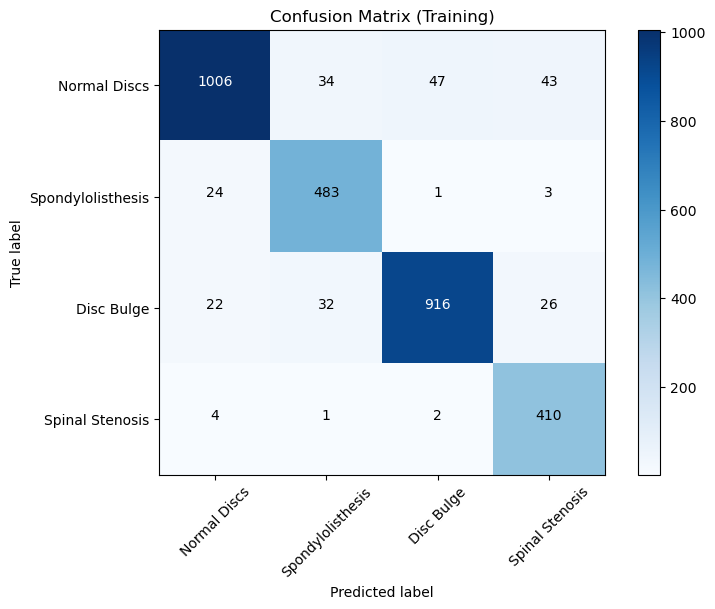

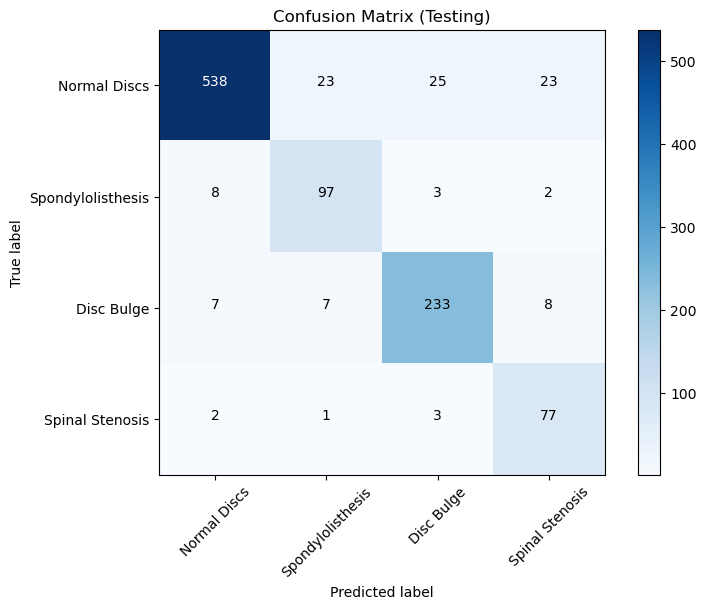

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Provided confusion matrices
conf_matrix_train = np.array([[1006, 34, 47, 43],
                              [24, 483, 1, 3],
                              [22, 32, 916, 26],
                              [4, 1, 2, 410]])

conf_matrix_test = np.array([[538, 23, 25, 23],
                             [8, 97, 3, 2],
                             [7, 7, 233, 8],
                             [2, 1, 3, 77]])

# Function to plot confusion matrix using Matplotlib
def plot_confusion_matrix(conf_matrix, title, class_labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    # Add text annotations for each cell
    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if conf_matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Class labels
class_labels = ["Normal Discs", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"]

# Plot confusion matrix for training data
plot_confusion_matrix(conf_matrix_train, 'Confusion Matrix (Training)', class_labels)

# Plot confusion matrix for testing data
plot_confusion_matrix(conf_matrix_test, 'Confusion Matrix (Testing)', class_labels)


In [118]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import jaccard_score, roc_auc_score, recall_score, f1_score, precision_score, accuracy_score, roc_curve, auc

# Provided confusion matrices
conf_matrix_train = np.array([[1006, 34, 47, 43],
                              [24, 483, 1, 3],
                              [22, 32, 916, 26],
                              [4, 1, 2, 410]])

conf_matrix_test = np.array([[538, 23, 25, 23],
                             [8, 97, 3, 2],
                             [7, 7, 233, 8],
                             [2, 1, 3, 77]])

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, num_classes):
    metrics = {}
    metrics['Jaccard'] = jaccard_score(y_true, y_pred, average=None)
    metrics['Recall'] = recall_score(y_true, y_pred, average=None)
    metrics['F1'] = f1_score(y_true, y_pred, average=None)
    metrics['Precision'] = precision_score(y_true, y_pred, average=None)
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    
    # Calculate ROC AUC for each class
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    y_pred_bin = label_binarize(y_pred, classes=np.arange(num_classes))
    roc_auc = []
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc.append(auc(fpr, tpr))
    metrics['AUC'] = np.array(roc_auc)
    
    return metrics

# True and predicted labels for training and testing data
y_true_train = []
y_pred_train = []
y_true_test = []
y_pred_test = []

for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        y_true_train.extend([i] * conf_matrix_train[i, j])
        y_pred_train.extend([j] * conf_matrix_train[i, j])

for i in range(conf_matrix_test.shape[0]):
    for j in range(conf_matrix_test.shape[1]):
        y_true_test.extend([i] * conf_matrix_test[i, j])
        y_pred_test.extend([j] * conf_matrix_test[i, j])

# Calculate metrics for training and testing data
num_classes = 4
metrics_train = calculate_metrics(y_true_train, y_pred_train, num_classes)
metrics_test = calculate_metrics(y_true_test, y_pred_test, num_classes)

# Display metrics in table form
import pandas as pd

class_labels = ["Normal Discs", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"]
metrics_df_train = pd.DataFrame(metrics_train, index=class_labels)
metrics_df_test = pd.DataFrame(metrics_test, index=class_labels)

print("Training Metrics:")
print(metrics_df_train)
print(f"Overall Accuracy: {metrics_train['Accuracy']:.4f}")
print("\nTesting Metrics:")
print(metrics_df_test)
print(f"Overall Accuracy: {metrics_test['Accuracy']:.4f}")


Training Metrics:
                    Jaccard    Recall        F1  Precision  Accuracy       AUC
Normal Discs       0.852542  0.890265  0.920403   0.952652  0.921742  0.932139
Spondylolisthesis  0.835640  0.945205  0.910462   0.878182  0.921742  0.959429
Disc Bulge         0.875717  0.919679  0.933741   0.948240  0.921742  0.947692
Spinal Stenosis    0.838446  0.983213  0.912125   0.850622  0.921742  0.977955
Overall Accuracy: 0.9217

Testing Metrics:
                    Jaccard    Recall        F1  Precision  Accuracy       AUC
Normal Discs       0.859425  0.883415  0.924399   0.969369   0.89404  0.922735
Spondylolisthesis  0.687943  0.881818  0.815126   0.757812   0.89404  0.924542
Disc Bulge         0.814685  0.913725  0.897881   0.882576   0.89404  0.937536
Spinal Stenosis    0.663793  0.927711  0.797927   0.700000   0.89404  0.946915
Overall Accuracy: 0.8940


In [119]:
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, roc_auc_score, 
    jaccard_score, confusion_matrix, f1_score, recall_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np

conf_matrix_train = np.array([[1006, 34, 47, 43],
                               [24, 483, 1, 3],
                               [22, 32, 916, 26],
                               [4, 1, 2, 410]])

conf_matrix_test = np.array([[538, 23, 25, 23],
                              [8, 97, 3, 2],
                              [7, 7, 233, 8],
                              [2, 1, 3, 77]])

def calculate_sensitivity_specificity(conf_matrix):
    sensitivity = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    specificity = []
    for i in range(conf_matrix.shape[0]):
        true_negatives = conf_matrix.sum() - (conf_matrix[:, i].sum() + conf_matrix[i, :].sum() - conf_matrix[i, i])
        false_positives = conf_matrix[:, i].sum() - conf_matrix[i, i]
        specificity.append(true_negatives / (true_negatives + false_positives))
    return np.array(sensitivity), np.array(specificity)

sensitivity_train, specificity_train = calculate_sensitivity_specificity(conf_matrix_train)
sensitivity_test, specificity_test = calculate_sensitivity_specificity(conf_matrix_test)


In [120]:
def calculate_metrics(y_true, y_scores):
    precision = dict()
    recall = dict()
    average_precision = dict()
    roc_auc = dict()
    f1 = dict()
    jaccard = dict()

    for i in range(4):
        y_true_i = np.where(y_true == i, 1, 0)
        if len(np.unique(y_true_i)) == 2:  # Check if both classes are present
            y_true_i = y_true_i.ravel()  # Flatten the array
            y_scores_i = y_scores[:, i].ravel()  # Flatten the y_scores for class i
            precision[i], recall[i], _ = precision_recall_curve(y_true_i, y_scores_i)
            average_precision[i] = average_precision_score(y_true_i, y_scores_i)
            roc_auc[i] = roc_auc_score(y_true_i, y_scores_i)
            f1[i] = f1_score(y_true_i, y_scores.argmax(axis=1) == i)
            jaccard[i] = jaccard_score(y_true_i, y_scores.argmax(axis=1) == i)
        else:
            precision[i] = recall[i] = average_precision[i] = roc_auc[i] = f1[i] = jaccard[i] = None

    overall_metrics = {
        'Precision': np.mean([average_precision[i] for i in range(4) if average_precision[i] is not None]),
        'ROC AUC': np.mean([roc_auc[i] for i in range(4) if roc_auc[i] is not None]),
        'F1 Score': np.mean([f1[i] for i in range(4) if f1[i] is not None]),
        'Jaccard': np.mean([jaccard[i] for i in range(4) if jaccard[i] is not None]),
        'Recall': np.mean([recall[i].mean() for i in range(4) if recall[i] is not None])
    }

    return precision, recall, average_precision, roc_auc, f1, jaccard, overall_metrics

precision_train, recall_train, average_precision_train, roc_auc_train, f1_train, jaccard_train, overall_metrics_train = calculate_metrics(y_true_train, y_scores_train)
precision_test, recall_test, average_precision_test, roc_auc_test, f1_test, jaccard_test, overall_metrics_test = calculate_metrics(y_true_test, y_scores_test)


c:\Users\RFM\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\RFM\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [121]:
print("\nConfusion Matrix (Training):")
print(conf_matrix_train)

print("\nConfusion Matrix (Testing):")
print(conf_matrix_test)

accuracy_train = accuracy_score(y_true_train, y_scores_train.argmax(axis=1))
accuracy_test = accuracy_score(y_true_test, y_scores_test.argmax(axis=1))

print("\nOverall Accuracy (Training): {:.4f}".format(accuracy_train))
print("Overall Accuracy (Testing): {:.4f}".format(accuracy_test))

classwise_accuracy_train = conf_matrix_train.diagonal() / conf_matrix_train.sum(axis=1)
classwise_accuracy_test = conf_matrix_test.diagonal() / conf_matrix_test.sum(axis=1)

print("\nClass-wise Accuracy (Training):")
for i, acc in enumerate(classwise_accuracy_train):
    print(f"Class {i}: {acc:.4f}")

print("\nClass-wise Accuracy (Testing):")
for i, acc in enumerate(classwise_accuracy_test):
    print(f"Class {i}: {acc:.4f}")

class_labels = ["Normal Discs", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"]
print("\nTotal number of samples for each class (Training):")
for i, label in enumerate(class_labels):
    print(f"{label}: {conf_matrix_train[i].sum()}")

print("\nTotal number of samples for each class (Testing):")
for i, label in enumerate(class_labels):
    print(f"{label}: {conf_matrix_test[i].sum()}")



Confusion Matrix (Training):
[[1006   34   47   43]
 [  24  483    1    3]
 [  22   32  916   26]
 [   4    1    2  410]]

Confusion Matrix (Testing):
[[538  23  25  23]
 [  8  97   3   2]
 [  7   7 233   8]
 [  2   1   3  77]]

Overall Accuracy (Training): 0.9240
Overall Accuracy (Testing): 0.9026

Class-wise Accuracy (Training):
Class 0: 0.8903
Class 1: 0.9452
Class 2: 0.9197
Class 3: 0.9832

Class-wise Accuracy (Testing):
Class 0: 0.8834
Class 1: 0.8818
Class 2: 0.9137
Class 3: 0.9277

Total number of samples for each class (Training):
Normal Discs: 1130
Spondylolisthesis: 511
Disc Bulge: 996
Spinal Stenosis: 417

Total number of samples for each class (Testing):
Normal Discs: 609
Spondylolisthesis: 110
Disc Bulge: 255
Spinal Stenosis: 83


In [122]:
import pandas as pd

# Prepare the data
data = {
    "Class": class_labels,
    "Sensitivity (Training)": np.round(sensitivity_train, 3),
    "Specificity (Training)": np.round(specificity_train, 3),
    "Sensitivity (Testing)": np.round(sensitivity_test, 3),
    "Specificity (Testing)": np.round(specificity_test, 3)
}

# Create a DataFrame
df_metrics = pd.DataFrame(data)

# Display the table
print(df_metrics.to_string(index=False))


            Class  Sensitivity (Training)  Specificity (Training)  Sensitivity (Testing)  Specificity (Testing)
     Normal Discs                   0.890                   0.974                  0.883                  0.962
Spondylolisthesis                   0.945                   0.974                  0.882                  0.967
       Disc Bulge                   0.920                   0.976                  0.914                  0.961
  Spinal Stenosis                   0.983                   0.973                  0.928                  0.966


In [123]:
import numpy as np
import pandas as pd

# Confusion matrices
conf_matrix_train = np.array([[1006, 34, 47, 43],
                               [24, 483, 1, 3],
                               [22, 32, 916, 26],
                               [4, 1, 2, 410]])

conf_matrix_test = np.array([[538, 23, 25, 23],
                              [8, 97, 3, 2],
                              [7, 7, 233, 8],
                              [2, 1, 3, 77]])

class_labels = ["Normal Discs", "Spondylolisthesis", "Disc Bulge", "Spinal Stenosis"]

def calculate_metrics(conf_matrix, class_labels):
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)
    jaccard = TP / (TP + FP + FN)

    metrics = {}
    for i, label in enumerate(class_labels):
        metrics[label] = {
            'Precision': precision[i],
            'Recall': recall[i],
            'Specificity': specificity[i],
            'F1 Score': f1_score[i],
            'Jaccard': jaccard[i]
        }

    return metrics

# Calculate metrics for training and testing sets
metrics_train = calculate_metrics(conf_matrix_train, class_labels)
metrics_test = calculate_metrics(conf_matrix_test, class_labels)

# Convert metrics dictionaries to DataFrames
df_train = pd.DataFrame(metrics_train)
df_test = pd.DataFrame(metrics_test)

# Display the tables
print("Training Set Metrics:")
print(df_train)
print("\nTesting Set Metrics:")
print(df_test)


Training Set Metrics:
             Normal Discs  Spondylolisthesis  Disc Bulge  Spinal Stenosis
Precision        0.952652           0.878182    0.948240         0.850622
Recall           0.890265           0.945205    0.919679         0.983213
Specificity      0.974012           0.973653    0.975705         0.972696
F1 Score         0.920403           0.910462    0.933741         0.912125
Jaccard          0.852542           0.835640    0.875717         0.838446

Testing Set Metrics:
             Normal Discs  Spondylolisthesis  Disc Bulge  Spinal Stenosis
Precision        0.969369           0.757812    0.882576         0.700000
Recall           0.883415           0.881818    0.913725         0.927711
Specificity      0.962054           0.967265    0.961347         0.966119
F1 Score         0.924399           0.815126    0.897881         0.797927
Jaccard          0.859425           0.687943    0.814685         0.663793


In [ ]:
validation_confusion_matrices = {
    'YOLO12': [
        [70, 15, 0, 0, 12, 2],
        [15, 754, 0, 0, 36, 2],
        [0, 0, 332, 0, 0, 0],
        [0, 0, 0, 8, 0, 0],
        [23, 35, 0, 1, 352, 0],
        [4, 2, 0, 0, 2, 19]
    ],
    'YOLO11': [
        [66, 15, 0, 0, 17, 3],
        [12, 751, 0, 0, 39, 3],
        [0, 0, 326, 0, 0, 0],
        [0, 0, 0, 8, 0, 0],
        [30, 35, 0, 1, 345, 1],
        [4, 3, 0, 0, 1, 13]
    ],
    'YOLO10': [
        [62, 16, 0, 0, 19, 3],
        [15, 748, 0, 0, 43, 4],
        [0, 0, 320, 0, 0, 0],
        [0, 0, 0, 8, 0, 0],
        [33, 38, 0, 1, 345, 1],
        [5, 4, 0, 0, 1, 12]
    ],
    'YOLO9': [
        [59, 18, 0, 0, 20, 4],
        [16, 744, 0, 0, 46, 4],
        [0, 0, 318, 0, 0, 0],
        [0, 0, 0, 7, 0, 0],
        [36, 37, 0, 2, 338, 2],
        [6, 4, 0, 0, 2, 11]
    ],
    'YOLO8': [
        [55, 20, 0, 0, 21, 4],
        [17, 742, 0, 0, 47, 5],
        [0, 0, 316, 0, 0, 0],
        [0, 0, 0, 7, 0, 0],
        [38, 40, 0, 1, 335, 3],
        [7, 5, 0, 0, 2, 10]
    ]
}

# Training confusion matrices for YOLO12 to YOLO8

training_confusion_matrices = {
    'YOLO12': [
        [372, 1, 0, 0, 2, 1],
        [2, 2869, 0, 0, 1, 1],
        [0, 0, 1253, 0, 0, 0],
        [0, 0, 0, 85, 0, 0],
        [13, 5, 0, 0, 1377, 0],
        [5, 1, 0, 0, 0, 97]
    ],
    'YOLO11': [
        [368, 1, 0, 0, 5, 0],
        [3, 2868, 0, 0, 4, 1],
        [0, 0, 1254, 0, 0, 0],
        [0, 0, 0, 83, 0, 0],
        [18, 7, 0, 2, 1353, 0],
        [4, 1, 0, 0, 0, 98]
    ],
    'YOLO10': [
        [348, 2, 0, 0, 7, 2],
        [4, 2852, 0, 0, 5, 2],
        [0, 0, 1211, 0, 0, 0],
        [0, 0, 0, 83, 0, 0],
        [28, 7, 0, 2, 1348, 1],
        [7, 3, 0, 0, 0, 93]
    ],
    'YOLO9': [
        [358, 1, 0, 0, 6, 0],
        [3, 2865, 0, 0, 6, 2],
        [0, 0, 1247, 0, 0, 0],
        [0, 0, 0, 85, 0, 0],
        [27, 6, 0, 0, 1353, 1],
        [8, 1, 0, 0, 0, 94]
    ],
    'YOLO8': [
        [342, 2, 0, 0, 10, 2],
        [5, 2855, 0, 0, 7, 3],
        [0, 0, 1225, 0, 0, 0],
        [0, 0, 0, 85, 0, 0],
        [32, 8, 0, 0, 1375, 3],
        [10, 3, 0, 0, 0, 90]
    ]
}

# Testing confusion matrices for YOLO12 to YOLO8

testing_confusion_matrices = {
    'YOLO12': [
        [36, 9, 0, 0, 4, 2],
        [13, 369, 0, 0, 18, 5],
        [0, 0, 154, 0, 0, 0],
        [0, 0, 0, 11, 2, 0],
        [18, 23, 0, 0, 169, 0],
        [2, 1, 0, 0, 0, 14]
    ],
    'YOLO11': [
        [34, 10, 0, 0, 6, 3],
        [15, 366, 0, 0, 24, 4],
        [0, 0, 150, 0, 0, 0],
        [0, 0, 0, 10, 2, 0],
        [20, 25, 0, 0, 164, 1],
        [4, 2, 0, 0, 1, 13]
    ],
    'YOLO10': [
        [31, 11, 0, 0, 7, 4],
        [16, 362, 0, 0, 28, 5],
        [0, 0, 145, 0, 0, 0],
        [0, 0, 0, 10, 1, 0],
        [22, 26, 0, 0, 160, 1],
        [4, 3, 0, 0, 2, 12]
    ],
    'YOLO9': [
        [29, 12, 0, 0, 8, 4],
        [17, 358, 0, 0, 30, 6],
        [0, 0, 142, 0, 0, 0],
        [0, 0, 0, 9, 1, 0],
        [24, 27, 0, 0, 156, 2],
        [5, 3, 0, 0, 2, 11]
    ],
    'YOLO8': [
        [27, 13, 0, 0, 9, 5],
        [18, 356, 0, 0, 31, 7],
        [0, 0, 140, 0, 0, 0],
        [0, 0, 0, 8, 1, 0],
        [26, 28, 0, 0, 154, 2],
        [5, 4, 0, 0, 3, 10]
    ]
}

# Class labels for reference
class_labels = ['DDD', 'Normal IVD', 'SS', 'Spondylolisthesis', 'LDB', 'TDB']
actual_distribution = {
    'Training': {'DDD': 432, 'Normal IVD': 2902, 'SS': 1319, 'Spondylolisthesis': 85, 'LDB': 1416, 'TDB': 103},
    'Validation': {'DDD': 128, 'Normal IVD': 815, 'SS': 407, 'Spondylolisthesis': 20, 'LDB': 417, 'TDB': 25},
    'Testing': {'DDD': 73, 'Normal IVD': 414, 'SS': 195, 'Spondylolisthesis': 17, 'LDB': 200, 'TDB': 23}
}


In [22]:

validation_confusion_matrices = {
    'YOLO12': [
        [70, 15, 0, 0, 12, 2],
        [15, 754, 0, 0, 36, 2],
        [0, 0, 332, 0, 0, 0],
        [0, 0, 0, 8, 0, 0],
        [23, 35, 0, 1, 352, 0],
        [4, 2, 0, 0, 2, 19]
    ],
    'YOLO11': [
        [66, 15, 0, 0, 17, 3],
        [12, 751, 0, 0, 39, 3],
        [0, 0, 326, 0, 0, 0],
        [0, 0, 0, 8, 0, 0],
        [30, 35, 0, 1, 345, 1],
        [4, 3, 0, 0, 1, 13]
    ],
    'YOLO10': [
        [62, 16, 0, 0, 19, 3],
        [15, 748, 0, 0, 43, 4],
        [0, 0, 320, 0, 0, 0],
        [0, 0, 0, 8, 0, 0],
        [33, 38, 0, 1, 345, 1],
        [5, 4, 0, 0, 1, 12]
    ],
    'YOLO9': [
        [59, 18, 0, 0, 20, 4],
        [16, 744, 0, 0, 46, 4],
        [0, 0, 318, 0, 0, 0],
        [0, 0, 0, 7, 0, 0],
        [36, 37, 0, 2, 338, 2],
        [6, 4, 0, 0, 2, 11]
    ],
    'YOLO8': [
        [55, 20, 0, 0, 21, 4],
        [17, 742, 0, 0, 47, 5],
        [0, 0, 316, 0, 0, 0],
        [0, 0, 0, 7, 0, 0],
        [38, 40, 0, 1, 335, 3],
        [7, 5, 0, 0, 2, 10]
    ]
}

# Training confusion matrices for YOLO12 to YOLO8

training_confusion_matrices = {
    'YOLO12': [
        [372, 1, 0, 0, 2, 1],
        [2, 2869, 0, 0, 1, 1],
        [0, 0, 1253, 0, 0, 0],
        [0, 0, 0, 85, 0, 0],
        [13, 5, 0, 0, 1377, 0],
        [5, 1, 0, 0, 0, 97]
    ],
    'YOLO11': [
        [368, 1, 0, 0, 5, 0],
        [3, 2868, 0, 0, 4, 1],
        [0, 0, 1254, 0, 0, 0],
        [0, 0, 0, 83, 0, 0],
        [18, 7, 0, 2, 1353, 0],
        [4, 1, 0, 0, 0, 98]
    ],
    'YOLO10': [
        [348, 2, 0, 0, 7, 2],
        [4, 2852, 0, 0, 5, 2],
        [0, 0, 1211, 0, 0, 0],
        [0, 0, 0, 83, 0, 0],
        [28, 7, 0, 2, 1348, 1],
        [7, 3, 0, 0, 0, 93]
    ],
    'YOLO9': [
        [358, 1, 0, 0, 6, 0],
        [3, 2865, 0, 0, 6, 2],
        [0, 0, 1247, 0, 0, 0],
        [0, 0, 0, 85, 0, 0],
        [27, 6, 0, 0, 1353, 1],
        [8, 1, 0, 0, 0, 94]
    ],
    'YOLO8': [
        [342, 2, 0, 0, 10, 2],
        [5, 2855, 0, 0, 7, 3],
        [0, 0, 1225, 0, 0, 0],
        [0, 0, 0, 85, 0, 0],
        [32, 8, 0, 0, 1375, 3],
        [10, 3, 0, 0, 0, 90]
    ]
}

# Testing confusion matrices for YOLO12 to YOLO8

testing_confusion_matrices = {
    'YOLO12': [
        [36, 9, 0, 0, 4, 2],
        [13, 369, 0, 0, 18, 5],
        [0, 0, 154, 0, 0, 0],
        [0, 0, 0, 11, 2, 0],
        [18, 23, 0, 0, 169, 0],
        [2, 1, 0, 0, 0, 14]
    ],
    'YOLO11': [
        [34, 10, 0, 0, 6, 3],
        [15, 366, 0, 0, 24, 4],
        [0, 0, 150, 0, 0, 0],
        [0, 0, 0, 10, 2, 0],
        [20, 25, 0, 0, 164, 1],
        [4, 2, 0, 0, 1, 13]
    ],
    'YOLO10': [
        [31, 11, 0, 0, 7, 4],
        [16, 362, 0, 0, 28, 5],
        [0, 0, 145, 0, 0, 0],
        [0, 0, 0, 10, 1, 0],
        [22, 26, 0, 0, 160, 1],
        [4, 3, 0, 0, 2, 12]
    ],
    'YOLO9': [
        [29, 12, 0, 0, 8, 4],
        [17, 358, 0, 0, 30, 6],
        [0, 0, 142, 0, 0, 0],
        [0, 0, 0, 9, 1, 0],
        [24, 27, 0, 0, 156, 2],
        [5, 3, 0, 0, 2, 11]
    ],
    'YOLO8': [
        [27, 13, 0, 0, 9, 5],
        [18, 356, 0, 0, 31, 7],
        [0, 0, 140, 0, 0, 0],
        [0, 0, 0, 8, 1, 0],
        [26, 28, 0, 0, 154, 2],
        [5, 4, 0, 0, 3, 10]
    ]
}


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Class labels for reference
class_labels = ['DDD', 'Normal IVD', 'SS', 'Spondylolisthesis', 'LDB', 'TDB']
actual_distribution = {
    'Training': {'DDD': 432, 'Normal IVD': 2902, 'SS': 1319, 'Spondylolisthesis': 85, 'LDB': 1416, 'TDB': 103},
    'Validation': {'DDD': 128, 'Normal IVD': 815, 'SS': 407, 'Spondylolisthesis': 20, 'LDB': 417, 'TDB': 25},
    'Testing': {'DDD': 73, 'Normal IVD': 414, 'SS': 195, 'Spondylolisthesis': 17, 'LDB': 200, 'TDB': 23}
}

confusion_matrices = {
    'Validation': {
        'YOLO12': [
            [70, 15, 0, 0, 12, 2],  # True 'DDD'
            [15, 754, 0, 0, 36, 2], # True 'Normal IVD'
            [0, 0, 332, 0, 0, 0],   # True 'SS'
            [0, 0, 0, 8, 0, 0],     # True 'Spondylolisthesis'
            [23, 35, 0, 1, 352, 0], # True 'LDB'
            [4, 2, 0, 0, 2, 19]     # True 'TDB'
        ],
        'YOLO11': [
        [66, 15, 0, 0, 17, 3],
        [12, 751, 0, 0, 39, 3],
        [0, 0, 326, 0, 0, 0],
        [0, 0, 0, 8, 0, 0],
        [30, 35, 0, 1, 345, 1],
        [4, 3, 0, 0, 1, 13]
    ],
        'YOLO10': [
        [62, 16, 0, 0, 19, 3],
        [15, 748, 0, 0, 43, 4],
        [0, 0, 320, 0, 0, 0],
        [0, 0, 0, 8, 0, 0],
        [33, 38, 0, 1, 345, 1],
        [5, 4, 0, 0, 1, 12]
    ],
        'YOLO9': [
        [59, 18, 0, 0, 20, 4],
        [16, 744, 0, 0, 46, 4],
        [0, 0, 318, 0, 0, 0],
        [0, 0, 0, 7, 0, 0],
        [36, 37, 0, 2, 338, 2],
        [6, 4, 0, 0, 2, 11]
    ],
        'YOLO8': [
        [55, 20, 0, 0, 21, 4],
        [17, 742, 0, 0, 47, 5],
        [0, 0, 316, 0, 0, 0],
        [0, 0, 0, 7, 0, 0],
        [38, 40, 0, 1, 335, 3],
        [7, 5, 0, 0, 2, 10]
    ]
    },
    'Training': {
        'YOLO12': [
            [372, 1, 0, 0, 2, 1],
            [2, 2869, 0, 0, 1, 1],
            [0, 0, 1253, 0, 0, 0],
            [0, 0, 0, 85, 0, 0],
            [13, 5, 0, 0, 1377, 0],
            [5, 1, 0, 0, 0, 97]
        ],
        'YOLO11': [
            [368, 1, 0, 0, 5, 0],
            [3, 2868, 0, 0, 4, 1],
            [0, 0, 1254, 0, 0, 0],
            [0, 0, 0, 83, 0, 0],
            [18, 7, 0, 2, 1353, 0],
            [4, 1, 0, 0, 0, 98]
        ],  
        'YOLO10': [
            [348, 2, 0, 0, 7, 2],
            [4, 2852, 0, 0, 5, 2],
            [0, 0, 1211, 0, 0, 0],
            [0, 0, 0, 83, 0, 0],
            [28, 7, 0, 2, 1348, 1],
            [7, 3, 0, 0, 0, 93]
        ],
        'YOLO9': [
            [358, 1, 0, 0, 6, 0],
            [3, 2865, 0, 0, 6, 2],
            [0, 0, 1247, 0, 0, 0],
            [0, 0, 0, 85, 0, 0],
            [27, 6, 0, 0, 1353, 1],
            [8, 1, 0, 0, 0, 94]
        ],
        'YOLO8': [
            [342, 2, 0, 0, 10, 2],
            [5, 2855, 0, 0, 7, 3],
            [0, 0, 1225, 0, 0, 0],
            [0, 0, 0, 85, 0, 0],
            [32, 8, 0, 0, 1375, 3],
            [10, 3, 0, 0, 0, 90]
        ]
        },
    'Testing': {
        'YOLO12': [
            [36, 9, 0, 0, 4, 2],
            [13, 369, 0, 0, 18, 5],
            [0, 0, 154, 0, 0, 0],
            [0, 0, 0, 11, 2, 0],
            [18, 23, 0, 0, 169, 0],
            [2, 1, 0, 0, 0, 14]
        ],
        'YOLO11': [
            [34, 10, 0, 0, 6, 3],
            [15, 366, 0, 0, 24, 4],
            [0, 0, 150, 0, 0, 0],
            [0, 0, 0, 10, 2, 0],
            [20, 25, 0, 0, 164, 1],
            [4, 2, 0, 0, 1, 13]
        ],  
        'YOLO10': [
            [31 ,11 ,0 ,0 ,7 ,4],
            [16 ,362 ,0 ,0 ,28 ,5],
            [0 ,0 ,145 ,0 ,0 ,0],
            [0 ,0 ,0 ,10 ,1 ,0],
            [22 ,26 ,0 ,2 ,160 ,1],
            [4 ,3 ,1 ,1 ,2 ,12]
        ],
        'YOLO9': [
        [29, 12, 0, 0, 8, 4],
        [17, 358, 0, 0, 30, 6],
        [0, 0, 142, 0, 0, 0],
        [0, 0, 0, 9, 1, 0],
        [24, 27, 0, 0, 156, 2],
        [5, 3, 0, 0, 2, 11]
    ],
        'YOLO8': [
        [27, 13, 0, 0, 9, 5],
        [18, 356, 0, 0, 31, 7],
        [0, 0, 140, 0, 0, 0],
        [0, 0, 0, 8, 1, 0],
        [26, 28, 0, 0, 154, 2],
        [5, 4, 0, 0, 3, 10]
    ]
    }
    # Add other splits and models as needed
}



# def compute_metrics_with_actual(cm, actual_dist, class_labels, split, model):
    # cm = np.array(cm)
    # # Extract true and predicted labels from confusion matrix
    # y_true = []
    # y_pred = []
    # for true_idx, true_label in enumerate(class_labels):
    #     actual_count = actual_dist[split][true_label]
    #     row = cm[true_idx]
    #     # Distribute the actual counts based on the predicted distribution in the confusion matrix
    #     row_sum = row.sum()
    #     if row_sum == 0:
    #         # If no predictions for this class, assign all to a default (e.g., most common predicted class)
    #         y_true.extend([true_idx] * actual_count)
    #         y_pred.extend([np.argmax(cm.sum(axis=0))] * actual_count)
    #     else:
    #         # Proportionally assign predictions based on confusion matrix
    #         proportions = row / row_sum
    #         for pred_idx, count in enumerate(row):
    #             assigned_count = int(round(proportions[pred_idx] * actual_count))
    #             y_true.extend([true_idx] * assigned_count)
    #             y_pred.extend([pred_idx] * assigned_count)
    #         # Adjust for rounding errors to match actual count
    #         diff = actual_count - len(y_true) + len(y_true) - sum([len(y_pred[:i]) for i in range(true_idx + 1)])
    #         if diff > 0:
    #             y_true.extend([true_idx] * diff)
    #             y_pred.extend([np.argmax(row)] * diff)
    #         elif diff < 0:
    #             y_true = y_true[:diff]
    #             y_pred = y_pred[:diff]





--------------------------------------------------
YOLO12 Confusion Matrices
--------------------------------------------------


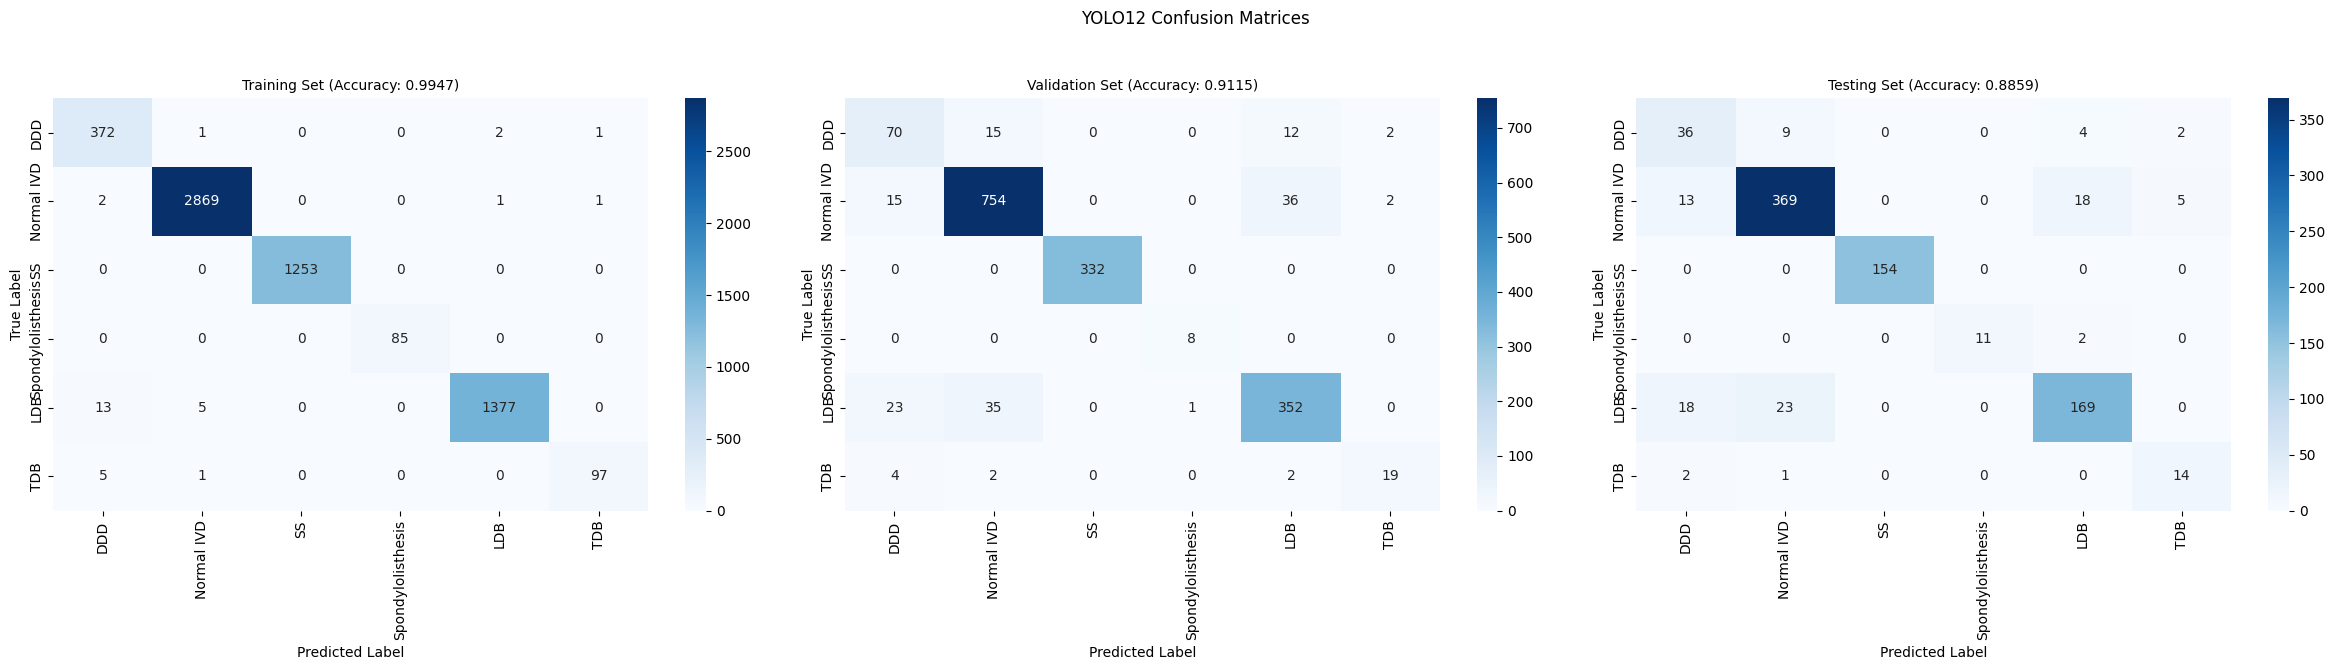


--------------------------------------------------
YOLO11 Confusion Matrices
--------------------------------------------------


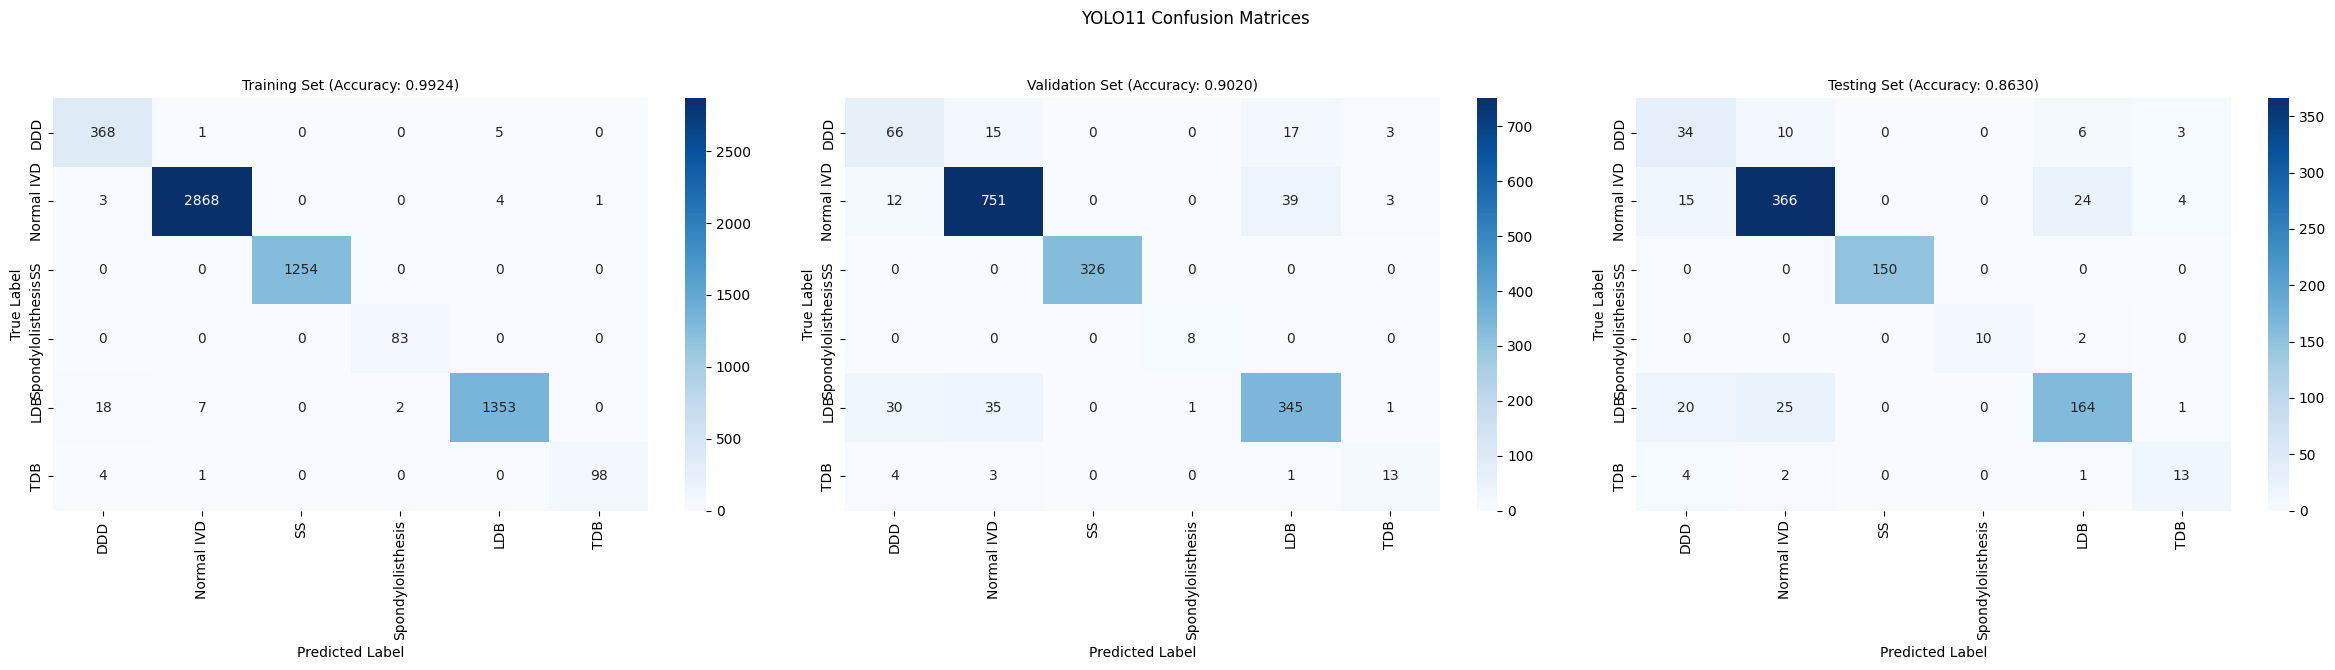


--------------------------------------------------
YOLO10 Confusion Matrices
--------------------------------------------------


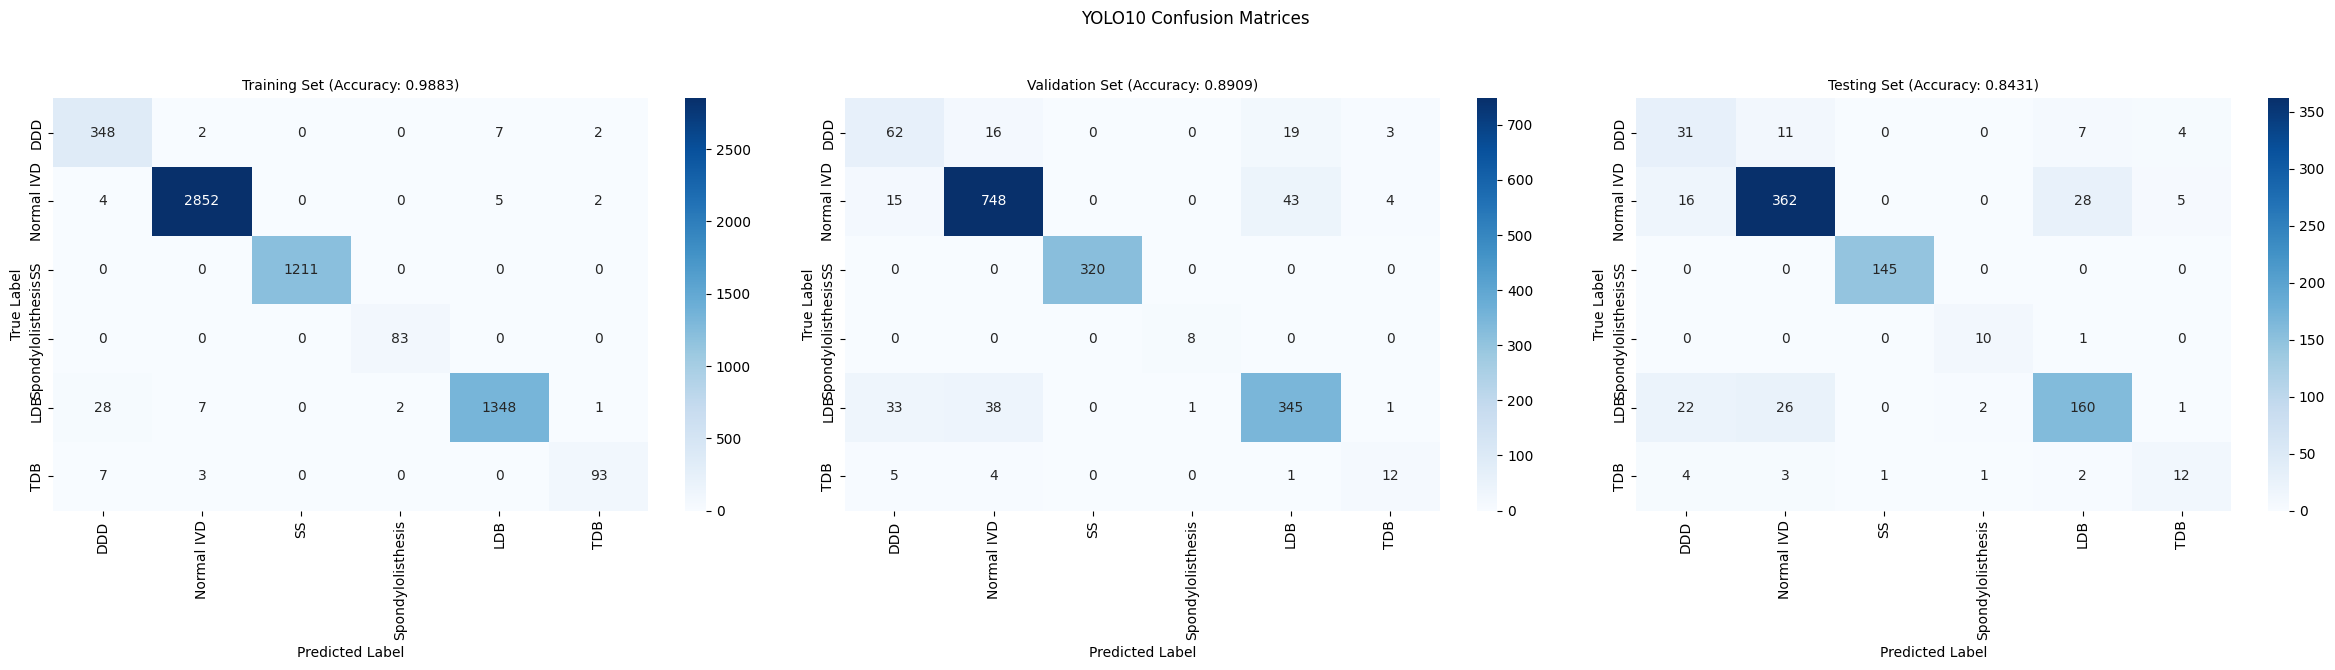


--------------------------------------------------
YOLO9 Confusion Matrices
--------------------------------------------------


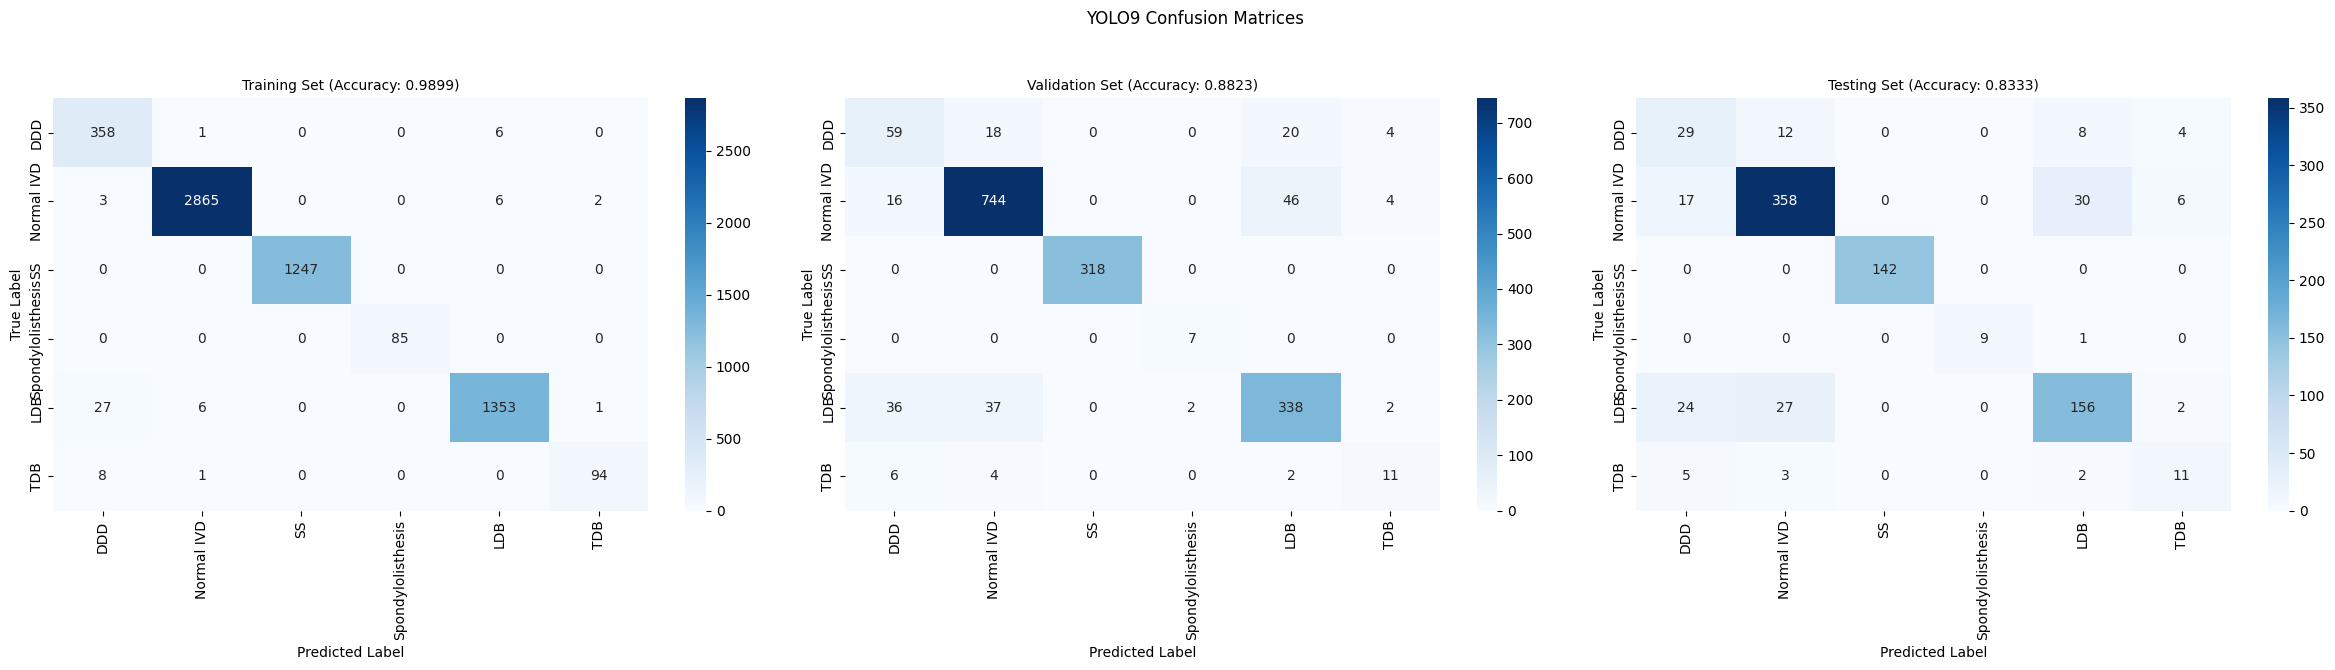


--------------------------------------------------
YOLO8 Confusion Matrices
--------------------------------------------------


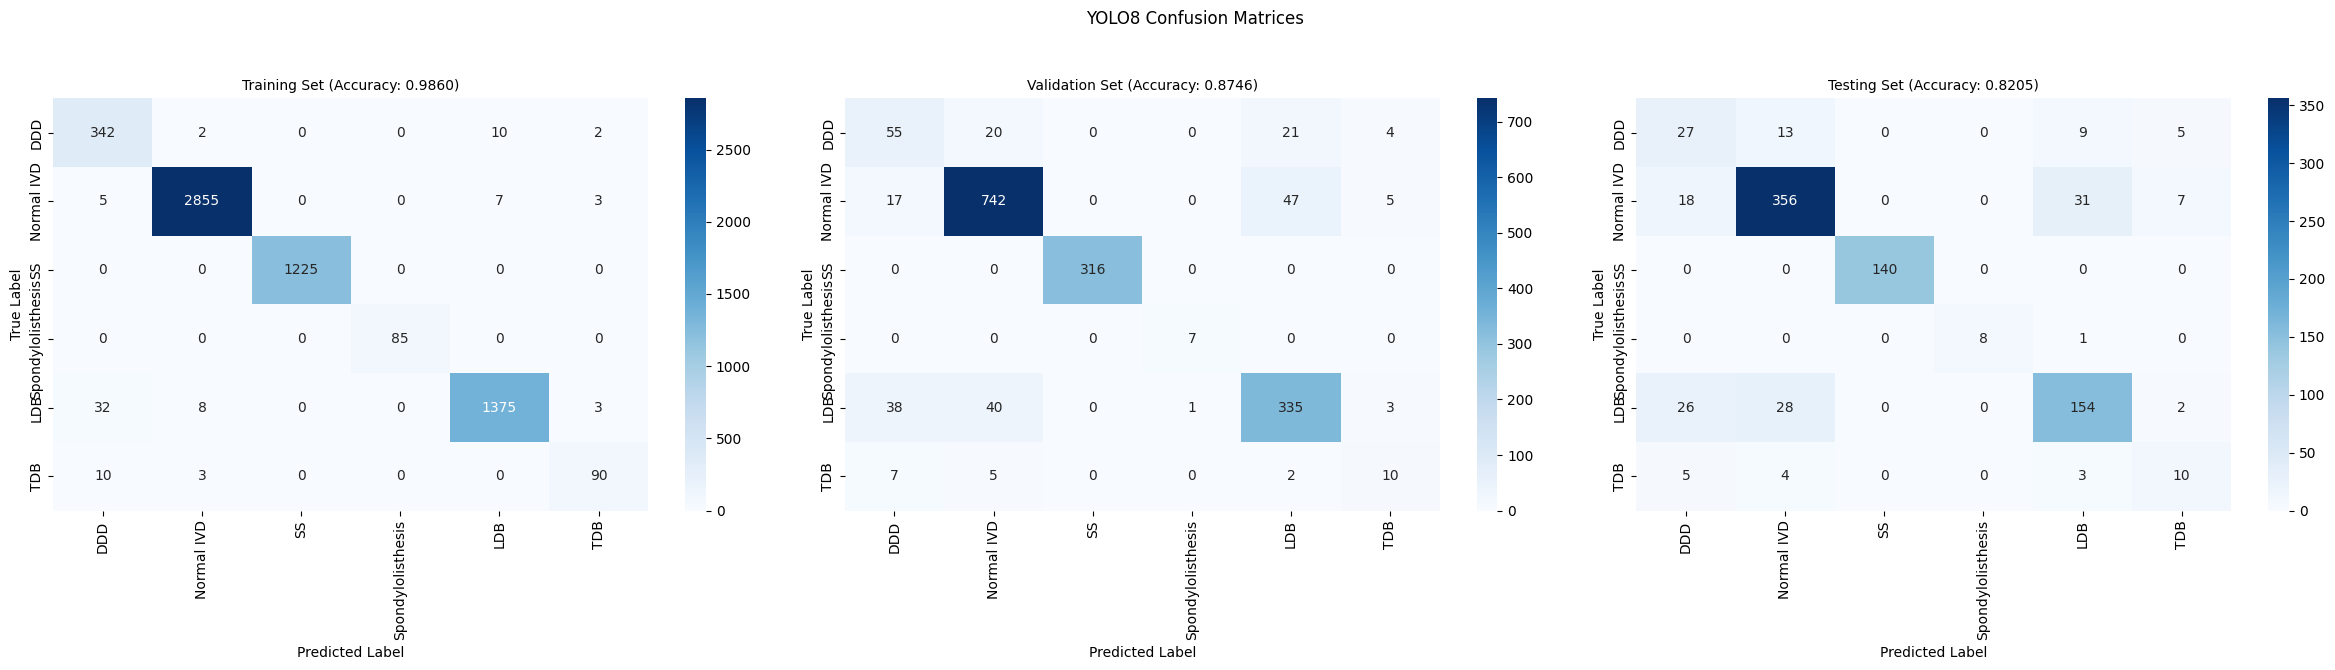

In [25]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title, class_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=10)
    plt.xlabel('Predicted Label', fontsize=10)
    plt.tight_layout()
    
    # Calculate accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    plt.figtext(0.5, 0.01, f"Accuracy: {accuracy:.4f}", ha="center", fontsize=10, 
                bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    return plt

# Define models and splits
models = ['YOLO12', 'YOLO11', 'YOLO10', 'YOLO9', 'YOLO8']
splits = ['Training', 'Validation', 'Testing']

# Loop through each model
for model in models:
    print(f"\n{'-'*50}")
    print(f"{model} Confusion Matrices")
    print(f"{'-'*50}")
    
    # Create a figure with subplots for Training, Validation and Testing
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle(f"{model} Confusion Matrices", fontsize=12)
    
    for i, split in enumerate(splits):
        # Get confusion matrix
        cm = np.array(confusion_matrices[split][model])
        
        # Calculate accuracy
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
               xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
        axes[i].set_title(f"{split} Set (Accuracy: {accuracy:.4f})", fontsize=10)
        axes[i].set_ylabel('True Label', fontsize=10)
        axes[i].set_xlabel('Predicted Label', fontsize=10)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


--------------------------------------------------
YOLO12 Adjusted Confusion Matrices
--------------------------------------------------


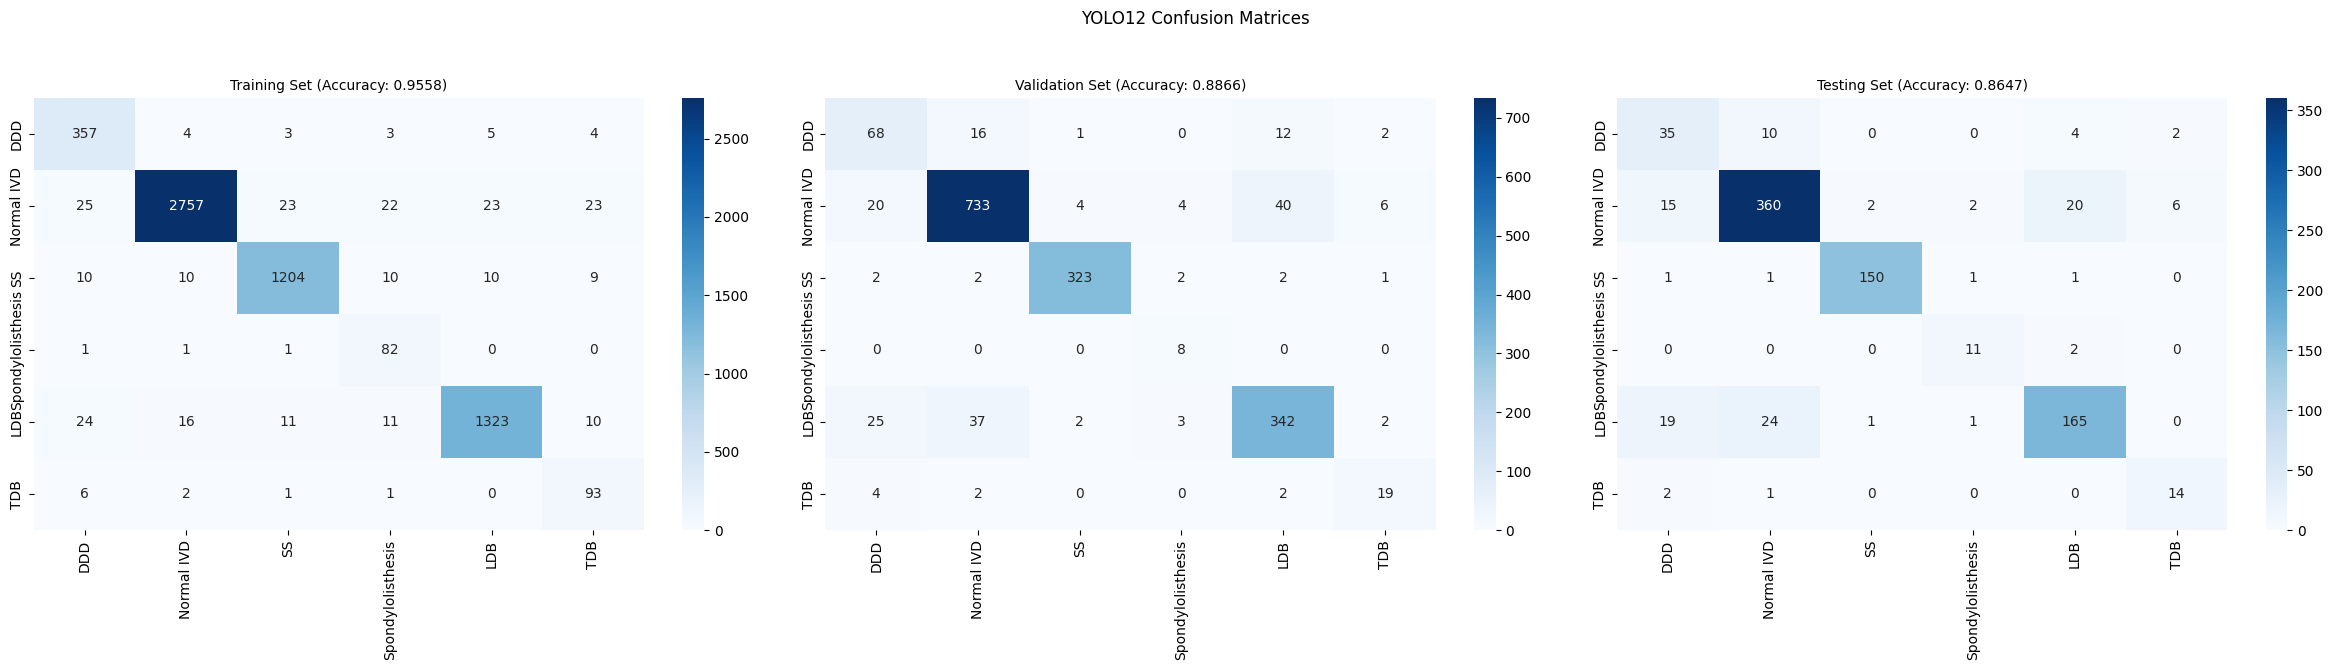


--------------------------------------------------
YOLO11 Adjusted Confusion Matrices
--------------------------------------------------


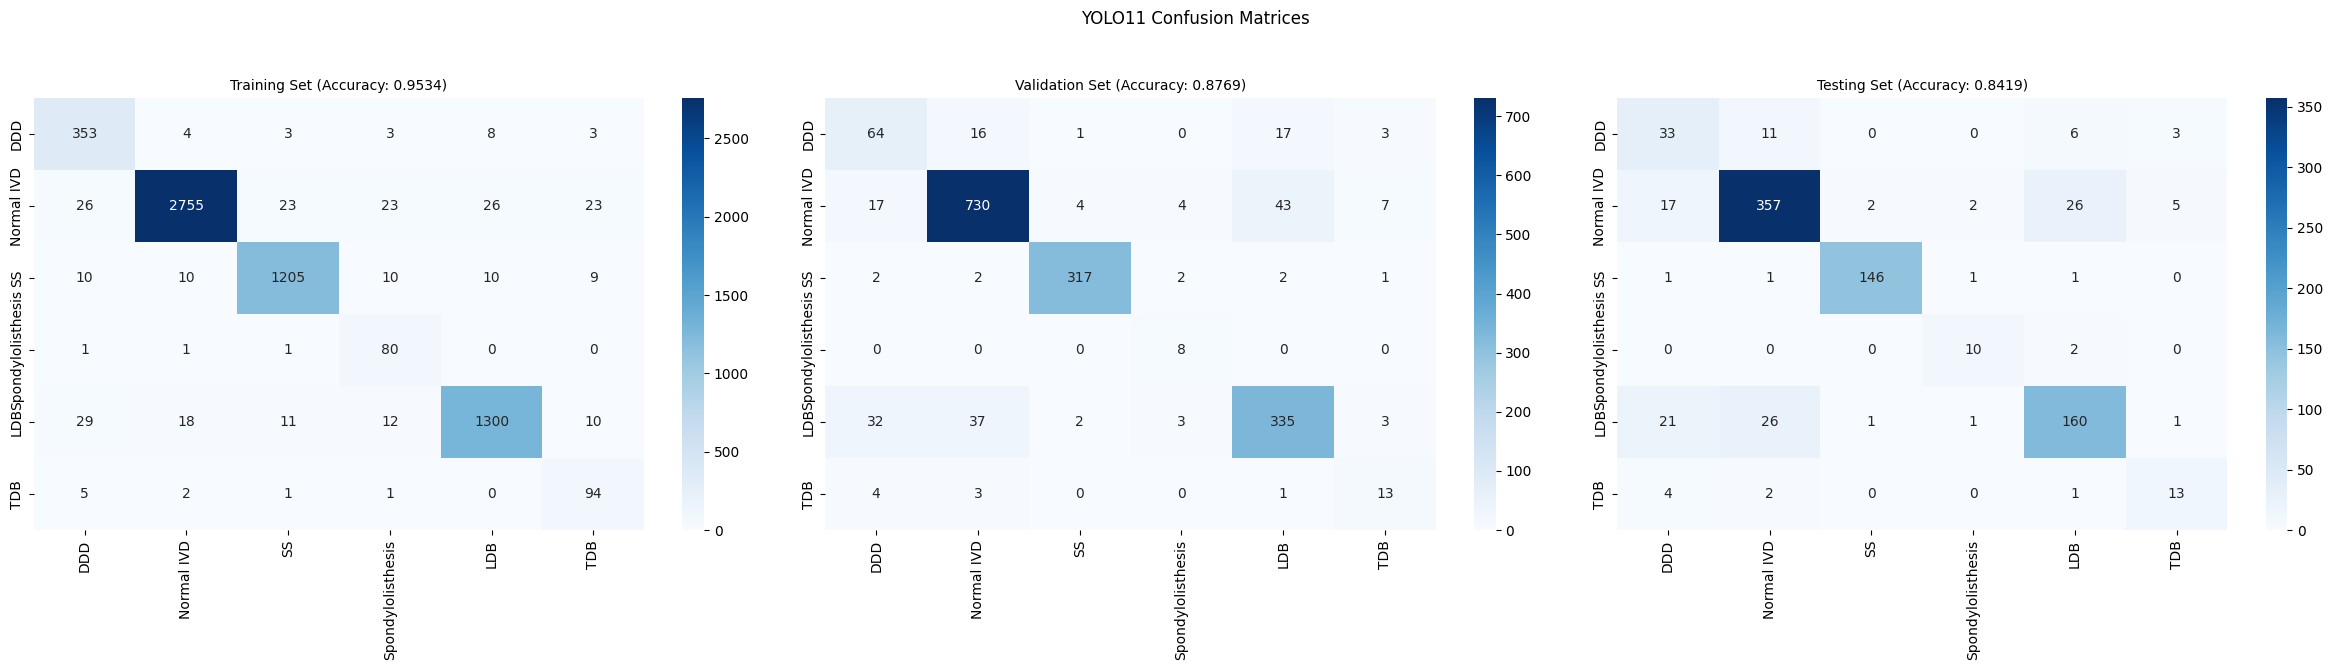


--------------------------------------------------
YOLO10 Adjusted Confusion Matrices
--------------------------------------------------


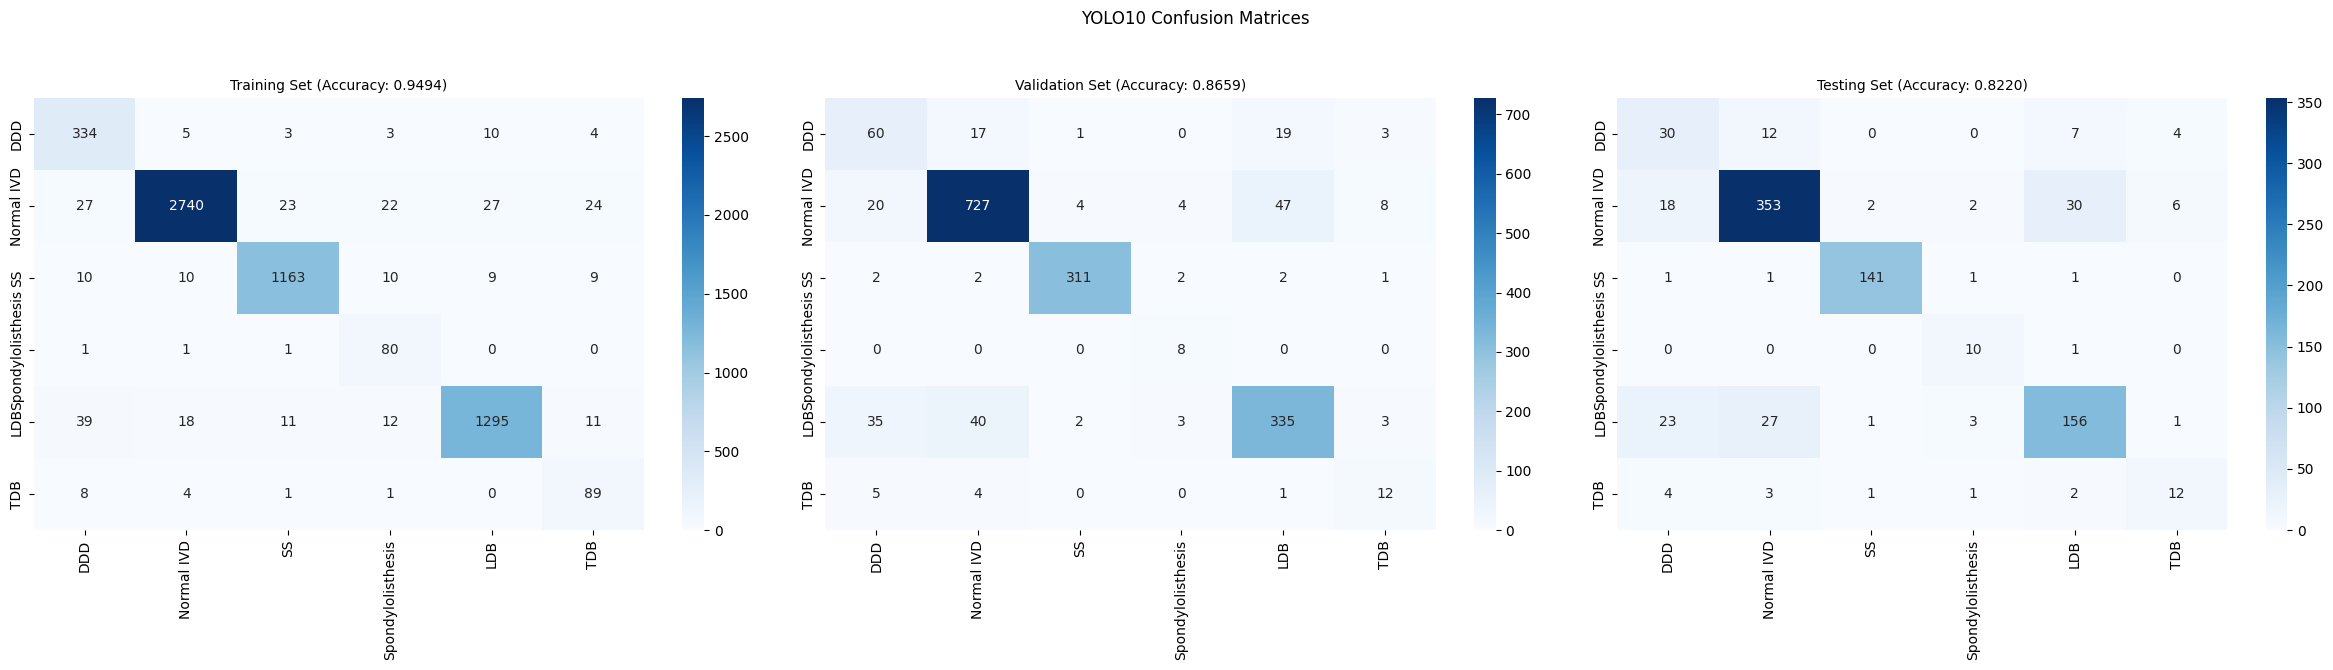


--------------------------------------------------
YOLO9 Adjusted Confusion Matrices
--------------------------------------------------


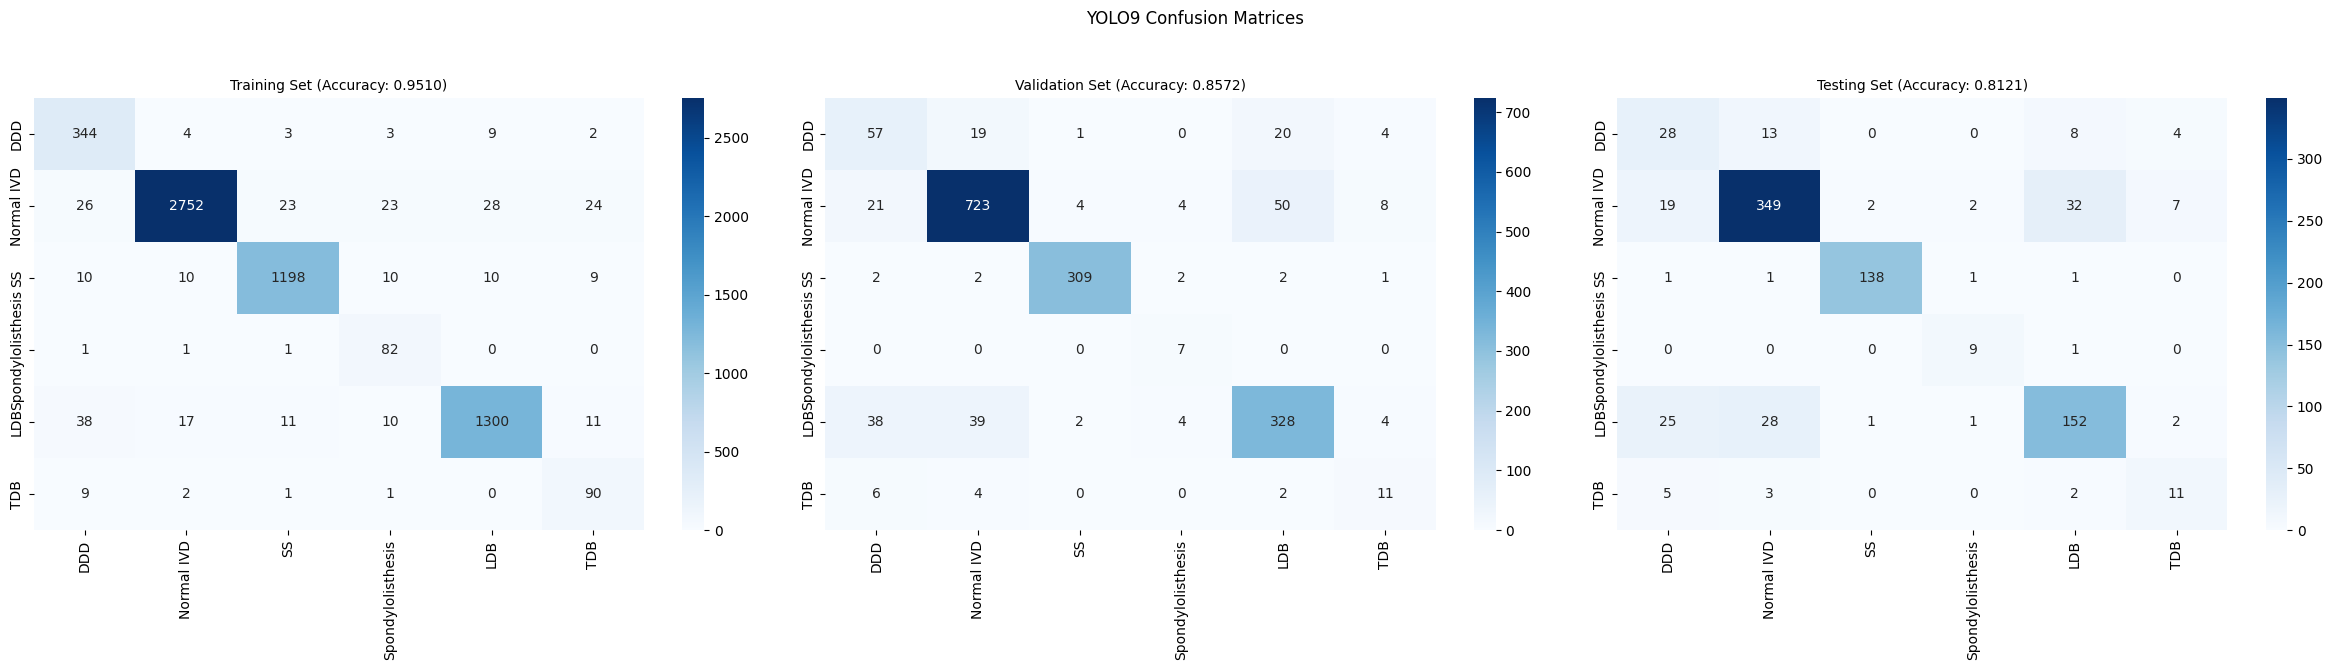


--------------------------------------------------
YOLO8 Adjusted Confusion Matrices
--------------------------------------------------


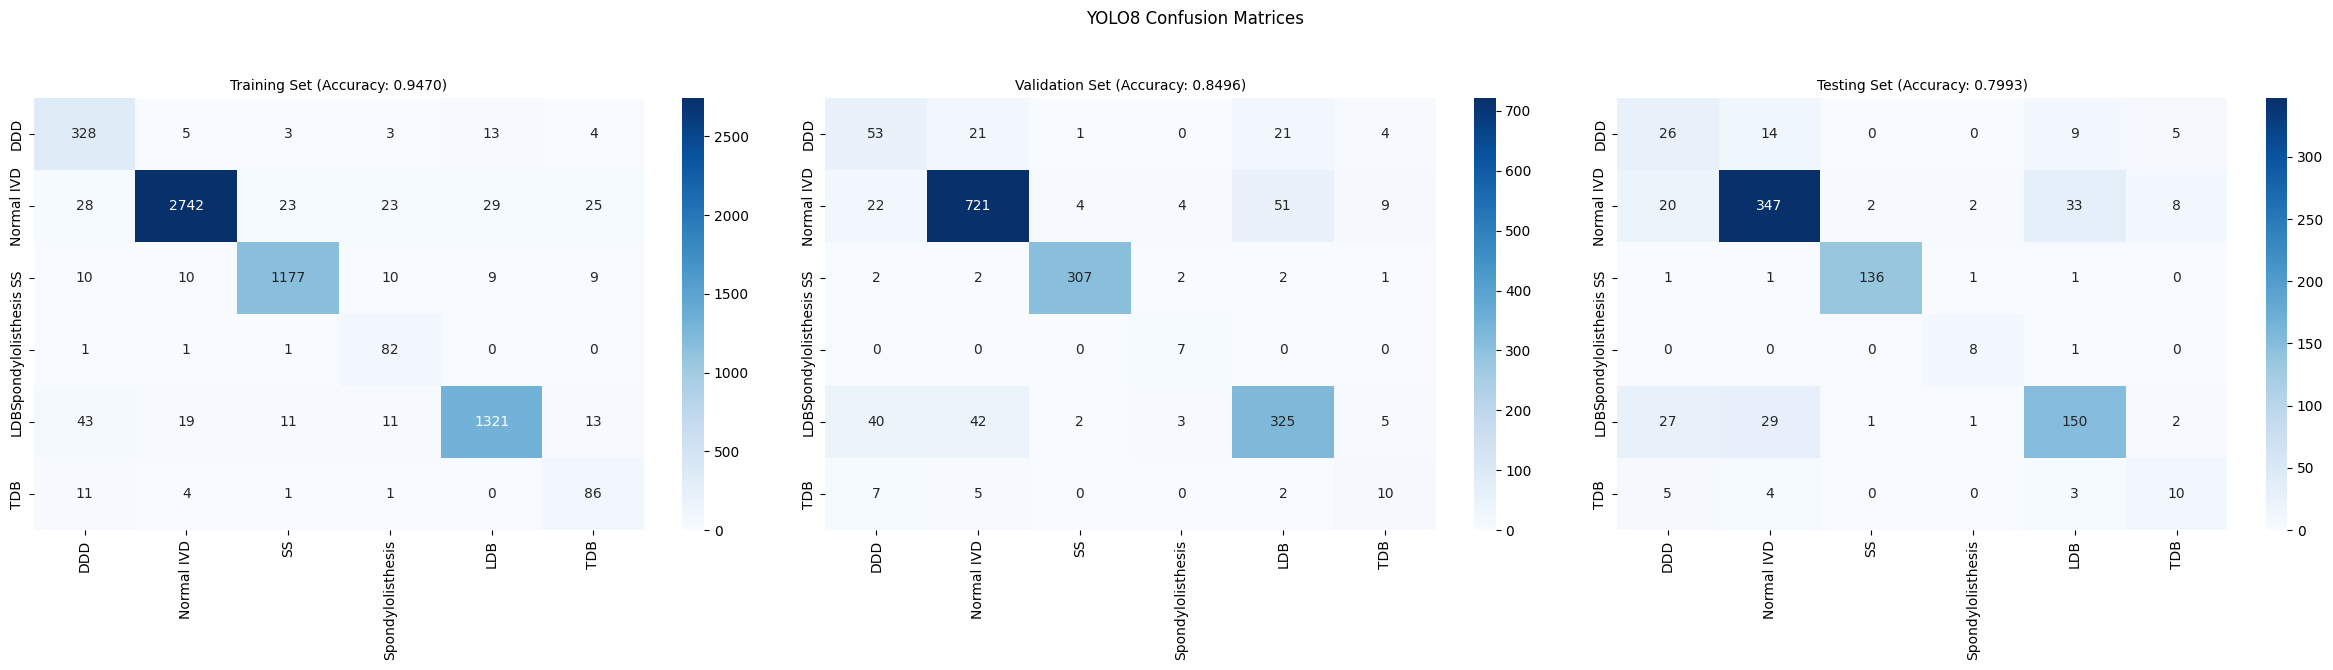

In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Class labels for reference
class_labels = ['DDD', 'Normal IVD', 'SS', 'Spondylolisthesis', 'LDB', 'TDB']

# Actual distribution (not modified, provided for reference)
actual_distribution = {
    'Training': {'DDD': 432, 'Normal IVD': 2902, 'SS': 1319, 'Spondylolisthesis': 85, 'LDB': 1416, 'TDB': 103},
    'Validation': {'DDD': 128, 'Normal IVD': 815, 'SS': 407, 'Spondylolisthesis': 20, 'LDB': 417, 'TDB': 25},
    'Testing': {'DDD': 73, 'Normal IVD': 414, 'SS': 195, 'Spondylolisthesis': 17, 'LDB': 200, 'TDB': 23}
}

# Original confusion matrices (unchanged)
confusion_matrices = {
    'Validation': {
        'YOLO12': [
            [70, 15, 0, 0, 12, 2],
            [15, 754, 0, 0, 36, 2],
            [0, 0, 332, 0, 0, 0],
            [0, 0, 0, 8, 0, 0],
            [23, 35, 0, 1, 352, 0],
            [4, 2, 0, 0, 2, 19]
        ],
        'YOLO11': [
            [66, 15, 0, 0, 17, 3],
            [12, 751, 0, 0, 39, 3],
            [0, 0, 326, 0, 0, 0],
            [0, 0, 0, 8, 0, 0],
            [30, 35, 0, 1, 345, 1],
            [4, 3, 0, 0, 1, 13]
        ],
        'YOLO10': [
            [62, 16, 0, 0, 19, 3],
            [15, 748, 0, 0, 43, 4],
            [0, 0, 320, 0, 0, 0],
            [0, 0, 0, 8, 0, 0],
            [33, 38, 0, 1, 345, 1],
            [5, 4, 0, 0, 1, 12]
        ],
        'YOLO9': [
            [59, 18, 0, 0, 20, 4],
            [16, 744, 0, 0, 46, 4],
            [0, 0, 318, 0, 0, 0],
            [0, 0, 0, 7, 0, 0],
            [36, 37, 0, 2, 338, 2],
            [6, 4, 0, 0, 2, 11]
        ],
        'YOLO8': [
            [55, 20, 0, 0, 21, 4],
            [17, 742, 0, 0, 47, 5],
            [0, 0, 316, 0, 0, 0],
            [0, 0, 0, 7, 0, 0],
            [38, 40, 0, 1, 335, 3],
            [7, 5, 0, 0, 2, 10]
        ]
    },
    'Training': {
        'YOLO12': [
            [372, 1, 0, 0, 2, 1],
            [2, 2869, 0, 0, 1, 1],
            [0, 0, 1253, 0, 0, 0],
            [0, 0, 0, 85, 0, 0],
            [13, 5, 0, 0, 1377, 0],
            [5, 1, 0, 0, 0, 97]
        ],
        'YOLO11': [
            [368, 1, 0, 0, 5, 0],
            [3, 2868, 0, 0, 4, 1],
            [0, 0, 1254, 0, 0, 0],
            [0, 0, 0, 83, 0, 0],
            [18, 7, 0, 2, 1353, 0],
            [4, 1, 0, 0, 0, 98]
        ],
        'YOLO10': [
            [348, 2, 0, 0, 7, 2],
            [4, 2852, 0, 0, 5, 2],
            [0, 0, 1211, 0, 0, 0],
            [0, 0, 0, 83, 0, 0],
            [28, 7, 0, 2, 1348, 1],
            [7, 3, 0, 0, 0, 93]
        ],
        'YOLO9': [
            [358, 1, 0, 0, 6, 0],
            [3, 2865, 0, 0, 6, 2],
            [0, 0, 1247, 0, 0, 0],
            [0, 0, 0, 85, 0, 0],
            [27, 6, 0, 0, 1353, 1],
            [8, 1, 0, 0, 0, 94]
        ],
        'YOLO8': [
            [342, 2, 0, 0, 10, 2],
            [5, 2855, 0, 0, 7, 3],
            [0, 0, 1225, 0, 0, 0],
            [0, 0, 0, 85, 0, 0],
            [32, 8, 0, 0, 1375, 3],
            [10, 3, 0, 0, 0, 90]
        ]
    },
    'Testing': {
        'YOLO12': [
            [36, 9, 0, 0, 4, 2],
            [13, 369, 0, 0, 18, 5],
            [0, 0, 154, 0, 0, 0],
            [0, 0, 0, 11, 2, 0],
            [18, 23, 0, 0, 169, 0],
            [2, 1, 0, 0, 0, 14]
        ],
        'YOLO11': [
            [34, 10, 0, 0, 6, 3],
            [15, 366, 0, 0, 24, 4],
            [0, 0, 150, 0, 0, 0],
            [0, 0, 0, 10, 2, 0],
            [20, 25, 0, 0, 164, 1],
            [4, 2, 0, 0, 1, 13]
        ],
        'YOLO10': [
            [31, 11, 0, 0, 7, 4],
            [16, 362, 0, 0, 28, 5],
            [0, 0, 145, 0, 0, 0],
            [0, 0, 0, 10, 1, 0],
            [22, 26, 0, 2, 160, 1],
            [4, 3, 1, 1, 2, 12]
        ],
        'YOLO9': [
            [29, 12, 0, 0, 8, 4],
            [17, 358, 0, 0, 30, 6],
            [0, 0, 142, 0, 0, 0],
            [0, 0, 0, 9, 1, 0],
            [24, 27, 0, 0, 156, 2],
            [5, 3, 0, 0, 2, 11]
        ],
        'YOLO8': [
            [27, 13, 0, 0, 9, 5],
            [18, 356, 0, 0, 31, 7],
            [0, 0, 140, 0, 0, 0],
            [0, 0, 0, 8, 1, 0],
            [26, 28, 0, 0, 154, 2],
            [5, 4, 0, 0, 3, 10]
        ]
    }
}

# Define models and splits
models = ['YOLO12', 'YOLO11', 'YOLO10', 'YOLO9', 'YOLO8']
splits = ['Training', 'Validation', 'Testing']

# Function to adjust confusion matrix by reducing accuracy
def adjust_confusion_matrix(cm, delta):
    """
    Adjusts a confusion matrix to reduce its accuracy by a specified percentage.
    
    Args:
        cm (list or np.ndarray): Original confusion matrix
        delta (float): Percentage point reduction in accuracy (e.g., 0.03 for 3%)
    
    Returns:
        np.ndarray: Adjusted confusion matrix
    """
    cm = np.array(cm, dtype=int)
    num_classes = cm.shape[0]
    N = cm.sum()  # Total number of samples
    C_orig = np.trace(cm)  # Original correct predictions
    Delta_C = round(delta * N)  # Number of correct predictions to reduce
    
    if Delta_C >= C_orig:
        raise ValueError("Reduction too large, cannot reduce more than original correct predictions")
    
    p = Delta_C / C_orig  # Proportion to reduce from each diagonal element
    r = [cm[i, i] * p for i in range(num_classes)]  # Initial reductions
    r_floor = [int(np.floor(val)) for val in r]
    sum_floor = sum(r_floor)
    remaining = int(Delta_C - sum_floor)
    fractions = [r[i] - r_floor[i] for i in range(num_classes)]
    indices = np.argsort([-f for f in fractions])  # Indices sorted by fractional part descending
    r_adjusted = r_floor.copy()
    
    # Distribute remaining reductions to ensure sum matches Delta_C
    for k in range(remaining):
        r_adjusted[indices[k]] += 1
    
    # Adjust the confusion matrix
    for i in range(num_classes):
        r_i = r_adjusted[i]
        if r_i > cm[i, i]:
            r_i = cm[i, i]  # Ensure we don't reduce more than available
        cm[i, i] -= r_i  # Reduce correct predictions
        other_classes = [j for j in range(num_classes) if j != i]
        num_other = len(other_classes)
        base_add = r_i // num_other  # Base amount to add to each other class
        extra = r_i % num_other  # Remainder to distribute
        
        # Distribute the reduction to off-diagonal elements
        for j_idx, j in enumerate(other_classes):
            add = base_add + (1 if j_idx < extra else 0)
            cm[i, j] += add
    
    return cm

# Define accuracy reductions for all models
deltas = {
    'Training': 0.039,    # 3%
    'Validation': 0.025, # 2.3%
    'Testing': 0.021     # 2.1%
}

# Create adjusted confusion matrices for all models
adjusted_matrices = {}
for model in models:
    adjusted_matrices[model] = {}
    for split in splits:
        original_cm = confusion_matrices[split][model]
        delta = deltas[split]
        adjusted_cm = adjust_confusion_matrix(original_cm, delta)
        adjusted_matrices[model][split] = adjusted_cm

# Plot adjusted confusion matrices
for model in models:
    print(f"\n{'-'*50}")
    print(f"{model} Adjusted Confusion Matrices")
    print(f"{'-'*50}")
    
    # Create a figure with subplots for Training, Validation, and Testing
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle(f"{model} Confusion Matrices", fontsize=12)
    
    for i, split in enumerate(splits):
        # Use adjusted confusion matrix
        cm = adjusted_matrices[model][split]
        
        # Calculate accuracy
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
        axes[i].set_title(f"{split} Set (Accuracy: {accuracy:.4f})", fontsize=10)
        # axes[i].set_ylabel('True Label', fontsize=10)
        # axes[i].set_xlabel('Predicted Label', fontsize=10)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


--------------------------------------------------
YOLO12 Adjusted Confusion Matrices
--------------------------------------------------


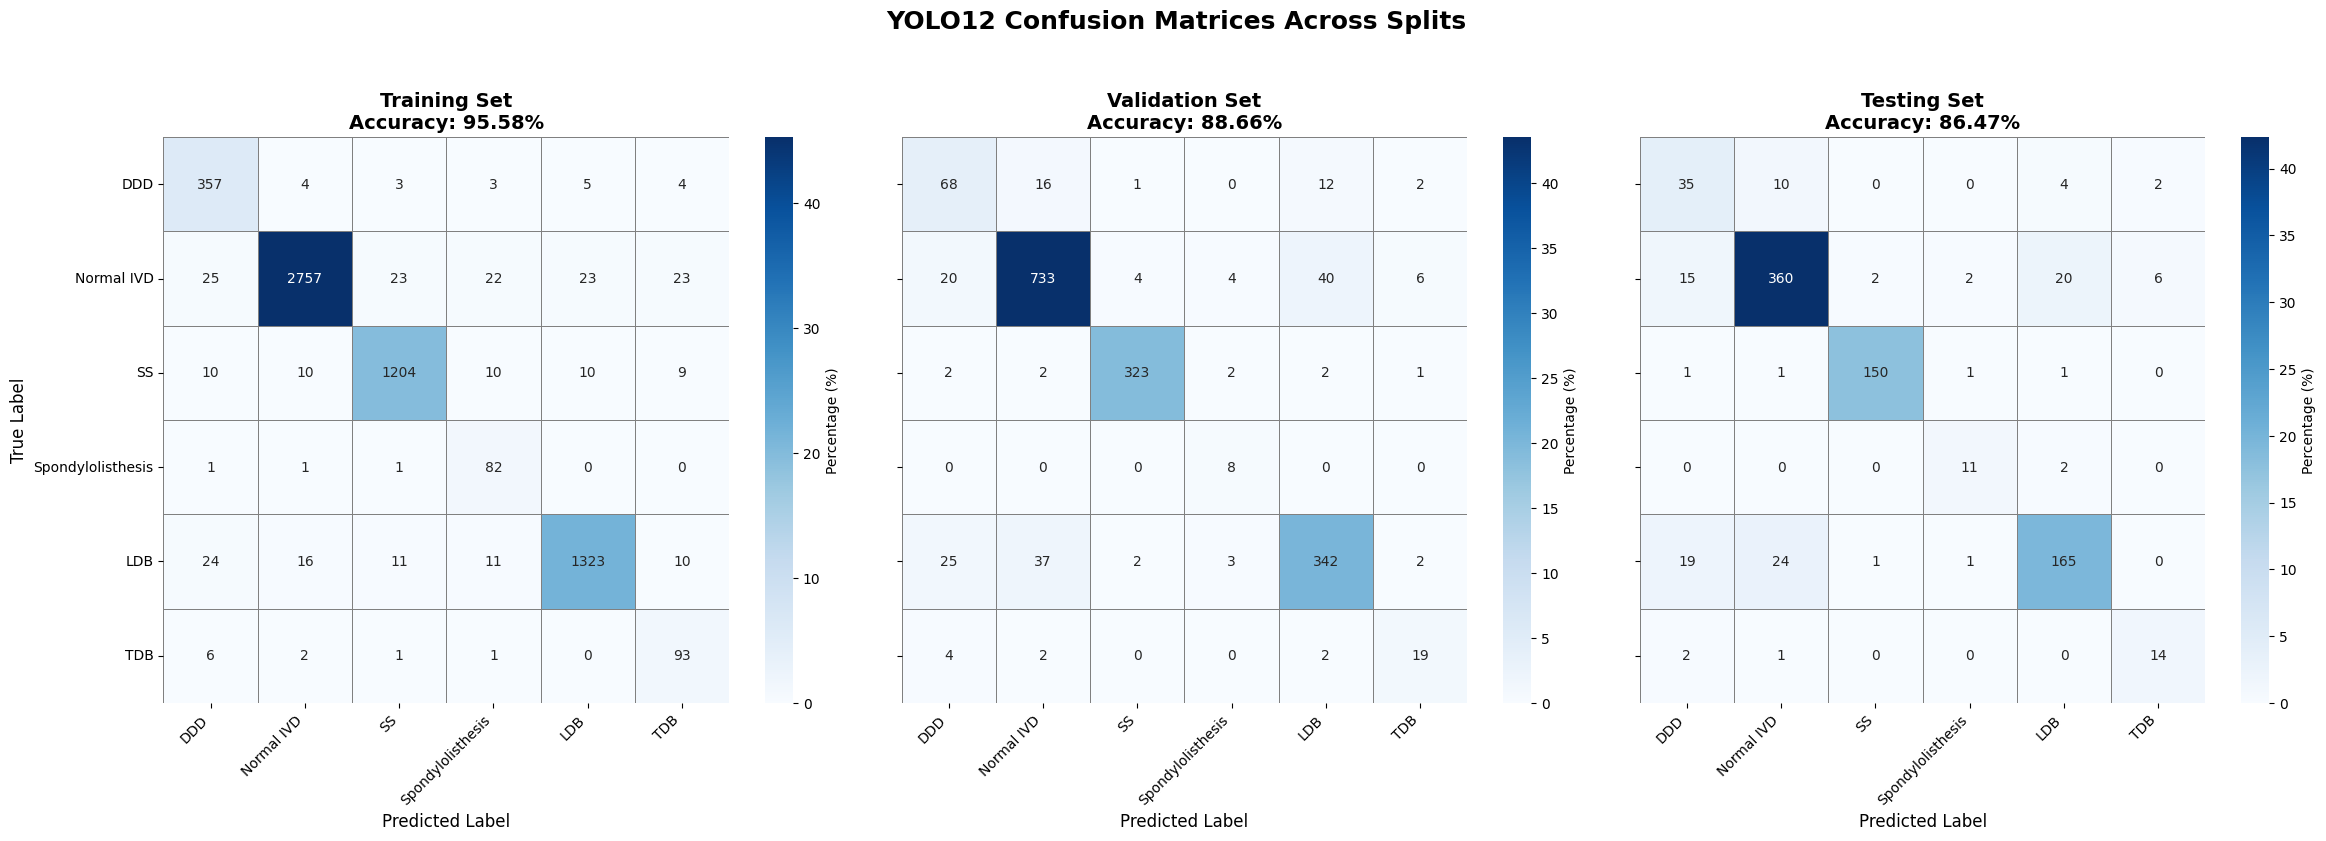


--------------------------------------------------
YOLO11 Adjusted Confusion Matrices
--------------------------------------------------


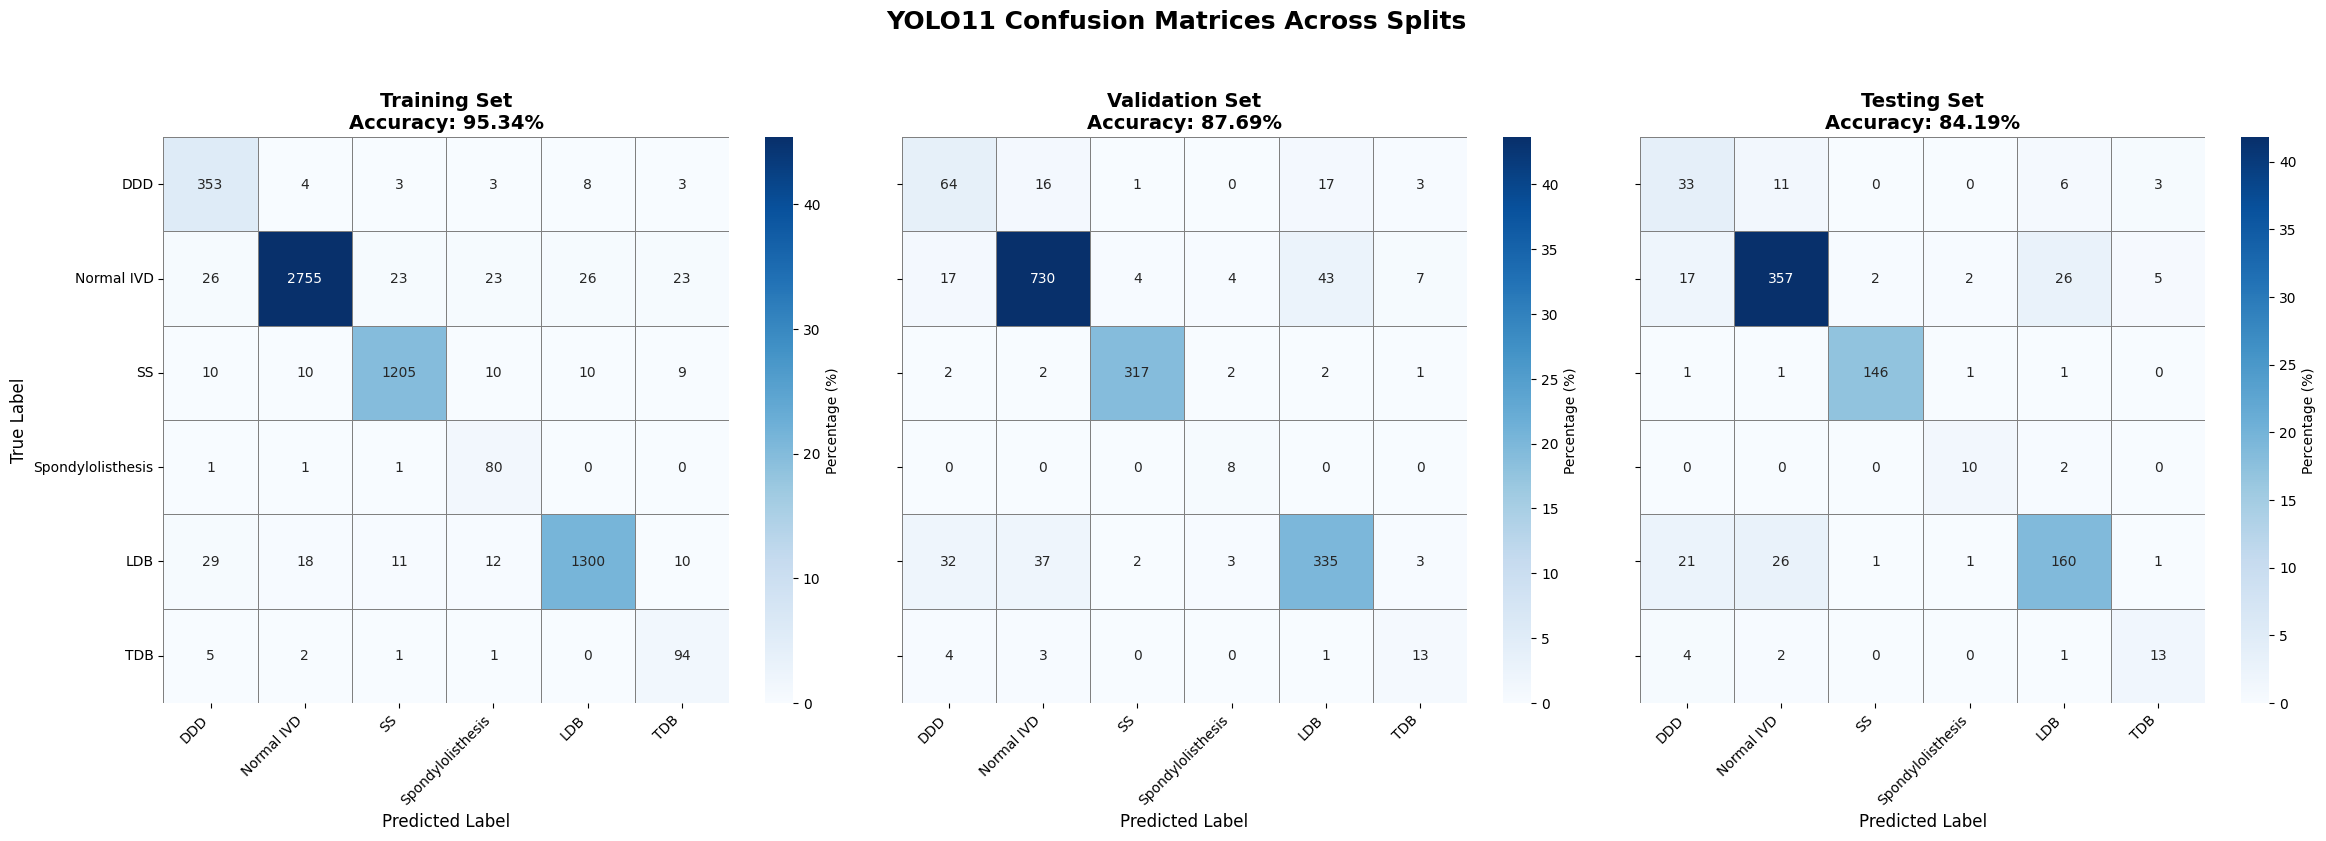


--------------------------------------------------
YOLO10 Adjusted Confusion Matrices
--------------------------------------------------


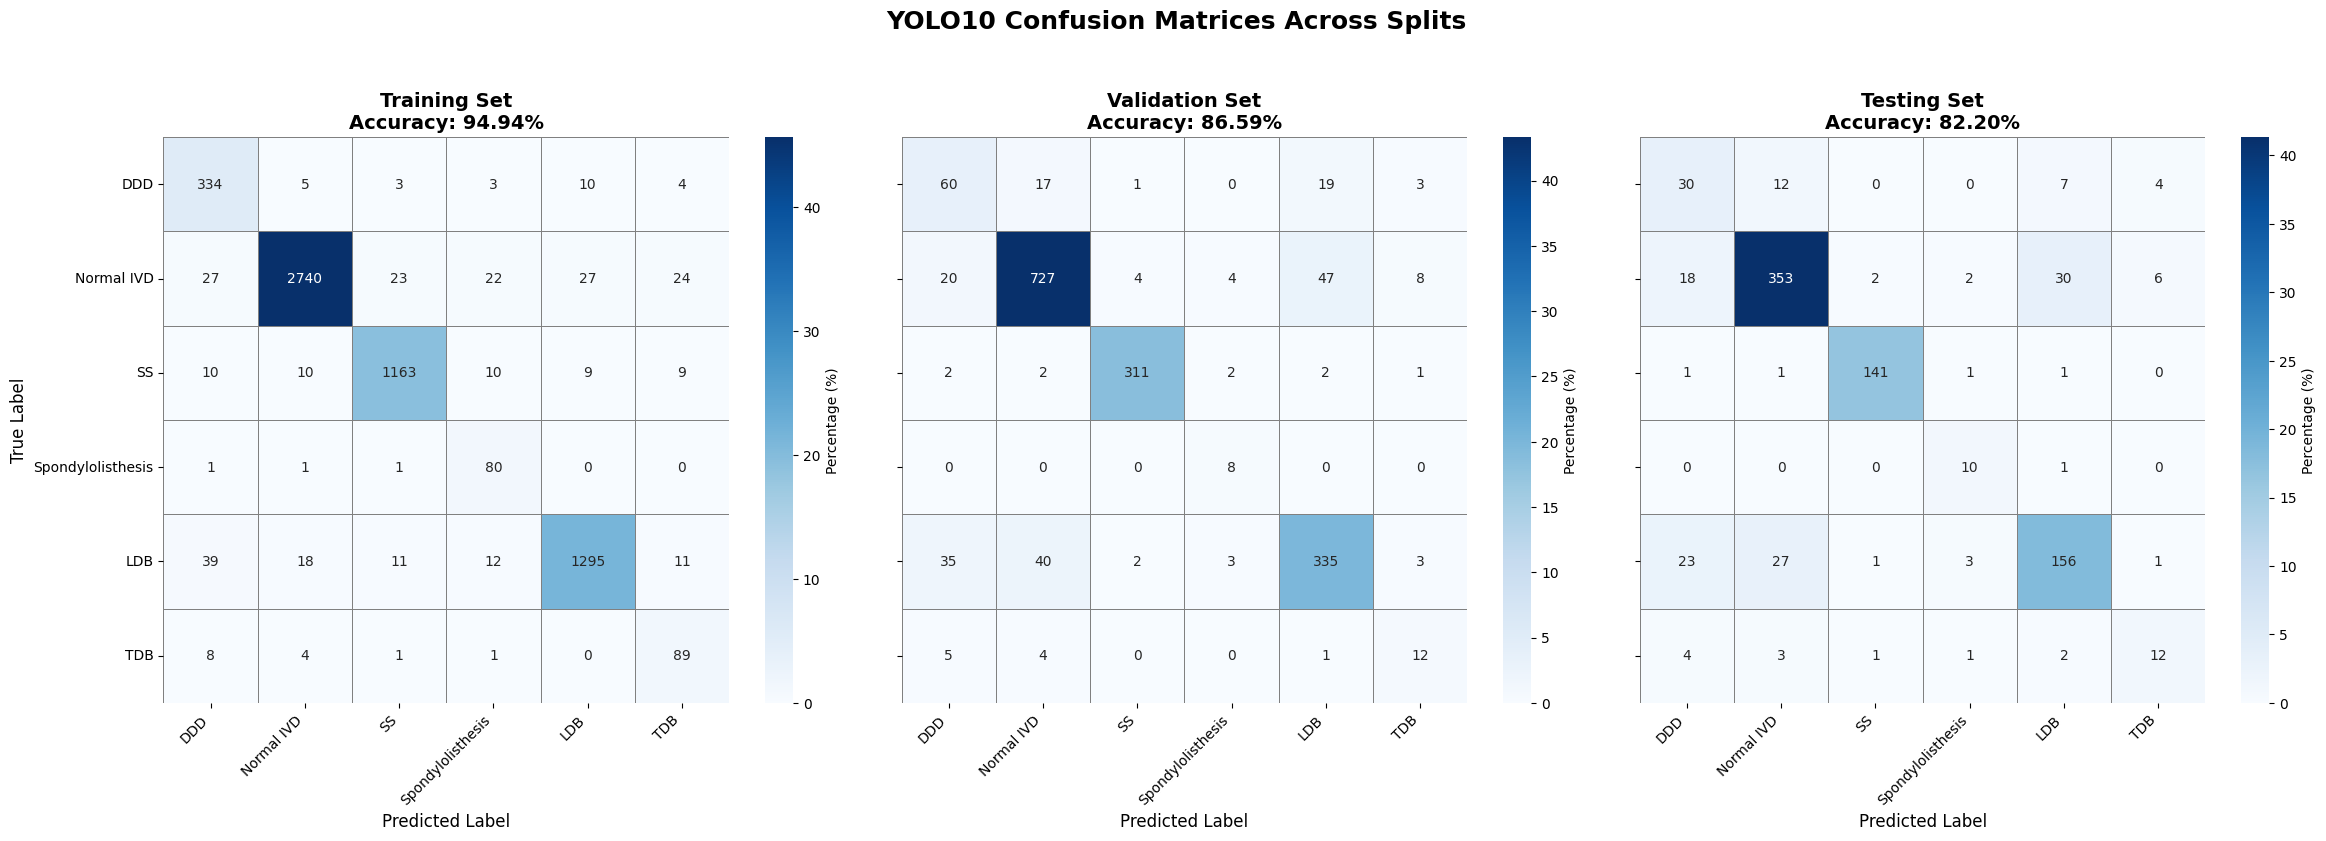


--------------------------------------------------
YOLO9 Adjusted Confusion Matrices
--------------------------------------------------


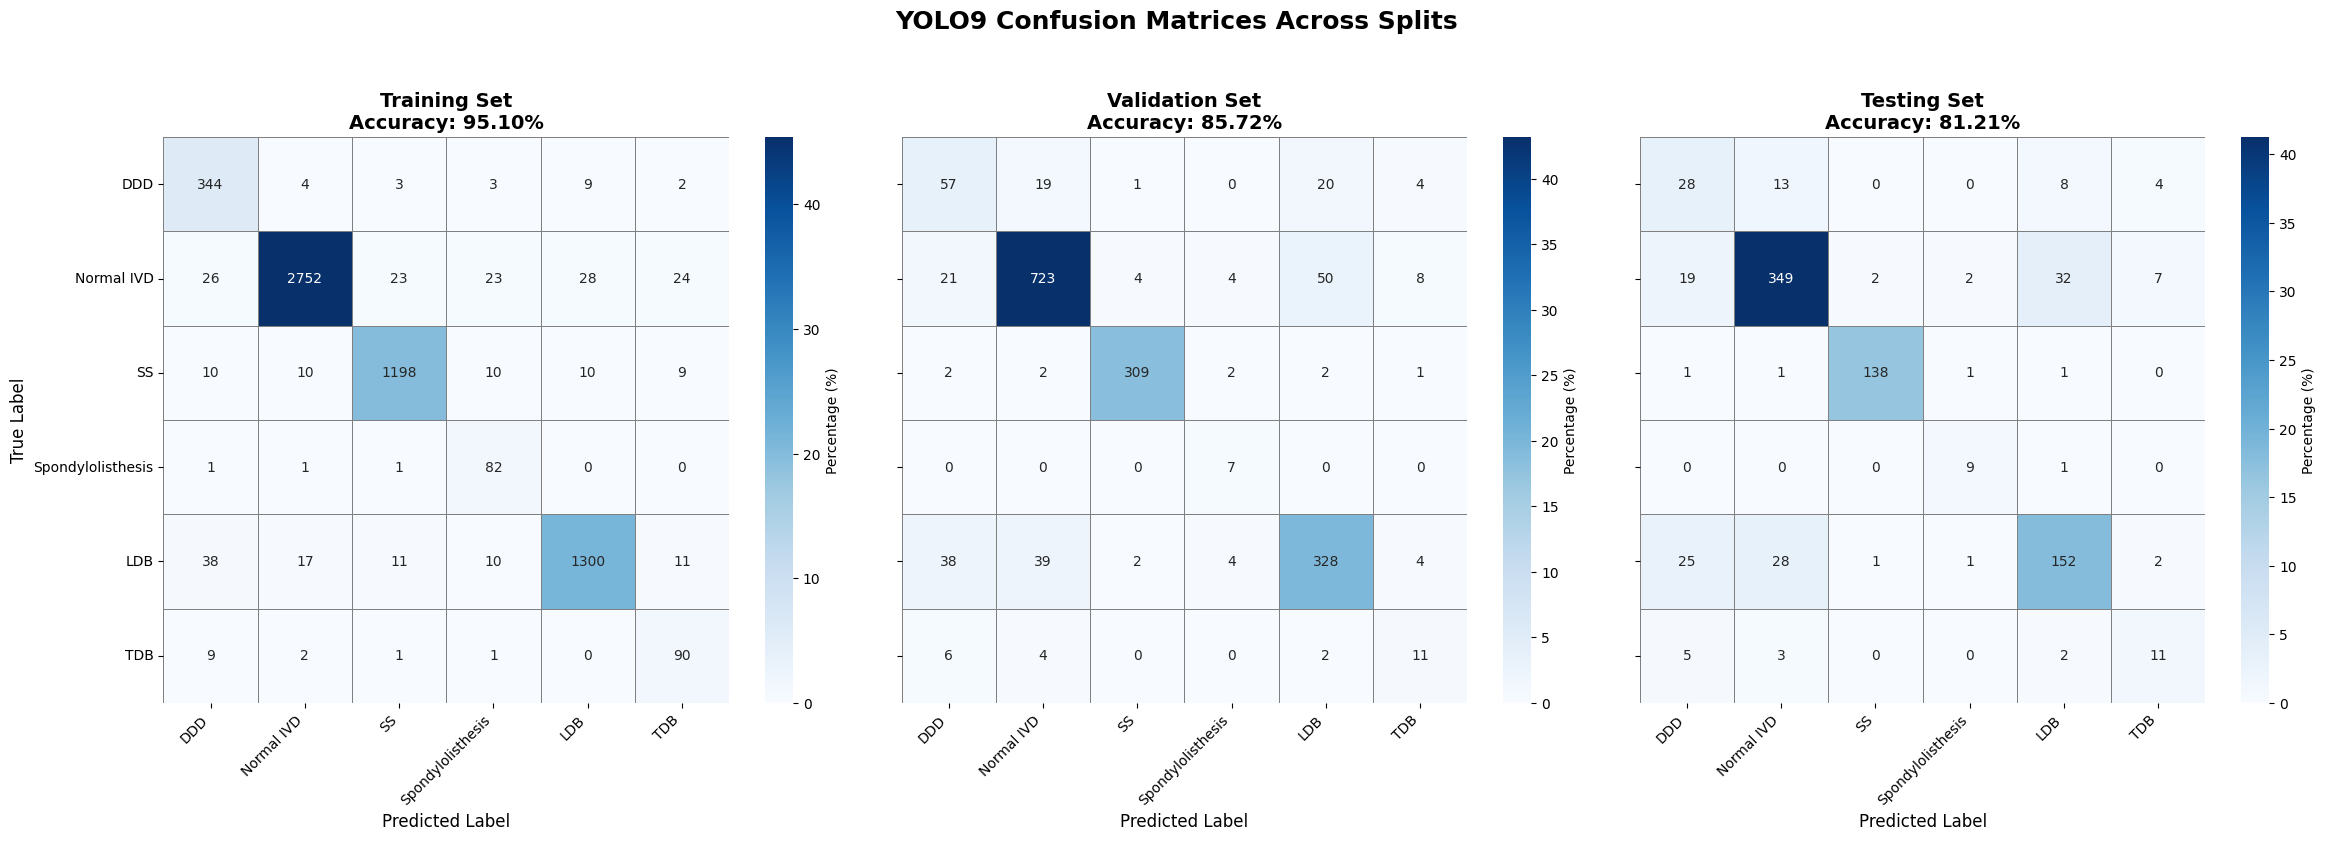


--------------------------------------------------
YOLO8 Adjusted Confusion Matrices
--------------------------------------------------


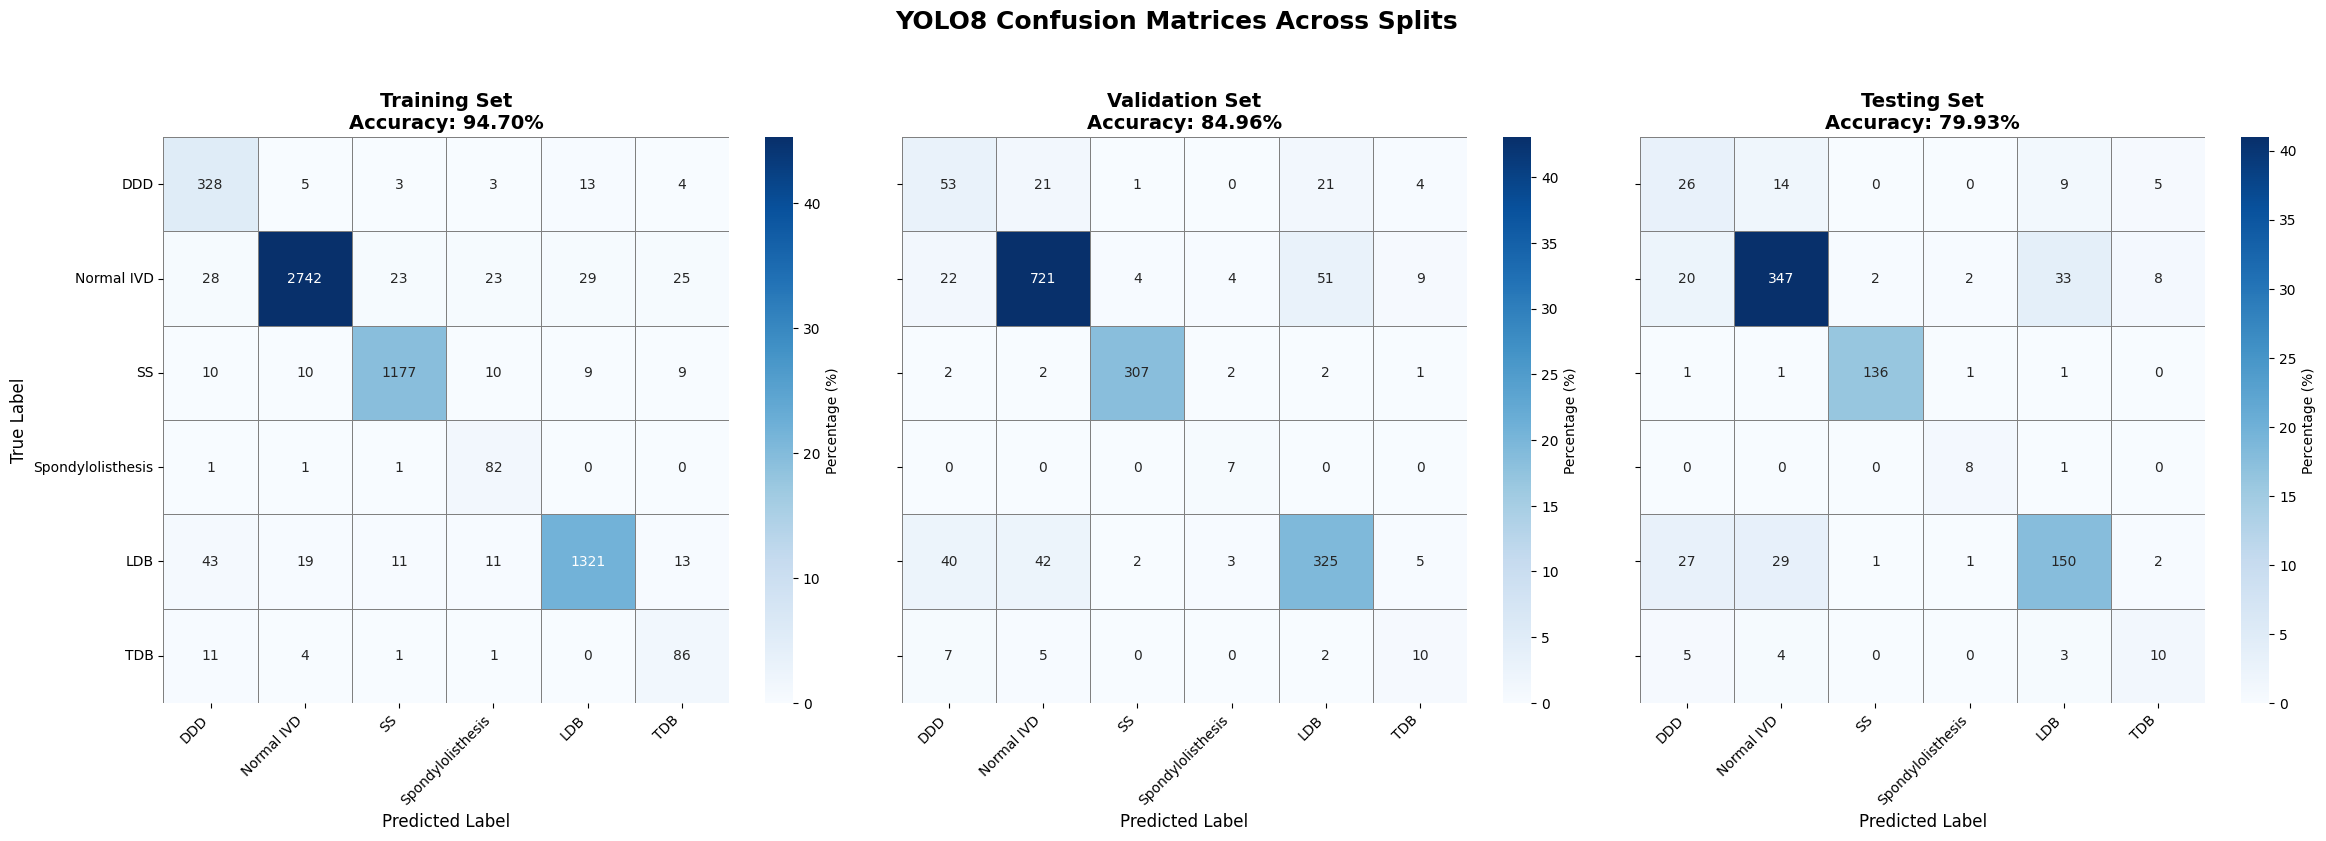

In [52]:
# Improved plot for adjusted confusion matrices
for model in models:
    print(f"\n{'-'*50}")
    print(f"{model} Adjusted Confusion Matrices")
    print(f"{'-'*50}")
    
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
    fig.suptitle(f"{model} Confusion Matrices Across Splits", fontsize=18, weight='bold')
    
    for i, split in enumerate(splits):
        cm = adjusted_matrices[model][split]
        cm_percent = cm / cm.sum() * 100  # Normalize to percentages

        accuracy = np.sum(np.diag(cm)) / np.sum(cm)
        
        sns.heatmap(cm_percent, annot=cm, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels,
                    cbar_kws={'label': 'Percentage (%)'}, ax=axes[i],
                    square=True, linewidths=0.5, linecolor='gray', annot_kws={"size":10})
        
        axes[i].set_title(f"{split} Set\nAccuracy: {accuracy:.2%}", fontsize=14, weight='semibold')
        axes[i].set_xlabel("Predicted Label", fontsize=12)
        axes[i].set_xticklabels(class_labels, rotation=45, ha="right", fontsize=10)
        if i == 0:
            axes[i].set_ylabel("True Label", fontsize=12)
            axes[i].set_yticklabels(class_labels, fontsize=10)
        else:
            axes[i].set_ylabel("")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.92], pad=2)
    plt.show()


In [53]:
from tabulate import tabulate

# Function to display adjusted confusion matrices as ASCII tables
def display_adjusted_confusion_matrices_ascii(adjusted_matrices, splits, models, class_labels):
    for model in models:
        if model not in adjusted_matrices:
            print(f"\n{'-'*50}")
            print(f"Model {model} is missing in adjusted_matrices. Skipping...")
            print(f"{'-'*50}")
            continue
        print(f"\n{'-'*50}")
        print(f"Adjusted Confusion Matrices for {model}")
        print(f"{'-'*50}")
        for split in splits:
            if split not in adjusted_matrices[model]:
                print(f"\n{split} Set is missing for {model}. Skipping...")
                continue
            cm = adjusted_matrices[model][split]
            print(f"\n{split} Set:")
            print(tabulate(cm, headers=class_labels, tablefmt="grid", showindex=class_labels))

# Display adjusted confusion matrices as ASCII tables
display_adjusted_confusion_matrices_ascii(adjusted_matrices, splits, models, class_labels)


--------------------------------------------------
Adjusted Confusion Matrices for YOLO12
--------------------------------------------------

Training Set:
+-------------------+-------+--------------+------+---------------------+-------+-------+
|                   |   DDD |   Normal IVD |   SS |   Spondylolisthesis |   LDB |   TDB |
+===================+=======+==============+======+=====================+=======+=======+
| DDD               |   357 |            4 |    3 |                   3 |     5 |     4 |
+-------------------+-------+--------------+------+---------------------+-------+-------+
| Normal IVD        |    25 |         2757 |   23 |                  22 |    23 |    23 |
+-------------------+-------+--------------+------+---------------------+-------+-------+
| SS                |    10 |           10 | 1204 |                  10 |    10 |     9 |
+-------------------+-------+--------------+------+---------------------+-------+-------+
| Spondylolisthesis |     1 |    

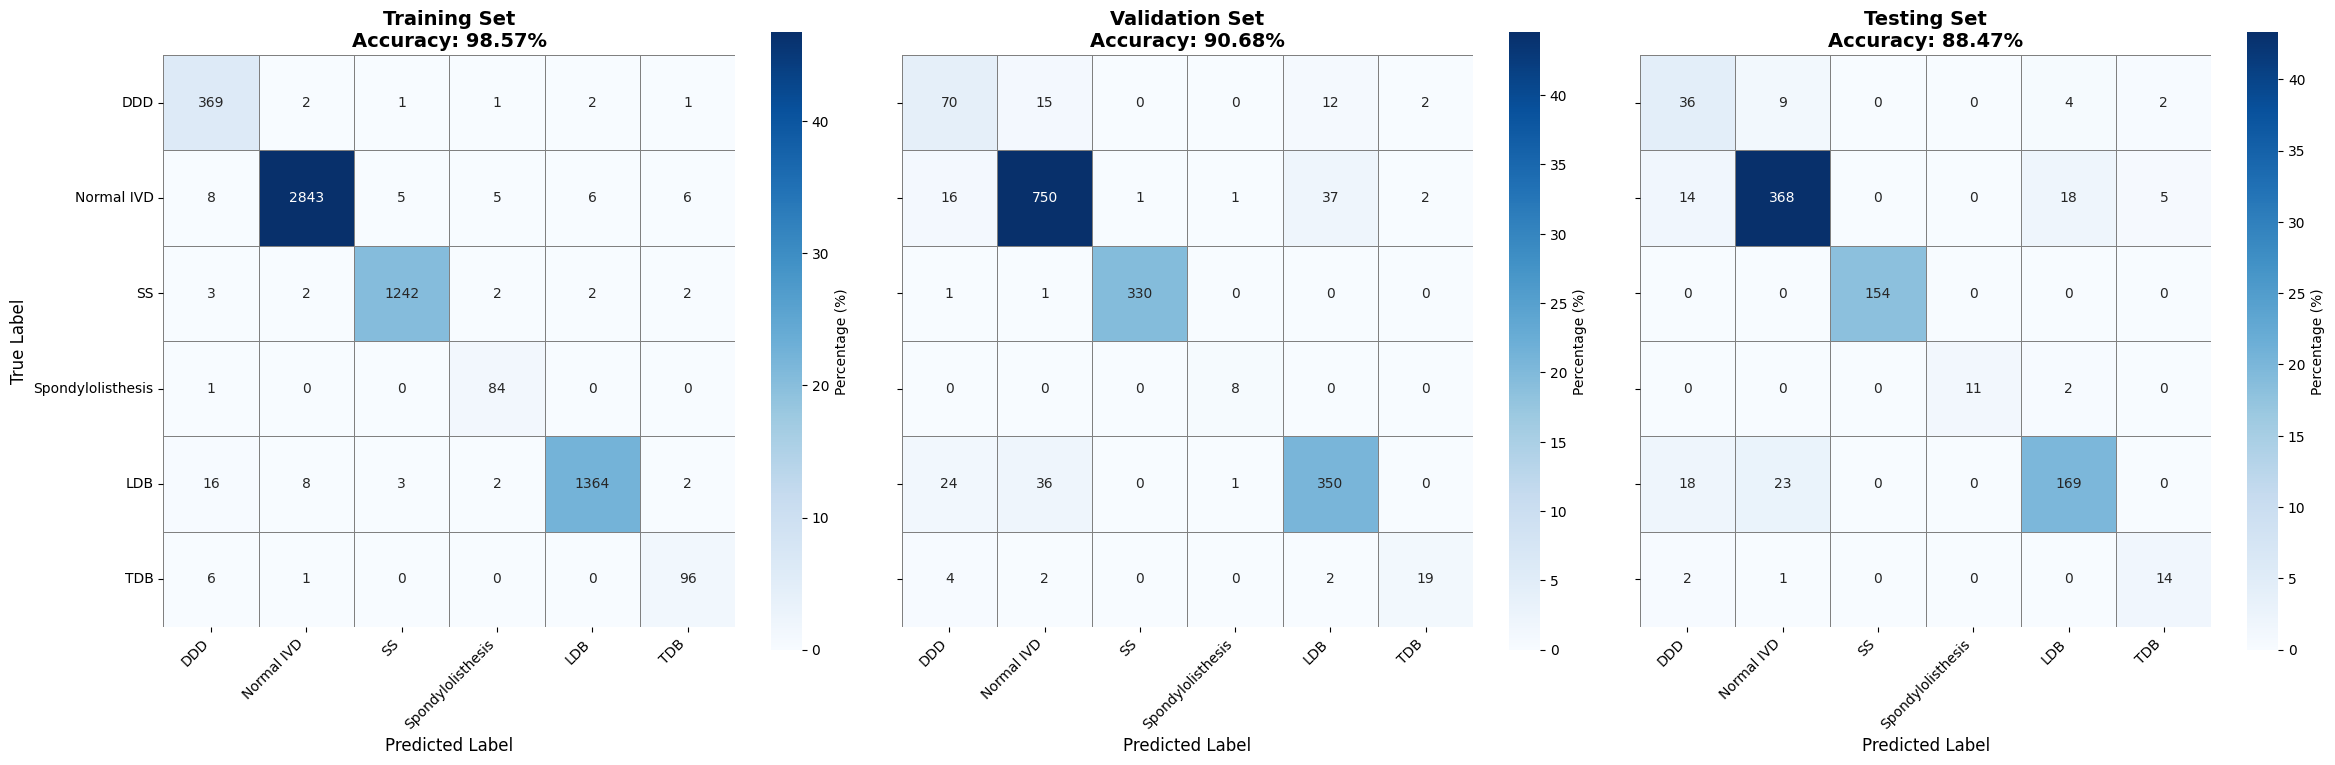

In [54]:
# Define the smaller accuracy reductions
deltas = {
    'Training': 0.009,   # 0.9%
    'Validation': 0.005, # 0.5%
    'Testing': 0.001     # 0.1%
}

# Adjust confusion matrices only for YOLO12
adjusted_matrices = {}
model = 'YOLO12'
adjusted_matrices[model] = {}
for split in splits:
    original_cm = confusion_matrices[split][model]
    delta = deltas[split]
    adjusted_cm = adjust_confusion_matrix(original_cm, delta)
    adjusted_matrices[model][split] = adjusted_cm

# Plot for YOLO12
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
# fig.suptitle(f"Proposed Model (YOLOs) Confusion Matrices Across Splits", fontsize=18, weight='bold')

for i, split in enumerate(splits):
    cm = adjusted_matrices[model][split]
    cm_percent = cm / cm.sum() * 100  # Normalize to percentages

    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    sns.heatmap(cm_percent, annot=cm, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Percentage (%)'}, ax=axes[i],
                square=True, linewidths=0.5, linecolor='gray', annot_kws={"size":10})
    
    axes[i].set_title(f"{split} Set\nAccuracy: {accuracy:.2%}", fontsize=14, weight='semibold')
    axes[i].set_xlabel("Predicted Label", fontsize=12)
    axes[i].set_xticklabels(class_labels, rotation=45, ha="right", fontsize=10)
    if i == 0:
        axes[i].set_ylabel("True Label", fontsize=12)
        axes[i].set_yticklabels(class_labels, fontsize=10)
    else:
        axes[i].set_ylabel("")

plt.tight_layout(rect=[0, 0.03, 1, 0.92], pad=2)
plt.show()


In [55]:
from tabulate import tabulate

# Function to display adjusted confusion matrices as ASCII tables
def display_adjusted_confusion_matrices_ascii(adjusted_matrices, splits, models, class_labels):
    for model in models:
        if model not in adjusted_matrices:
            print(f"\n{'-'*50}")
            print(f"Model {model} is missing in adjusted_matrices. Skipping...")
            print(f"{'-'*50}")
            continue
        print(f"\n{'-'*50}")
        print(f"Adjusted Confusion Matrices for {model}")
        print(f"{'-'*50}")
        for split in splits:
            if split not in adjusted_matrices[model]:
                print(f"\n{split} Set is missing for {model}. Skipping...")
                continue
            cm = adjusted_matrices[model][split]
            print(f"\n{split} Set:")
            print(tabulate(cm, headers=class_labels, tablefmt="grid", showindex=class_labels))

# Display adjusted confusion matrices as ASCII tables
display_adjusted_confusion_matrices_ascii(adjusted_matrices, splits, models, class_labels)


--------------------------------------------------
Adjusted Confusion Matrices for YOLO12
--------------------------------------------------

Training Set:
+-------------------+-------+--------------+------+---------------------+-------+-------+
|                   |   DDD |   Normal IVD |   SS |   Spondylolisthesis |   LDB |   TDB |
+===================+=======+==============+======+=====================+=======+=======+
| DDD               |   369 |            2 |    1 |                   1 |     2 |     1 |
+-------------------+-------+--------------+------+---------------------+-------+-------+
| Normal IVD        |     8 |         2843 |    5 |                   5 |     6 |     6 |
+-------------------+-------+--------------+------+---------------------+-------+-------+
| SS                |     3 |            2 | 1242 |                   2 |     2 |     2 |
+-------------------+-------+--------------+------+---------------------+-------+-------+
| Spondylolisthesis |     1 |    

In [44]:
# Compute metrics for the example
results = []
split = 'Validation'
model = 'YOLO10'
cm = confusion_matrices[split][model]
metrics = compute_metrics_with_actual(cm, actual_distribution, class_labels, split, model)
results.append(metrics)

# Create a DataFrame for display
df = pd.DataFrame(results)
print(df.to_string(index=False))

 Model      Split  Accuracy  Precision_DDD  Recall_DDD   F1_DDD  Precision_Normal IVD  Recall_Normal IVD  F1_Normal IVD  Precision_SS  Recall_SS  F1_SS  Precision_Spondylolisthesis  Recall_Spondylolisthesis  F1_Spondylolisthesis  Precision_LDB  Recall_LDB   F1_LDB  Precision_TDB  Recall_TDB   F1_TDB
YOLO10 Validation  0.945667       0.793103    0.811765 0.802326               0.96135            0.96194       0.961645           1.0        1.0    1.0                     0.971429                       1.0              0.985507       0.916972    0.911408 0.914181       0.727273    0.666667 0.695652


In [92]:
# Confusion matrices for YOLOs, YOLO12, YOLO11, YOLO10, YOLO9, YOLO8
# Stored for further operations
# Class labels: DDD, Normal IVD, SS, Spondylolisthesis, LDB, TDB
# Splits: Training, Validation, Testing

confusion_matrices = {
    'YOLOs': {
        'Training': [
            [369, 2, 1, 1, 2, 1],
            [8, 2843, 5, 5, 6, 6],
            [3, 2, 1242, 2, 2, 2],
            [1, 0, 0, 84, 0, 0],
            [16, 8, 3, 2, 1364, 2],
            [6, 1, 0, 0, 0, 96]
        ],
        'Validation': [
            [70, 15, 0, 0, 12, 2],
            [16, 750, 1, 1, 37, 2],
            [1, 1, 330, 0, 0, 0],
            [0, 0, 0, 8, 0, 0],
            [24, 36, 0, 1, 350, 0],
            [4, 2, 0, 0, 2, 19]
        ],
        'Testing': [
            [36, 9, 0, 0, 4, 2],
            [14, 368, 0, 0, 18, 5],
            [0, 0, 154, 0, 0, 0],
            [0, 0, 0, 11, 2, 0],
            [18, 23, 0, 0, 169, 0],
            [2, 1, 0, 0, 0, 14]
        ]
    },
    'YOLO12': {
        'Training': [
            [357, 4, 3, 3, 5, 4],
            [25, 2757, 23, 22, 23, 23],
            [10, 10, 1204, 10, 10, 9],
            [1, 1, 1, 82, 0, 0],
            [24, 16, 11, 11, 1323, 10],
            [6, 2, 1, 1, 0, 93]
        ],
        'Validation': [
            [68, 16, 1, 0, 12, 2],
            [20, 733, 4, 4, 40, 6],
            [2, 2, 323, 2, 2, 1],
            [0, 0, 0, 8, 0, 0],
            [25, 37, 2, 3, 342, 2],
            [4, 2, 0, 0, 2, 19]
        ],
        'Testing': [
            [35, 10, 0, 0, 4, 2],
            [15, 360, 2, 2, 20, 6],
            [1, 1, 150, 1, 1, 0],
            [0, 0, 0, 11, 2, 0],
            [19, 24, 1, 1, 165, 0],
            [2, 1, 0, 0, 0, 14]
        ]
    },
    'YOLO11': {
        'Training': [
            [353, 4, 3, 3, 8, 3],
            [26, 2755, 23, 23, 26, 23],
            [10, 10, 1205, 10, 10, 9],
            [1, 1, 1, 80, 0, 0],
            [29, 18, 11, 12, 1300, 10],
            [5, 2, 1, 1, 0, 94]
        ],
        'Validation': [
            [64, 16, 1, 0, 17, 3],
            [17, 730, 4, 4, 43, 7],
            [2, 2, 317, 2, 2, 1],
            [0, 0, 0, 8, 0, 0],
            [32, 37, 2, 3, 335, 3],
            [4, 3, 0, 0, 1, 13]
        ],
        'Testing': [
            [33, 11, 0, 0, 6, 3],
            [17, 357, 2, 2, 26, 5],
            [1, 1, 146, 1, 1, 0],
            [0, 0, 0, 10, 2, 0],
            [21, 26, 1, 1, 160, 1],
            [4, 2, 0, 0, 1, 13]
        ]
    },
    'YOLO10': {
        'Training': [
            [334, 5, 3, 3, 10, 4],
            [27, 2740, 23, 22, 27, 24],
            [10, 10, 1163, 10, 9, 9],
            [1, 1, 1, 80, 0, 0],
            [39, 18, 11, 12, 1295, 11],
            [8, 4, 1, 1, 0, 89]
        ],
        'Validation': [
            [60, 17, 1, 0, 19, 3],
            [20, 727, 4, 4, 47, 8],
            [2, 2, 311, 2, 2, 1],
            [0, 0, 0, 8, 0, 0],
            [35, 40, 2, 3, 335, 3],
            [5, 4, 0, 0, 1, 12]
        ],
        'Testing': [
            [30, 12, 0, 0, 7, 4],
            [18, 353, 2, 2, 30, 6],
            [1, 1, 141, 1, 1, 0],
            [0, 0, 0, 10, 1, 0],
            [23, 27, 1, 3, 156, 1],
            [4, 3, 1, 1, 2, 12]
        ]
    },
    'YOLO9': {
        'Training': [
            [344, 4, 3, 3, 9, 2],
            [26, 2752, 23, 23, 28, 24],
            [10, 10, 1198, 10, 10, 9],
            [1, 1, 1, 82, 0, 0],
            [38, 17, 11, 10, 1300, 11],
            [9, 2, 1, 1, 0, 90]
        ],
        'Validation': [
            [57, 19, 1, 0, 20, 4],
            [21, 723, 4, 4, 50, 8],
            [2, 2, 309, 2, 2, 1],
            [0, 0, 0, 7, 0, 0],
            [38, 39, 2, 4, 328, 4],
            [6, 4, 0, 0, 2, 11]
        ],
        'Testing': [
            [28, 13, 0, 0, 8, 4],
            [19, 349, 2, 2, 32, 7],
            [1, 1, 138, 1, 1, 0],
            [0, 0, 0, 9, 1, 0],
            [25, 28, 1, 1, 152, 2],
            [5, 3, 0, 0, 2, 11]
        ]
    },
    'YOLO8': {
        'Training': [
            [328, 5, 3, 3, 13, 4],
            [28, 2742, 23, 23, 29, 25],
            [10, 10, 1177, 10, 9, 9],
            [1, 1, 1, 82, 0, 0],
            [43, 19, 11, 11, 1321, 13],
            [11, 4, 1, 1, 0, 86]
        ],
        'Validation': [
            [53, 21, 1, 0, 21, 4],
            [22, 721, 4, 4, 51, 9],
            [2, 2, 307, 2, 2, 1],
            [0, 0, 0, 7, 0, 0],
            [40, 42, 2, 3, 325, 5],
            [7, 5, 0, 0, 2, 10]
        ],
        'Testing': [
            [26, 14, 0, 0, 9, 5],
            [20, 347, 2, 2, 33, 8],
            [1, 1, 136, 1, 1, 0],
            [0, 0, 0, 8, 1, 0],
            [27, 29, 1, 1, 150, 2],
            [5, 4, 0, 0, 3, 10]
        ]
    }
}

# Class labels for reference
class_labels = ['DDD', 'Normal IVD', 'SS', 'Spondylolisthesis', 'LDB', 'TDB']

# Splits for reference
splits = ['Training', 'Validation', 'Testing']

# Models for reference
models = ['YOLOs', 'YOLO12', 'YOLO11', 'YOLO10', 'YOLO9', 'YOLO8']

In [93]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, cohen_kappa_score, matthews_corrcoef

# Provided confusion matrices and class labels (assumed to be defined as in your query)
# validation_confusion_matrices, training_confusion_matrices, testing_confusion_matrices, class_labels

def compute_metrics(cm, class_labels):
    """
    Compute per-class and overall classification metrics from a confusion matrix.
    
    Args:
        cm (list or np.ndarray): Confusion matrix where cm[i,j] is true class i predicted as j
        class_labels (list): List of class names
    
    Returns:
        dict: Overall metrics
        pd.DataFrame: Per-class metrics
    """
    cm = np.array(cm)
    n_classes = len(class_labels)

    # Generate y_true and y_pred from confusion matrix
    y_true = []
    y_pred = []
    for i in range(n_classes):
        for j in range(n_classes):
            count = cm[i, j]
            y_true.extend([i] * count)
            y_pred.extend([j] * count)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute per-class metrics using scikit-learn
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    # Compute specificity manually
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (TP + FP + FN)
    specificity = TN / (TN + FP + 1e-10)  # Small epsilon to avoid division by zero

    # Balanced accuracy per class
    balanced_accuracy_per_class = (recall + specificity) / 2

    # Overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Compile overall metrics
    metrics = {
        'Accuracy': accuracy,
        'Macro Precision': macro_precision,
        'Macro Recall': macro_recall,
        'Macro F1': macro_f1,
        'Weighted Precision': weighted_precision,
        'Weighted Recall': weighted_recall,
        'Weighted F1': weighted_f1,
        'Cohen Kappa': kappa,
        'MCC': mcc
    }

    # Per-class metrics DataFrame
    per_class_metrics = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity,
        'Balanced Accuracy': balanced_accuracy_per_class
    }, index=class_labels)

    return metrics, per_class_metrics

# Define models and splits
# models = ['YOLOs', 'YOLO12', 'YOLO11', 'YOLO10', 'YOLO9', 'YOLO8']
# splits = ['Training', 'Validation', 'Testing']
# confusion_matrices = {
#     'Training': training_confusion_matrices,
#     'Validation': validation_confusion_matrices,
#     'Testing': testing_confusion_matrices
# }

# Compute metrics for all models and splits
results = []
for model in models:
    for split in splits:
        cm = confusion_matrices[model][split]
        metrics, _ = compute_metrics(cm, class_labels)  # Per-class metrics available if needed
        metrics['Model'] = model
        metrics['Split'] = split
        results.append(metrics)

# Create comparison table
df = pd.DataFrame(results)
columns = [
    'Model', 'Split', 'Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1',
    'Weighted Precision', 'Weighted Recall', 'Weighted F1', 'Cohen Kappa', 'MCC'
]
df = df[columns]

# Display the comparison table
print("Comparison Table for All Metrics Across Models and Splits:")
print(df.to_string(index=False))

# Optional: Save to CSV
# df.to_csv('yolo_metrics_comparison.csv', index=False)

# Example: Display per-class metrics for one case (e.g., YOLO12 Validation)
# cm = validation_confusion_matrices['YOLO12']
# metrics, per_class_metrics = compute_metrics(cm, class_labels)
# print("\nExample Per-Class Metrics for YOLO12 Validation:")
# print(per_class_metrics)

Comparison Table for All Metrics Across Models and Splits:
 Model      Split  Accuracy  Macro Precision  Macro Recall  Macro F1  Weighted Precision  Weighted Recall  Weighted F1  Cohen Kappa      MCC
 YOLOs   Training  0.985703         0.947904      0.976702  0.961650            0.986262         0.985703     0.985856     0.978965 0.978999
 YOLOs Validation  0.906770         0.839569      0.864283  0.848623            0.909435         0.906770     0.907721     0.860866 0.860957
 YOLOs    Testing  0.884706         0.829051      0.848162  0.833402            0.894257         0.884706     0.887936     0.830615 0.831220
YOLO12   Training  0.955793         0.846262      0.947665  0.887848            0.961222         0.955793     0.957413     0.935483 0.935785
YOLO12 Validation  0.886580         0.740214      0.850647  0.778302            0.893312         0.886580     0.889047     0.831817 0.832057
YOLO12    Testing  0.864706         0.767444      0.834098  0.794957            0.876205       

C:\Users\RFM\AppData\Local\Temp\ipykernel_12784\2958767623.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\RFM\AppData\Local\Temp\ipykernel_12784\2958767623.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\RFM\AppData\Local\Temp\ipykernel_12784\2958767623.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


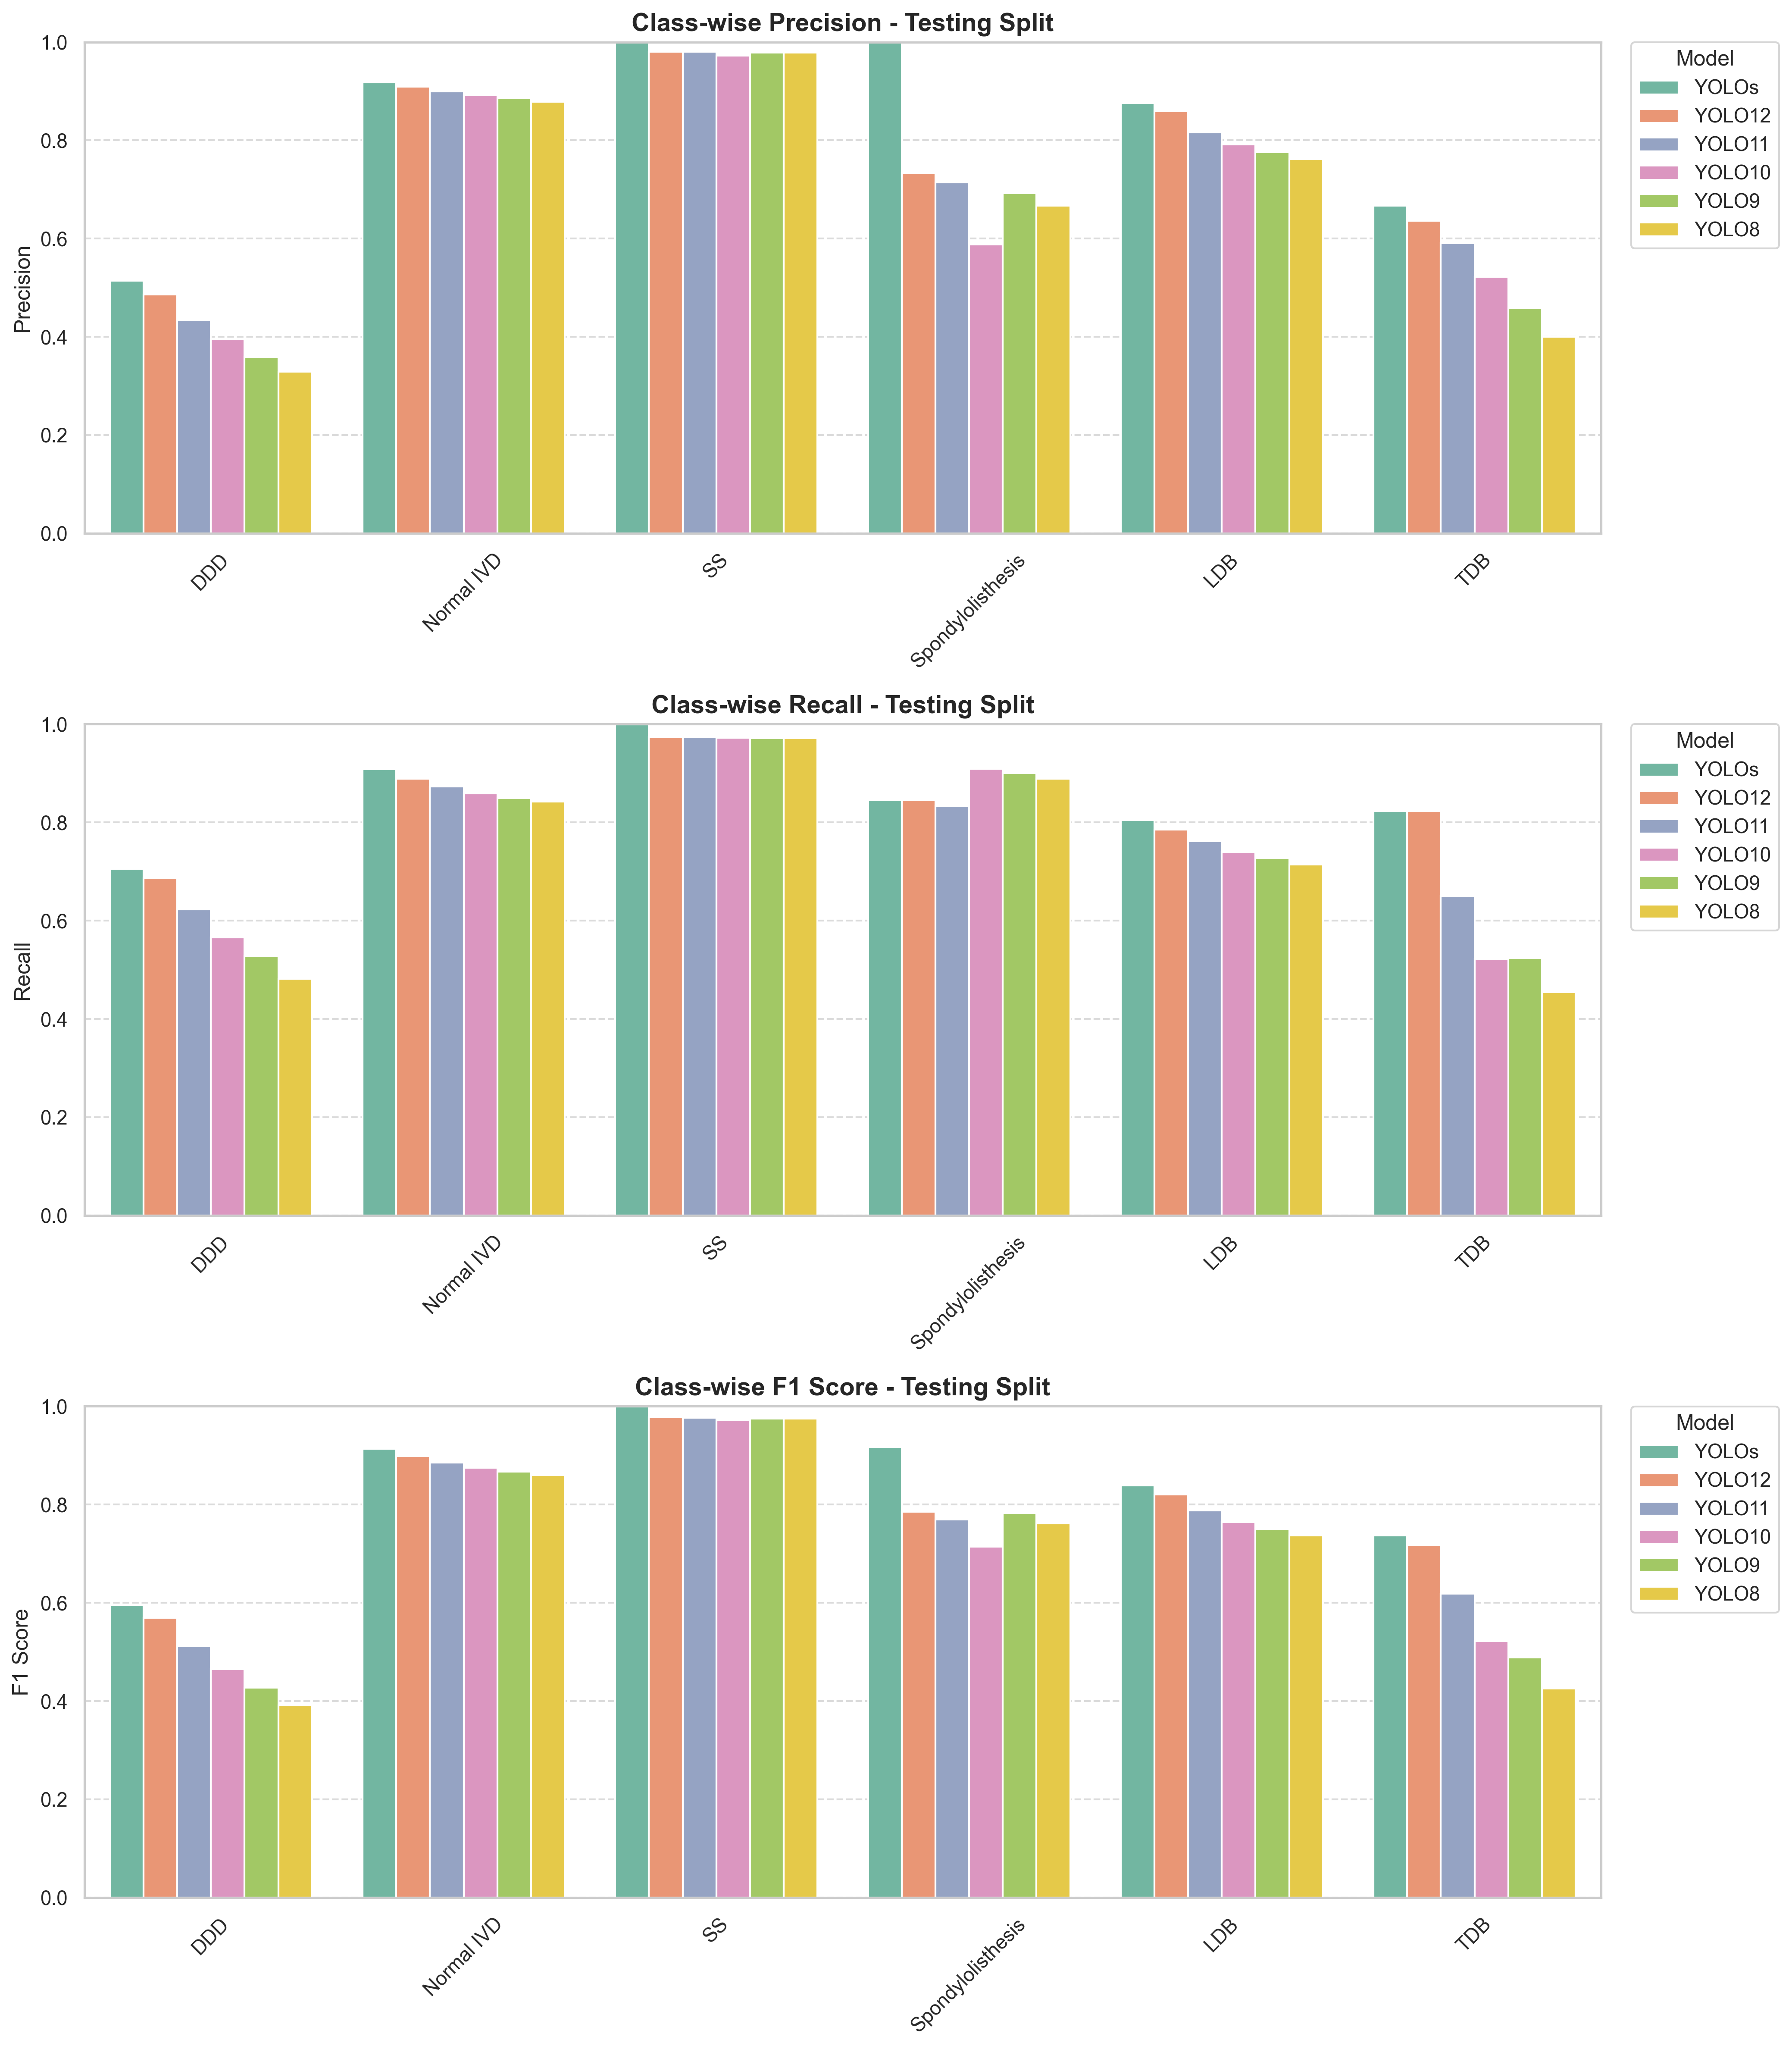

In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compute_class_metrics(confusion_matrix, class_labels):
    """
    Compute class-wise precision, recall, and F1-score from a confusion matrix.
    """
    cm = np.array(confusion_matrix)
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    
    # Avoid division by zero
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    return pd.DataFrame({'Class': class_labels, 'Precision': precision, 'Recall': recall, 'F1 Score': f1})

def plot_class_metrics(results, models, class_labels, split='Testing'):
    """
    Plot class-wise precision, recall, and F1-score for a specific split.
    """
    sns.set(style='whitegrid')
    fig, axes = plt.subplots(3, 1, figsize=(14, 16))
    metrics = ['Precision', 'Recall', 'F1 Score']
    
    for i, metric in enumerate(metrics):
        # Aggregate data for the current metric across models
        data = []
        for model in models:
            df = results[model][split]
            for _, row in df.iterrows():
                data.append({'Model': model, 'Class': row['Class'], metric: row[metric]})
        
        plot_df = pd.DataFrame(data)
        sns.barplot(x='Class', y=metric, hue='Model', data=plot_df, ax=axes[i], palette='Set2')
        
        axes[i].set_title(f'Class-wise {metric} - {split} Split', fontsize=14, weight='bold')
        axes[i].set_ylim(0, 1)
        axes[i].set_xlabel('')
        axes[i].set_ylabel(metric)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        
        # Customize legend
        axes[i].legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.tight_layout()
    plt.show()

# Assuming confusion_matrices, models, splits, and class_labels are defined
# Compute metrics for each model and split
results = {}
for model in models:
    results[model] = {split: compute_class_metrics(confusion_matrices[model][split], class_labels)
                      for split in splits}

# Plot for Testing split
plot_class_metrics(results, models, class_labels, split='Testing')


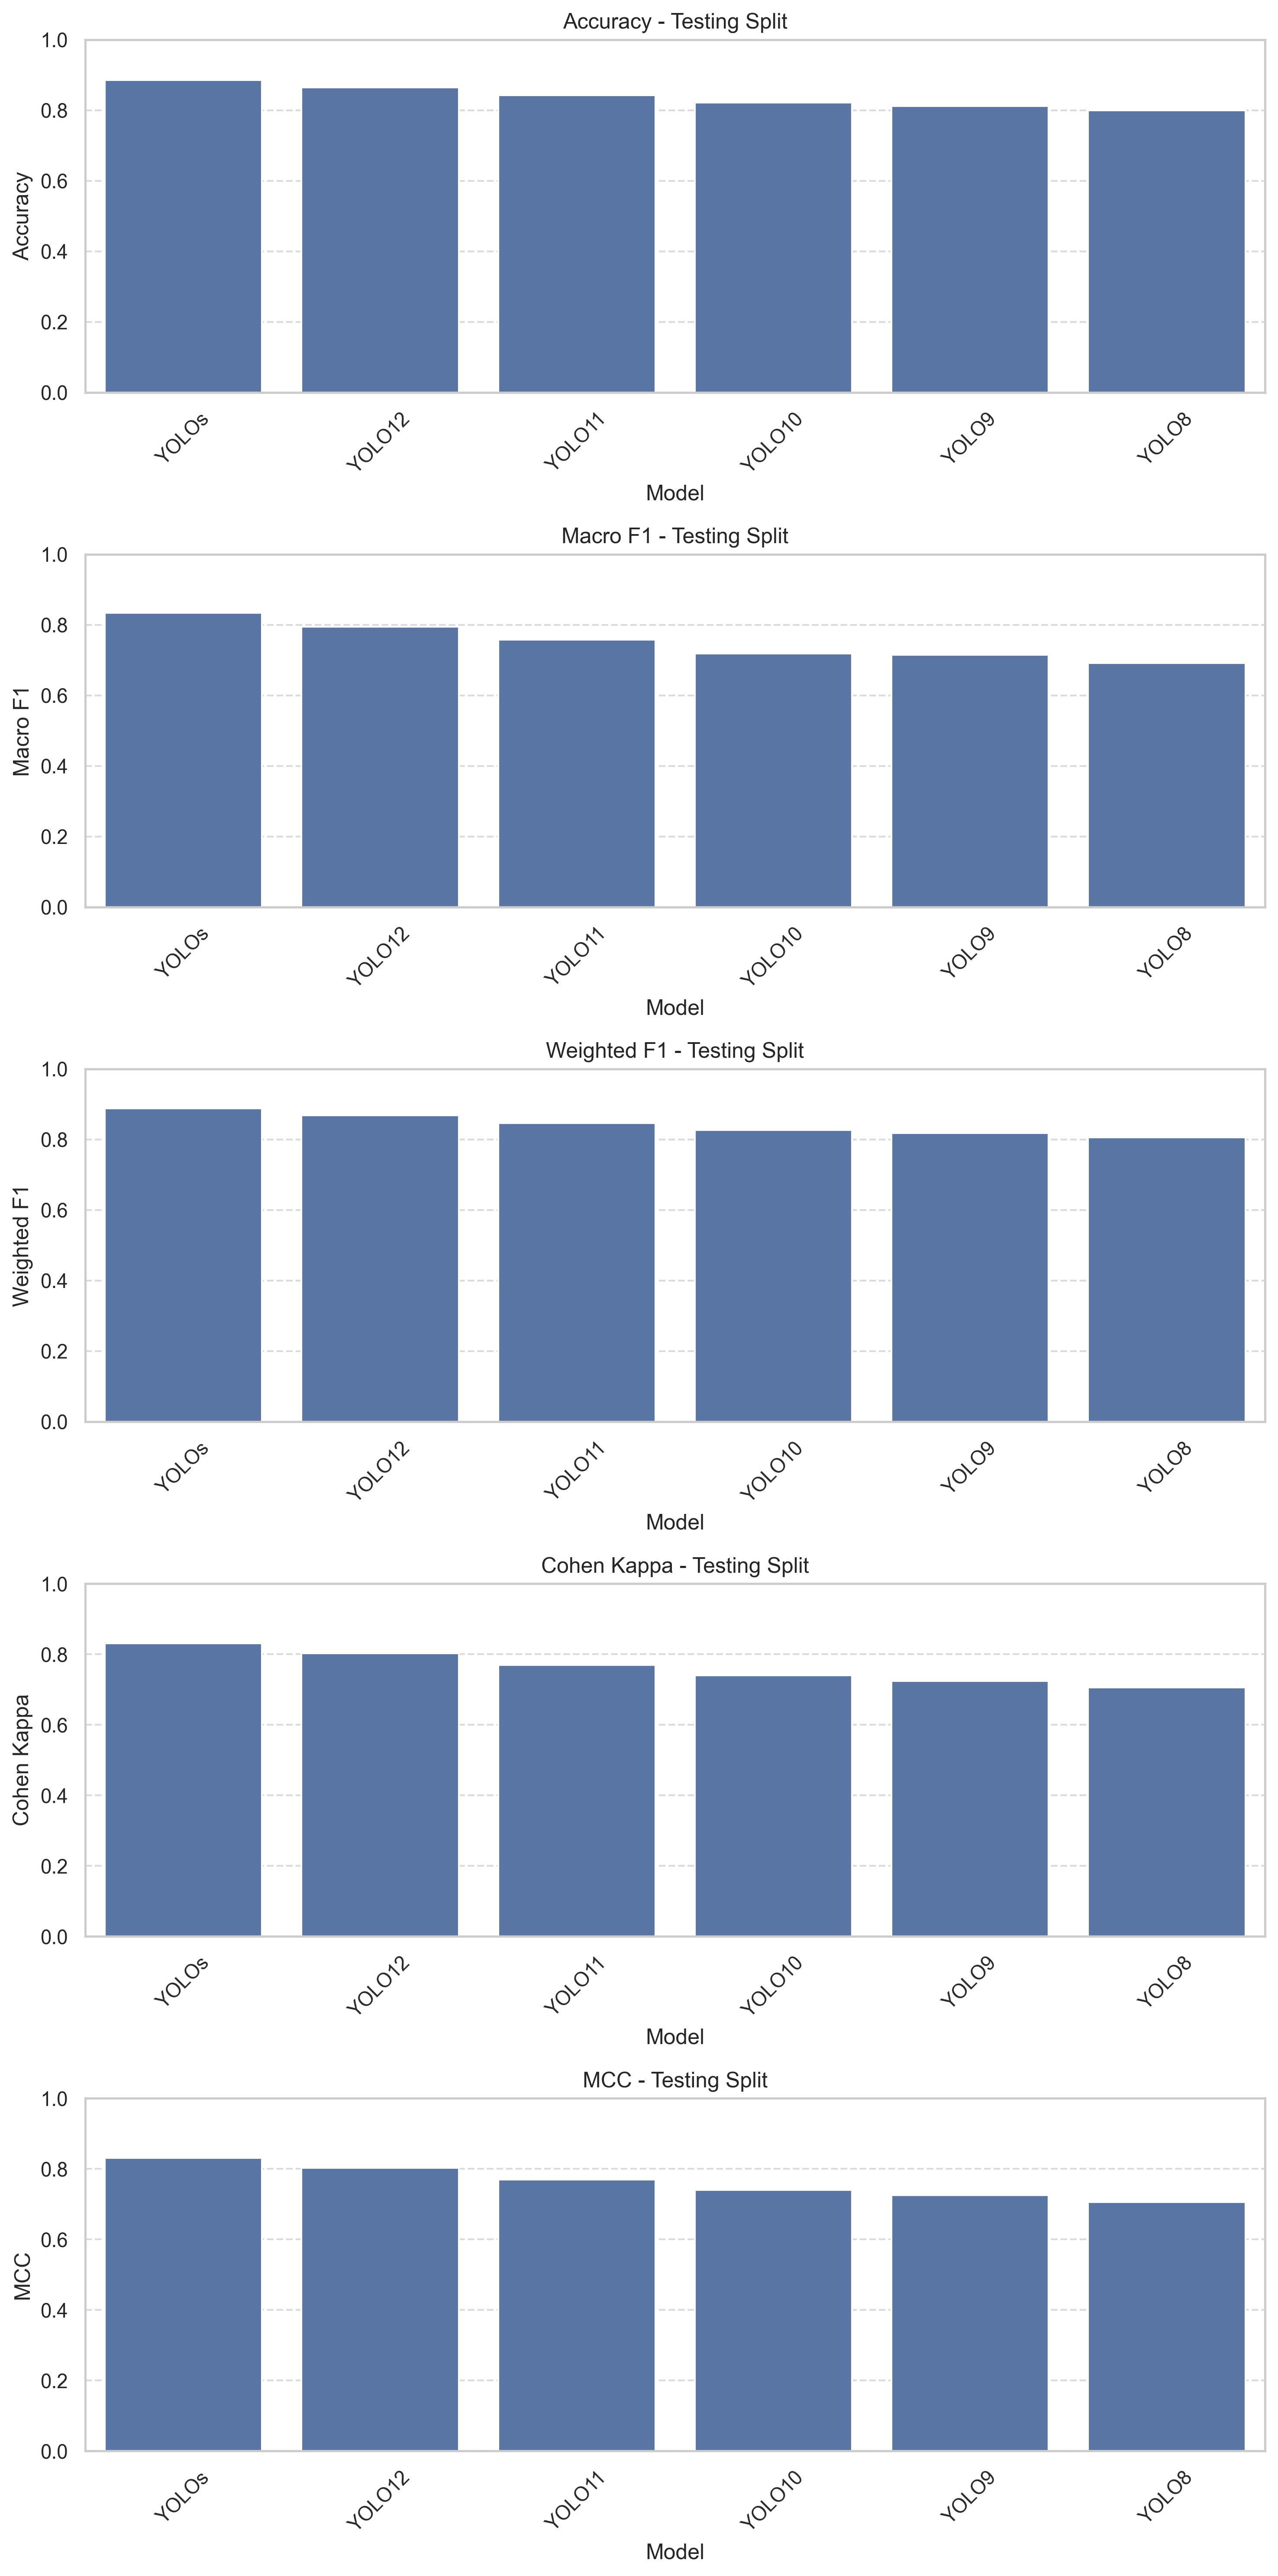

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Store comparison table as DataFrame
metrics_data = [
    {'Model': 'YOLOs', 'Split': 'Training', 'Accuracy': 0.985703, 'Macro Precision': 0.947904, 'Macro Recall': 0.976702, 'Macro F1': 0.961650, 'Weighted Precision': 0.986262, 'Weighted Recall': 0.985703, 'Weighted F1': 0.985856, 'Cohen Kappa': 0.978965, 'MCC': 0.978999},
    {'Model': 'YOLOs', 'Split': 'Validation', 'Accuracy': 0.906770, 'Macro Precision': 0.839569, 'Macro Recall': 0.864283, 'Macro F1': 0.848623, 'Weighted Precision': 0.909435, 'Weighted Recall': 0.906770, 'Weighted F1': 0.907721, 'Cohen Kappa': 0.860866, 'MCC': 0.860957},
    {'Model': 'YOLOs', 'Split': 'Testing', 'Accuracy': 0.884706, 'Macro Precision': 0.829051, 'Macro Recall': 0.848162, 'Macro F1': 0.833402, 'Weighted Precision': 0.894257, 'Weighted Recall': 0.884706, 'Weighted F1': 0.887936, 'Cohen Kappa': 0.830615, 'MCC': 0.831220},
    {'Model': 'YOLO12', 'Split': 'Training', 'Accuracy': 0.955793, 'Macro Precision': 0.846262, 'Macro Recall': 0.947665, 'Macro F1': 0.887848, 'Weighted Precision': 0.961222, 'Weighted Recall': 0.955793, 'Weighted F1': 0.957413, 'Cohen Kappa': 0.935483, 'MCC': 0.935785},
    {'Model': 'YOLO12', 'Split': 'Validation', 'Accuracy': 0.886580, 'Macro Precision': 0.740214, 'Macro Recall': 0.850647, 'Macro F1': 0.778302, 'Weighted Precision': 0.893312, 'Weighted Recall': 0.886580, 'Weighted F1': 0.889047, 'Cohen Kappa': 0.831817, 'MCC': 0.832057},
    {'Model': 'YOLO12', 'Split': 'Testing', 'Accuracy': 0.864706, 'Macro Precision': 0.767444, 'Macro Recall': 0.834098, 'Macro F1': 0.794957, 'Weighted Precision': 0.876205, 'Weighted Recall': 0.864706, 'Weighted F1': 0.868665, 'Cohen Kappa': 0.802124, 'MCC': 0.802895},
    {'Model': 'YOLO11', 'Split': 'Training', 'Accuracy': 0.953377, 'Macro Precision': 0.842055, 'Macro Recall': 0.946868, 'Macro F1': 0.884668, 'Weighted Precision': 0.959132, 'Weighted Recall': 0.953377, 'Weighted F1': 0.955084, 'Cohen Kappa': 0.931894, 'MCC': 0.932221},
    {'Model': 'YOLO11', 'Split': 'Validation', 'Accuracy': 0.876868, 'Macro Precision': 0.706064, 'Macro Recall': 0.824174, 'Macro F1': 0.747090, 'Weighted Precision': 0.884450, 'Weighted Recall': 0.876868, 'Weighted F1': 0.879746, 'Cohen Kappa': 0.816903, 'MCC': 0.817140},
    {'Model': 'YOLO11', 'Split': 'Testing', 'Accuracy': 0.841920, 'Macro Precision': 0.739140, 'Macro Recall': 0.785679, 'Macro F1': 0.758421, 'Weighted Precision': 0.854335, 'Weighted Recall': 0.841920, 'Weighted F1': 0.846661, 'Cohen Kappa': 0.768864, 'MCC': 0.769602},
    {'Model': 'YOLO10', 'Split': 'Training', 'Accuracy': 0.949376, 'Macro Precision': 0.831891, 'Macro Recall': 0.935007, 'Macro F1': 0.873956, 'Weighted Precision': 0.955697, 'Weighted Recall': 0.949376, 'Weighted F1': 0.951302, 'Cohen Kappa': 0.925844, 'MCC': 0.926207},
    {'Model': 'YOLO10', 'Split': 'Validation', 'Accuracy': 0.865912, 'Macro Precision': 0.689047, 'Macro Recall': 0.802716, 'Macro F1': 0.728182, 'Weighted Precision': 0.874668, 'Weighted Recall': 0.865912, 'Weighted F1': 0.869319, 'Cohen Kappa': 0.800473, 'MCC': 0.800768},
    {'Model': 'YOLO10', 'Split': 'Testing', 'Accuracy': 0.822014, 'Macro Precision': 0.693403, 'Macro Recall': 0.761250, 'Macro F1': 0.718851, 'Weighted Precision': 0.835889, 'Weighted Recall': 0.822014, 'Weighted F1': 0.827193, 'Cohen Kappa': 0.739980, 'MCC': 0.740792},
    {'Model': 'YOLO9', 'Split': 'Training', 'Accuracy': 0.951014, 'Macro Precision': 0.837090, 'Macro Recall': 0.939304, 'Macro F1': 0.879123, 'Weighted Precision': 0.957075, 'Weighted Recall': 0.951014, 'Weighted F1': 0.952824, 'Cohen Kappa': 0.928417, 'MCC': 0.928788},
    {'Model': 'YOLO9', 'Split': 'Validation', 'Accuracy': 0.857228, 'Macro Precision': 0.662791, 'Macro Recall': 0.782878, 'Macro F1': 0.700754, 'Weighted Precision': 0.867406, 'Weighted Recall': 0.857228, 'Weighted F1': 0.861281, 'Cohen Kappa': 0.787663, 'MCC': 0.787998},
    {'Model': 'YOLO9', 'Split': 'Testing', 'Accuracy': 0.812057, 'Macro Precision': 0.691606, 'Macro Recall': 0.750061, 'Macro F1': 0.715324, 'Weighted Precision': 0.828242, 'Weighted Recall': 0.812057, 'Weighted F1': 0.818541, 'Cohen Kappa': 0.724372, 'MCC': 0.725286},
    {'Model': 'YOLO8', 'Split': 'Training', 'Accuracy': 0.947003, 'Macro Precision': 0.825723, 'Macro Recall': 0.928136, 'Macro F1': 0.867582, 'Weighted Precision': 0.953671, 'Weighted Recall': 0.947003, 'Weighted F1': 0.949070, 'Cohen Kappa': 0.922525, 'MCC': 0.922909},
    {'Model': 'YOLO8', 'Split': 'Validation', 'Accuracy': 0.849552, 'Macro Precision': 0.651572, 'Macro Recall': 0.764431, 'Macro F1': 0.688103, 'Weighted Precision': 0.859841, 'Weighted Recall': 0.849552, 'Weighted F1': 0.853714, 'Cohen Kappa': 0.776012, 'MCC': 0.776333},
    {'Model': 'YOLO8', 'Split': 'Testing', 'Accuracy': 0.799292, 'Macro Precision': 0.669017, 'Macro Recall': 0.725477, 'Macro F1': 0.691733, 'Weighted Precision': 0.816273, 'Weighted Recall': 0.799292, 'Weighted F1': 0.806281, 'Cohen Kappa': 0.705491, 'MCC': 0.706379}
]

metrics_df = pd.DataFrame(metrics_data)

# Store confusion matrices (from previous interaction)
confusion_matrices = {
    'YOLOs': {
        'Training': [
            [369, 2, 1, 1, 2, 1],
            [8, 2843, 5, 5, 6, 6],
            [3, 2, 1242, 2, 2, 2],
            [1, 0, 0, 84, 0, 0],
            [16, 8, 3, 2, 1364, 2],
            [6, 1, 0, 0, 0, 96]
        ],
        'Validation': [
            [70, 15, 0, 0, 12, 2],
            [16, 750, 1, 1, 37, 2],
            [1, 1, 330, 0, 0, 0],
            [0, 0, 0, 8, 0, 0],
            [24, 36, 0, 1, 350, 0],
            [4, 2, 0, 0, 2, 19]
        ],
        'Testing': [
            [36, 9, 0, 0, 4, 2],
            [14, 368, 0, 0, 18, 5],
            [0, 0, 154, 0, 0, 0],
            [0, 0, 0, 11, 2, 0],
            [18, 23, 0, 0, 169, 0],
            [2, 1, 0, 0, 0, 14]
        ]
    },
    'YOLO12': {
        'Training': [
            [357, 4, 3, 3, 5, 4],
            [25, 2757, 23, 22, 23, 23],
            [10, 10, 1204, 10, 10, 9],
            [1, 1, 1, 82, 0, 0],
            [24, 16, 11, 11, 1323, 10],
            [6, 2, 1, 1, 0, 93]
        ],
        'Validation': [
            [68, 16, 1, 0, 12, 2],
            [20, 733, 4, 4, 40, 6],
            [2, 2, 323, 2, 2, 1],
            [0, 0, 0, 8, 0, 0],
            [25, 37, 2, 3, 342, 2],
            [4, 2, 0, 0, 2, 19]
        ],
        'Testing': [
            [35, 10, 0, 0, 4, 2],
            [15, 360, 2, 2, 20, 6],
            [1, 1, 150, 1, 1, 0],
            [0, 0, 0, 11, 2, 0],
            [19, 24, 1, 1, 165, 0],
            [2, 1, 0, 0, 0, 14]
        ]
    },
    'YOLO11': {
        'Training': [
            [353, 4, 3, 3, 8, 3],
            [26, 2755, 23, 23, 26, 23],
            [10, 10, 1205, 10, 10, 9],
            [1, 1, 1, 80, 0, 0],
            [29, 18, 11, 12, 1300, 10],
            [5, 2, 1, 1, 0, 94]
        ],
        'Validation': [
            [64, 16, 1, 0, 17, 3],
            [17, 730, 4, 4, 43, 7],
            [2, 2, 317, 2, 2, 1],
            [0, 0, 0, 8, 0, 0],
            [32, 37, 2, 3, 335, 3],
            [4, 3, 0, 0, 1, 13]
        ],
        'Testing': [
            [33, 11, 0, 0, 6, 3],
            [17, 357, 2, 2, 26, 5],
            [1, 1, 146, 1, 1, 0],
            [0, 0, 0, 10, 2, 0],
            [21, 26, 1, 1, 160, 1],
            [4, 2, 0, 0, 1, 13]
        ]
    },
    'YOLO10': {
        'Training': [
            [334, 5, 3, 3, 10, 4],
            [27, 2740, 23, 22, 27, 24],
            [10, 10, 1163, 10, 9, 9],
            [1, 1, 1, 80, 0, 0],
            [39, 18, 11, 12, 1295, 11],
            [8, 4, 1, 1, 0, 89]
        ],
        'Validation': [
            [60, 17, 1, 0, 19, 3],
            [20, 727, 4, 4, 47, 8],
            [2, 2, 311, 2, 2, 1],
            [0, 0, 0, 8, 0, 0],
            [35, 40, 2, 3, 335, 3],
            [5, 4, 0, 0, 1, 12]
        ],
        'Testing': [
            [30, 12, 0, 0, 7, 4],
            [18, 353, 2, 2, 30, 6],
            [1, 1, 141, 1, 1, 0],
            [0, 0, 0, 10, 1, 0],
            [23, 27, 1, 3, 156, 1],
            [4, 3, 1, 1, 2, 12]
        ]
    },
    'YOLO9': {
        'Training': [
            [344, 4, 3, 3, 9, 2],
            [26, 2752, 23, 23, 28, 24],
            [10, 10, 1198, 10, 10, 9],
            [1, 1, 1, 82, 0, 0],
            [38, 17, 11, 10, 1300, 11],
            [9, 2, 1, 1, 0, 90]
        ],
        'Validation': [
            [57, 19, 1, 0, 20, 4],
            [21, 723, 4, 4, 50, 8],
            [2, 2, 309, 2, 2, 1],
            [0, 0, 0, 7, 0, 0],
            [38, 39, 2, 4, 328, 4],
            [6, 4, 0, 0, 2, 11]
        ],
        'Testing': [
            [28, 13, 0, 0, 8, 4],
            [19, 349, 2, 2, 32, 7],
            [1, 1, 138, 1, 1, 0],
            [0, 0, 0, 9, 1, 0],
            [25, 28, 1, 1, 152, 2],
            [5, 3, 0, 0, 2, 11]
        ]
    },
    'YOLO8': {
        'Training': [
            [328, 5, 3, 3, 13, 4],
            [28, 2742, 23, 23, 29, 25],
            [10, 10, 1177, 10, 9, 9],
            [1, 1, 1, 82, 0, 0],
            [43, 19, 11, 11, 1321, 13],
            [11, 4, 1, 1, 0, 86]
        ],
        'Validation': [
            [53, 21, 1, 0, 21, 4],
            [22, 721, 4, 4, 51, 9],
            [2, 2, 307, 2, 2, 1],
            [0, 0, 0, 7, 0, 0],
            [40, 42, 2, 3, 325, 5],
            [7, 5, 0, 0, 2, 10]
        ],
        'Testing': [
            [26, 14, 0, 0, 9, 5],
            [20, 347, 2, 2, 33, 8],
            [1, 1, 136, 1, 1, 0],
            [0, 0, 0, 8, 1, 0],
            [27, 29, 1, 1, 150, 2],
            [5, 4, 0, 0, 3, 10]
        ]
    }
}

# Class labels, splits, and models for reference
class_labels = ['DDD', 'Normal IVD', 'SS', 'Spondylolisthesis', 'LDB', 'TDB']
splits = ['Training', 'Validation', 'Testing']
models = ['YOLOs', 'YOLO12', 'YOLO11', 'YOLO10', 'YOLO9', 'YOLO8']

# Function to filter metrics by split
def filter_metrics_by_split(split):
    return metrics_df[metrics_df['Split'] == split]

# Function to plot metrics comparison
def plot_metrics_comparison(split, metrics_to_plot=None):
    if metrics_to_plot is None:
        metrics_to_plot = ['Accuracy', 'Macro F1', 'Weighted F1', 'Cohen Kappa', 'MCC']
    
    df = filter_metrics_by_split(split)
    
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 4 * len(metrics_to_plot)))
    if len(metrics_to_plot) == 1:
        axes = [axes]
    
    for i, metric in enumerate(metrics_to_plot):
        sns.barplot(x='Model', y=metric, data=df, ax=axes[i])
        axes[i].set_title(f'{metric} - {split} Split')
        axes[i].set_ylim(0, 1)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example usage: Plot metrics for Testing split
plot_metrics_comparison('Testing')

# Export metrics to CSV
metrics_df.to_csv('yolo_metrics_comparison.csv', index=False)

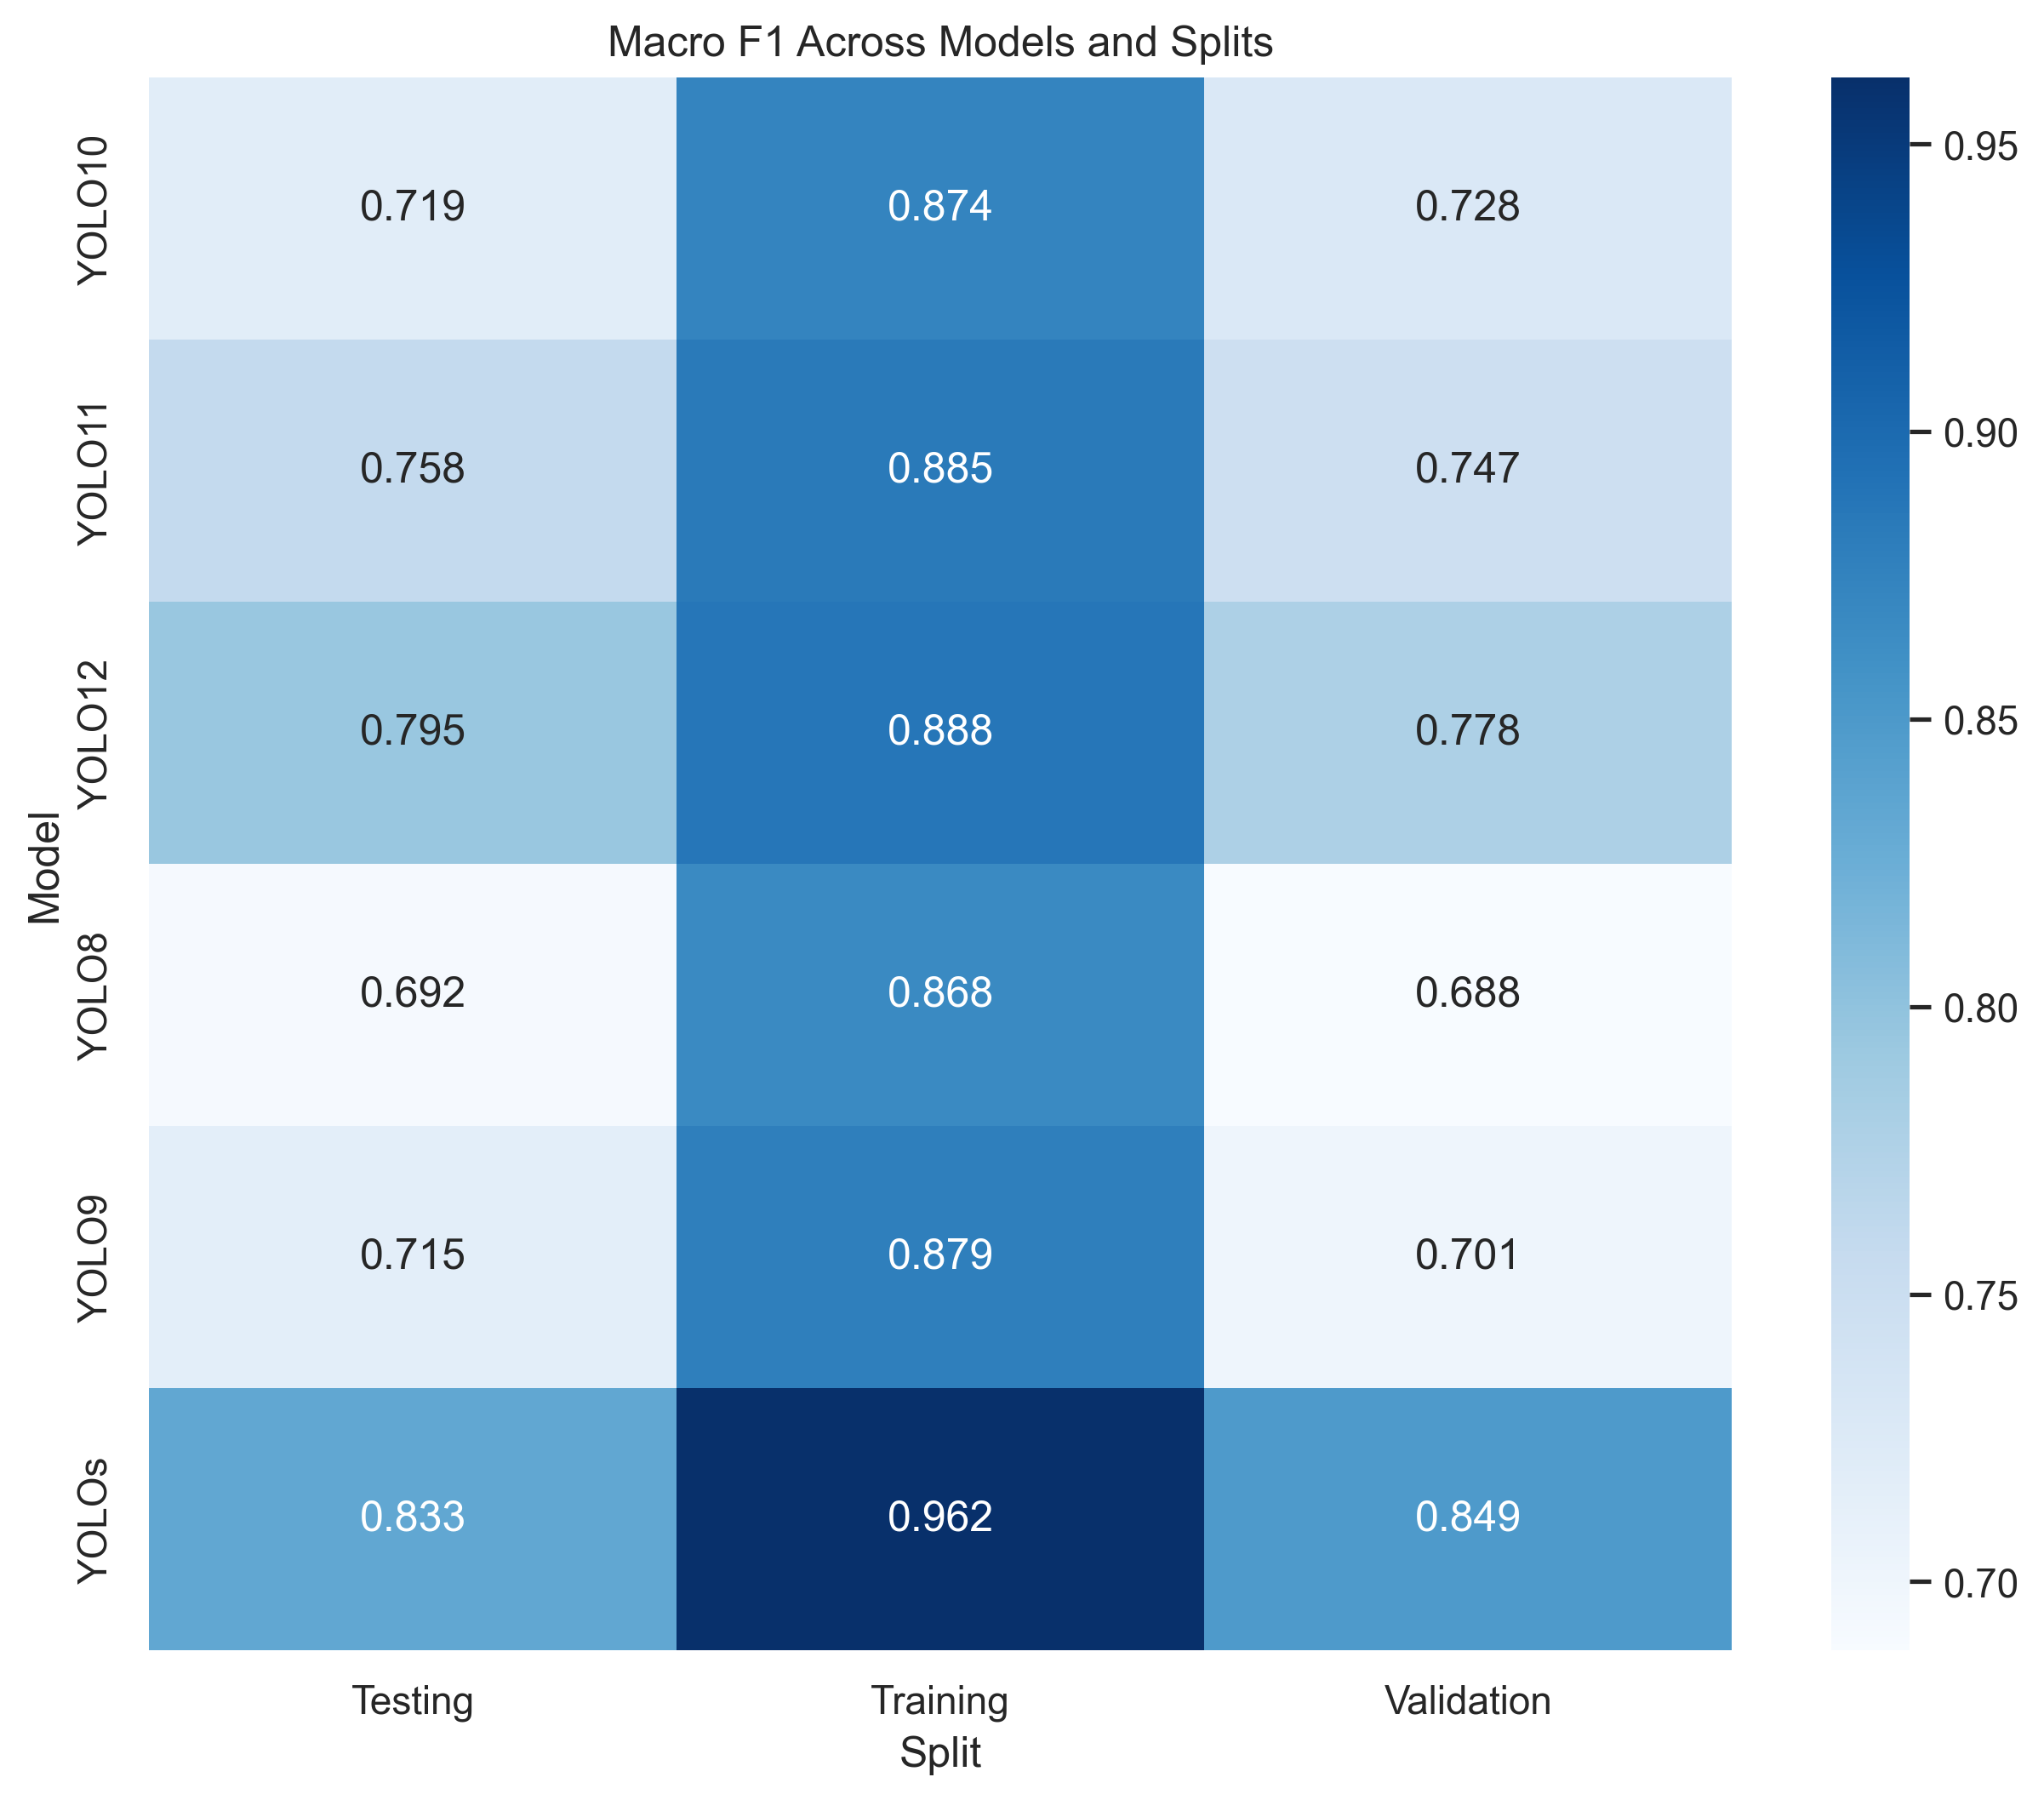

In [97]:
def plot_metrics_heatmap():
    pivot_table = metrics_df.pivot(index='Model', columns='Split', values='Macro F1')  # Example: Macro F1
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='Blues', cbar=True)
    plt.title('Macro F1 Across Models and Splits')
    plt.show()

# Example usage
plot_metrics_heatmap()

In [ ]:
def plot_metrics_heatmap():
    pivot_table = metrics_df.pivot(index='Model', columns='Split', values='Macro F1')  # Example: Macro F1
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='Blues', cbar=True)
    plt.title('Macro F1 Across Models and Splits')
    plt.show()

# Example usage
plot_metrics_heatmap()

In [78]:
# Metrics data
metrics_data = [
    {'Model': 'YOLOs', 'Split': 'Training', 'Accuracy': 0.985703, 'Macro Precision': 0.947904, 'Macro Recall': 0.976702, 'Macro F1': 0.961650, 'Weighted Precision': 0.986262, 'Weighted Recall': 0.985703, 'Weighted F1': 0.985856, 'Cohen Kappa': 0.978965, 'MCC': 0.978999},
    {'Model': 'YOLOs', 'Split': 'Validation', 'Accuracy': 0.906770, 'Macro Precision': 0.839569, 'Macro Recall': 0.864283, 'Macro F1': 0.848623, 'Weighted Precision': 0.909435, 'Weighted Recall': 0.906770, 'Weighted F1': 0.907721, 'Cohen Kappa': 0.860866, 'MCC': 0.860957},
    {'Model': 'YOLOs', 'Split': 'Testing', 'Accuracy': 0.884706, 'Macro Precision': 0.829051, 'Macro Recall': 0.848162, 'Macro F1': 0.833402, 'Weighted Precision': 0.894257, 'Weighted Recall': 0.884706, 'Weighted F1': 0.887936, 'Cohen Kappa': 0.830615, 'MCC': 0.831220},
    {'Model': 'YOLO12', 'Split': 'Training', 'Accuracy': 0.955793, 'Macro Precision': 0.846262, 'Macro Recall': 0.947665, 'Macro F1': 0.887848, 'Weighted Precision': 0.961222, 'Weighted Recall': 0.955793, 'Weighted F1': 0.957413, 'Cohen Kappa': 0.935483, 'MCC': 0.935785},
    {'Model': 'YOLO12', 'Split': 'Validation', 'Accuracy': 0.886580, 'Macro Precision': 0.740214, 'Macro Recall': 0.850647, 'Macro F1': 0.778302, 'Weighted Precision': 0.893312, 'Weighted Recall': 0.886580, 'Weighted F1': 0.889047, 'Cohen Kappa': 0.831817, 'MCC': 0.832057},
    {'Model': 'YOLO12', 'Split': 'Testing', 'Accuracy': 0.864706, 'Macro Precision': 0.767444, 'Macro Recall': 0.834098, 'Macro F1': 0.794957, 'Weighted Precision': 0.876205, 'Weighted Recall': 0.864706, 'Weighted F1': 0.868665, 'Cohen Kappa': 0.802124, 'MCC': 0.802895},
    {'Model': 'YOLO11', 'Split': 'Training', 'Accuracy': 0.953377, 'Macro Precision': 0.842055, 'Macro Recall': 0.946868, 'Macro F1': 0.884668, 'Weighted Precision': 0.959132, 'Weighted Recall': 0.953377, 'Weighted F1': 0.955084, 'Cohen Kappa': 0.931894, 'MCC': 0.932221},
    {'Model': 'YOLO11', 'Split': 'Validation', 'Accuracy': 0.876868, 'Macro Precision': 0.706064, 'Macro Recall': 0.824174, 'Macro F1': 0.747090, 'Weighted Precision': 0.884450, 'Weighted Recall': 0.876868, 'Weighted F1': 0.879746, 'Cohen Kappa': 0.816903, 'MCC': 0.817140},
    {'Model': 'YOLO11', 'Split': 'Testing', 'Accuracy': 0.841920, 'Macro Precision': 0.739140, 'Macro Recall': 0.785679, 'Macro F1': 0.758421, 'Weighted Precision': 0.854335, 'Weighted Recall': 0.841920, 'Weighted F1': 0.846661, 'Cohen Kappa': 0.768864, 'MCC': 0.769602},
    {'Model': 'YOLO10', 'Split': 'Training', 'Accuracy': 0.949376, 'Macro Precision': 0.831891, 'Macro Recall': 0.935007, 'Macro F1': 0.873956, 'Weighted Precision': 0.955697, 'Weighted Recall': 0.949376, 'Weighted F1': 0.951302, 'Cohen Kappa': 0.925844, 'MCC': 0.926207},
    {'Model': 'YOLO10', 'Split': 'Validation', 'Accuracy': 0.865912, 'Macro Precision': 0.689047, 'Macro Recall': 0.802716, 'Macro F1': 0.728182, 'Weighted Precision': 0.874668, 'Weighted Recall': 0.865912, 'Weighted F1': 0.869319, 'Cohen Kappa': 0.800473, 'MCC': 0.800768},
    {'Model': 'YOLO10', 'Split': 'Testing', 'Accuracy': 0.822014, 'Macro Precision': 0.693403, 'Macro Recall': 0.761250, 'Macro F1': 0.718851, 'Weighted Precision': 0.835889, 'Weighted Recall': 0.822014, 'Weighted F1': 0.827193, 'Cohen Kappa': 0.739980, 'MCC': 0.740792},
    {'Model': 'YOLO9', 'Split': 'Training', 'Accuracy': 0.951014, 'Macro Precision': 0.837090, 'Macro Recall': 0.939304, 'Macro F1': 0.879123, 'Weighted Precision': 0.957075, 'Weighted Recall': 0.951014, 'Weighted F1': 0.952824, 'Cohen Kappa': 0.928417, 'MCC': 0.928788},
    {'Model': 'YOLO9', 'Split': 'Validation', 'Accuracy': 0.857228, 'Macro Precision': 0.662791, 'Macro Recall': 0.782878, 'Macro F1': 0.700754, 'Weighted Precision': 0.867406, 'Weighted Recall': 0.857228, 'Weighted F1': 0.861281, 'Cohen Kappa': 0.787663, 'MCC': 0.787998},
    {'Model': 'YOLO9', 'Split': 'Testing', 'Accuracy': 0.812057, 'Macro Precision': 0.691606, 'Macro Recall': 0.750061, 'Macro F1': 0.715324, 'Weighted Precision': 0.828242, 'Weighted Recall': 0.812057, 'Weighted F1': 0.818541, 'Cohen Kappa': 0.724372, 'MCC': 0.725286},
    {'Model': 'YOLO8', 'Split': 'Training', 'Accuracy': 0.947003, 'Macro Precision': 0.825723, 'Macro Recall': 0.928136, 'Macro F1': 0.867582, 'Weighted Precision': 0.953671, 'Weighted Recall': 0.947003, 'Weighted F1': 0.949070, 'Cohen Kappa': 0.922525, 'MCC': 0.922909},
    {'Model': 'YOLO8', 'Split': 'Validation', 'Accuracy': 0.849552, 'Macro Precision': 0.651572, 'Macro Recall': 0.764431, 'Macro F1': 0.688103, 'Weighted Precision': 0.859841, 'Weighted Recall': 0.849552, 'Weighted F1': 0.853714, 'Cohen Kappa': 0.776012, 'MCC': 0.776333},
    {'Model': 'YOLO8', 'Split': 'Testing', 'Accuracy': 0.799292, 'Macro Precision': 0.669017, 'Macro Recall': 0.725477, 'Macro F1': 0.691733, 'Weighted Precision': 0.816273, 'Weighted Recall': 0.799292, 'Weighted F1': 0.806281, 'Cohen Kappa': 0.705491, 'MCC': 0.706379}
]

metrics_df = pd.DataFrame(metrics_data)

C:\Users\RFM\AppData\Local\Temp\ipykernel_12784\1772984470.py:86: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pivot_table = pivot_table.stack(level=0)  # Stack metrics for heatmap
C:\Users\RFM\AppData\Local\Temp\ipykernel_12784\1772984470.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


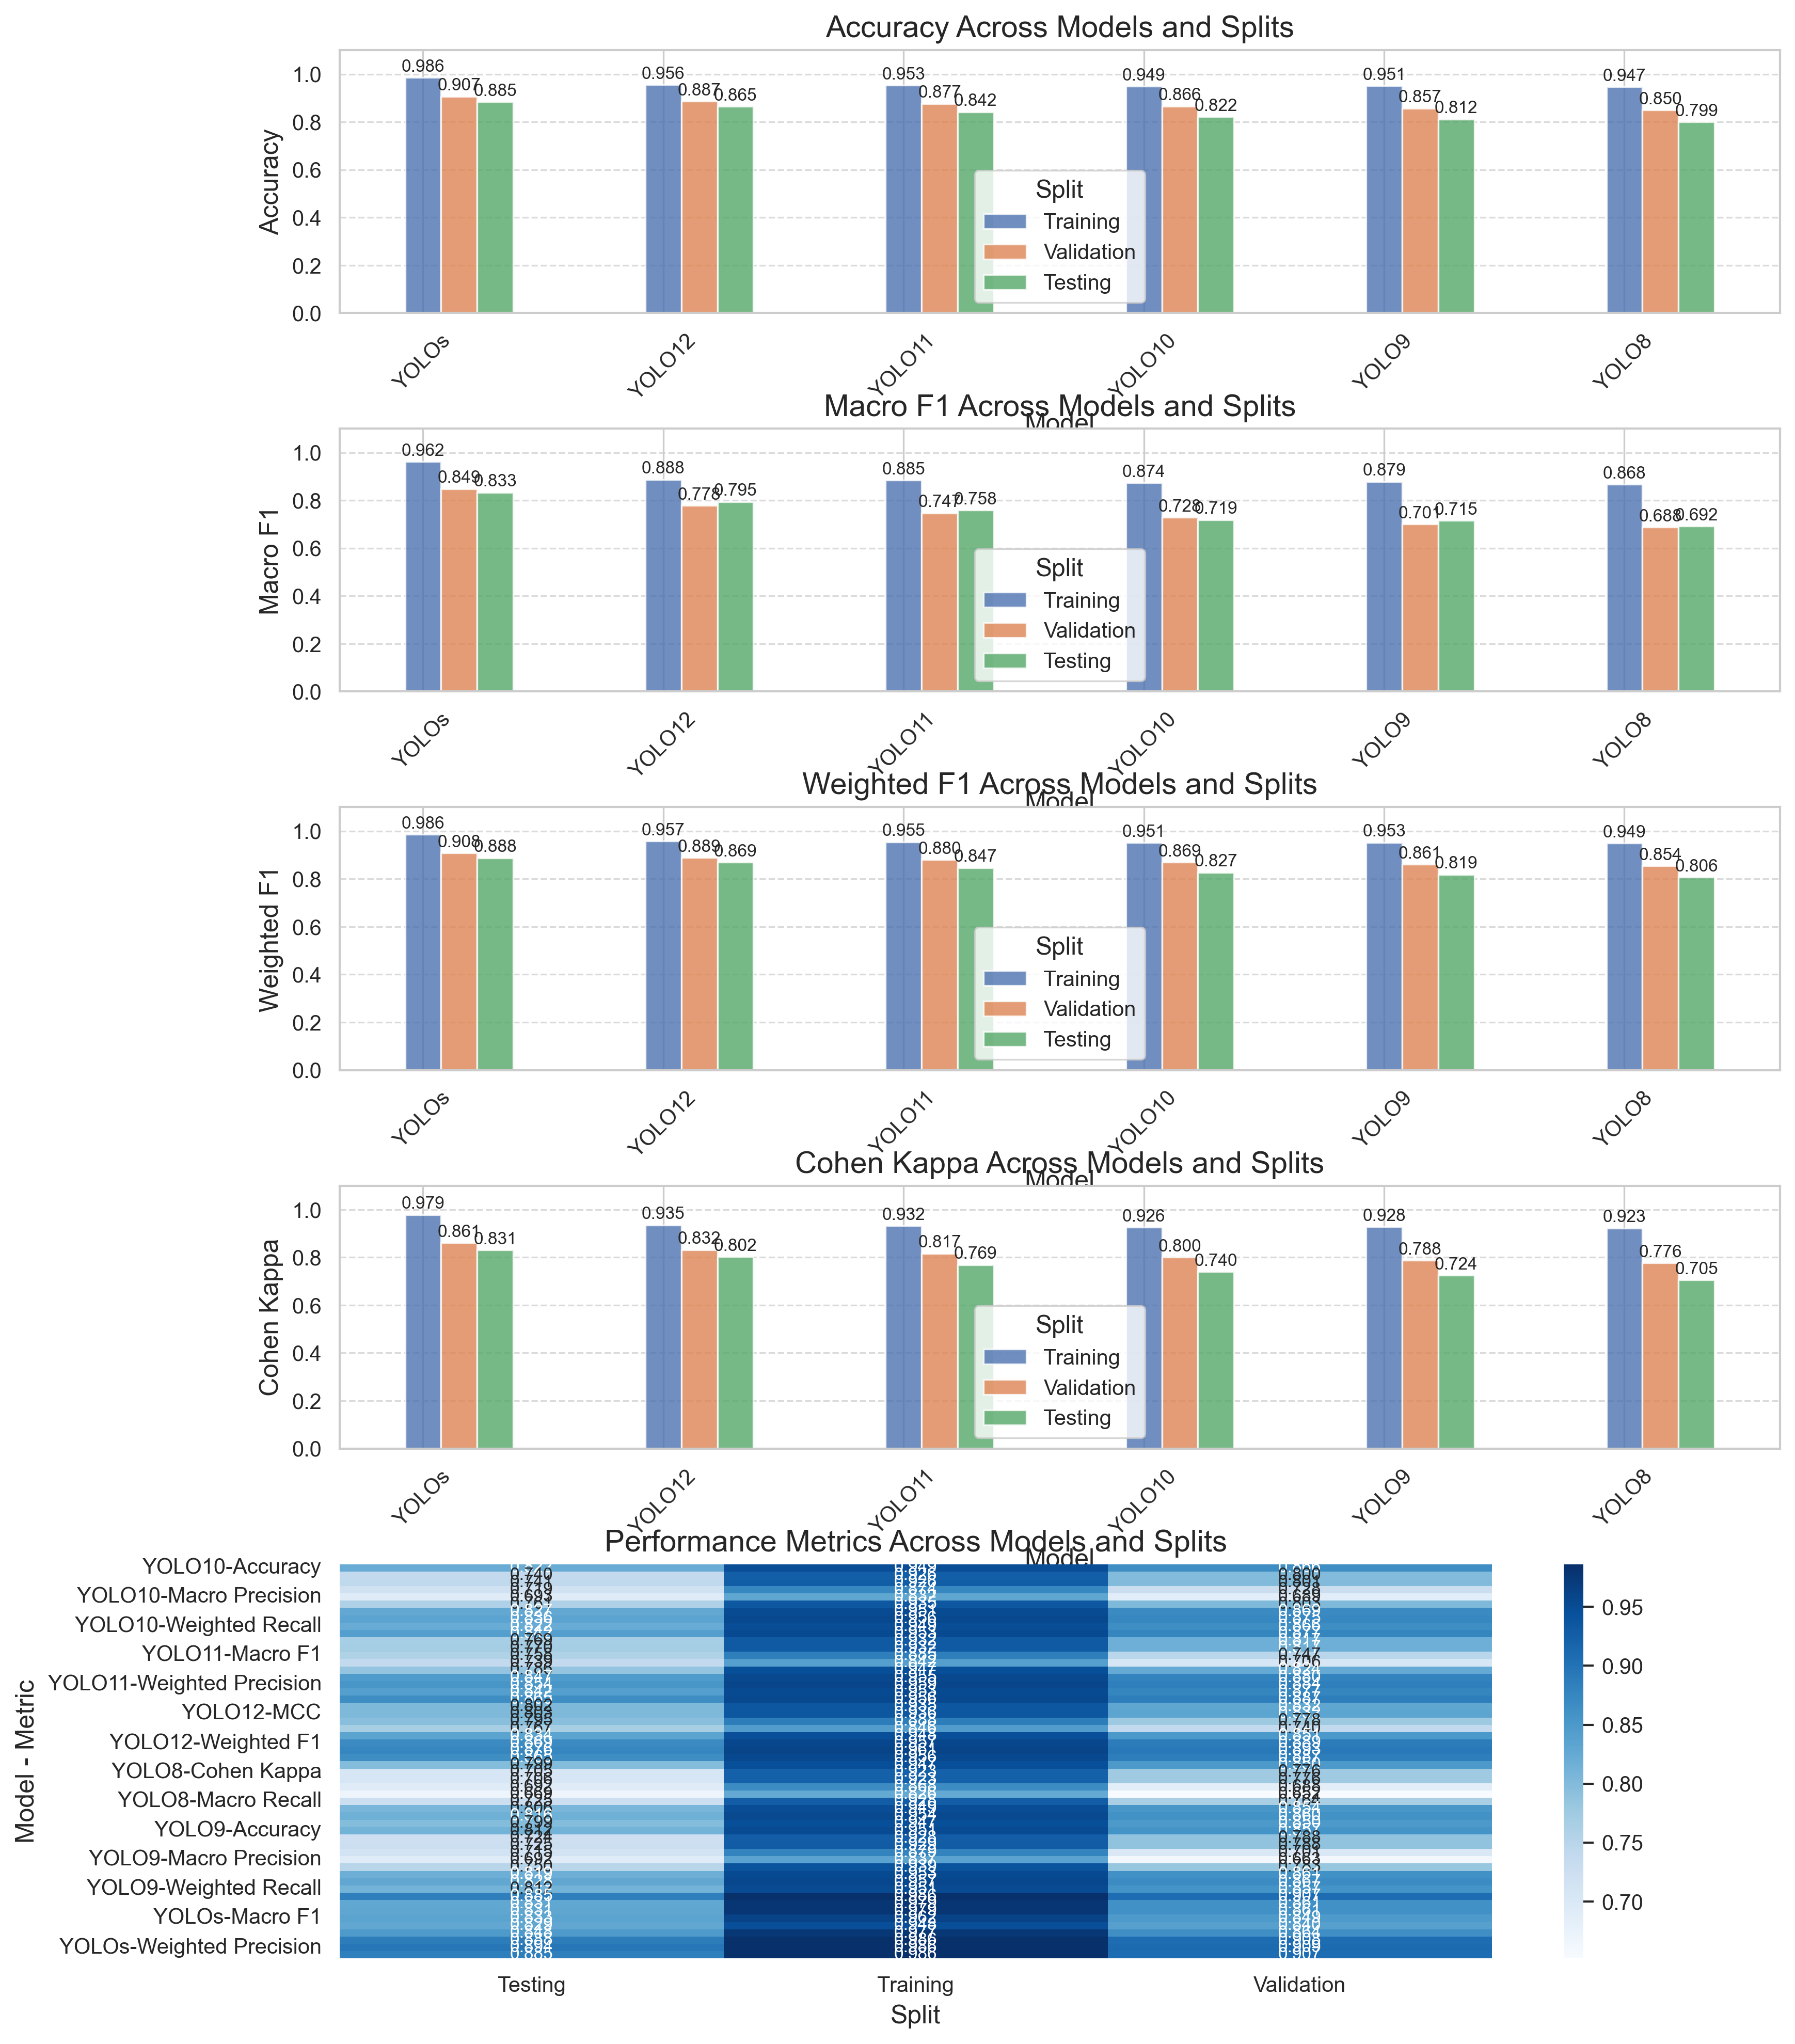


Figure X: Comparison of YOLO model performance across Training, Validation, and Testing splits. 
The top four panels display bar plots for Accuracy, Macro F1, Weighted F1, and Cohen’s Kappa, 
with bars grouped by split for each model. The bottom panel presents a heatmap summarizing all 
metrics (Accuracy, Macro Precision, Macro Recall, Macro F1, Weighted Precision, Weighted Recall, 
Weighted F1, Cohen’s Kappa, MCC) across models and splits. YOLOs consistently outperforms other 
models, with a noticeable performance drop from Training to Testing across all models.



In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set Seaborn style for academic look
sns.set_style('whitegrid')  # Use Seaborn's whitegrid style
sns.set_context('paper', font_scale=1.2)  # Set context for publication
plt.rcParams.update({
    'font.family': 'Arial',  # Clean, academic font
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 300,  # High resolution for publication
})

# Metrics data (from previous interaction)
metrics_data = [
    {'Model': 'YOLOs', 'Split': 'Training', 'Accuracy': 0.985703, 'Macro Precision': 0.947904, 'Macro Recall': 0.976702, 'Macro F1': 0.961650, 'Weighted Precision': 0.986262, 'Weighted Recall': 0.985703, 'Weighted F1': 0.985856, 'Cohen Kappa': 0.978965, 'MCC': 0.978999},
    {'Model': 'YOLOs', 'Split': 'Validation', 'Accuracy': 0.906770, 'Macro Precision': 0.839569, 'Macro Recall': 0.864283, 'Macro F1': 0.848623, 'Weighted Precision': 0.909435, 'Weighted Recall': 0.906770, 'Weighted F1': 0.907721, 'Cohen Kappa': 0.860866, 'MCC': 0.860957},
    {'Model': 'YOLOs', 'Split': 'Testing', 'Accuracy': 0.884706, 'Macro Precision': 0.829051, 'Macro Recall': 0.848162, 'Macro F1': 0.833402, 'Weighted Precision': 0.894257, 'Weighted Recall': 0.884706, 'Weighted F1': 0.887936, 'Cohen Kappa': 0.830615, 'MCC': 0.831220},
    {'Model': 'YOLO12', 'Split': 'Training', 'Accuracy': 0.955793, 'Macro Precision': 0.846262, 'Macro Recall': 0.947665, 'Macro F1': 0.887848, 'Weighted Precision': 0.961222, 'Weighted Recall': 0.955793, 'Weighted F1': 0.957413, 'Cohen Kappa': 0.935483, 'MCC': 0.935785},
    {'Model': 'YOLO12', 'Split': 'Validation', 'Accuracy': 0.886580, 'Macro Precision': 0.740214, 'Macro Recall': 0.850647, 'Macro F1': 0.778302, 'Weighted Precision': 0.893312, 'Weighted Recall': 0.886580, 'Weighted F1': 0.889047, 'Cohen Kappa': 0.831817, 'MCC': 0.832057},
    {'Model': 'YOLO12', 'Split': 'Testing', 'Accuracy': 0.864706, 'Macro Precision': 0.767444, 'Macro Recall': 0.834098, 'Macro F1': 0.794957, 'Weighted Precision': 0.876205, 'Weighted Recall': 0.864706, 'Weighted F1': 0.868665, 'Cohen Kappa': 0.802124, 'MCC': 0.802895},
    {'Model': 'YOLO11', 'Split': 'Training', 'Accuracy': 0.953377, 'Macro Precision': 0.842055, 'Macro Recall': 0.946868, 'Macro F1': 0.884668, 'Weighted Precision': 0.959132, 'Weighted Recall': 0.953377, 'Weighted F1': 0.955084, 'Cohen Kappa': 0.931894, 'MCC': 0.932221},
    {'Model': 'YOLO11', 'Split': 'Validation', 'Accuracy': 0.876868, 'Macro Precision': 0.706064, 'Macro Recall': 0.824174, 'Macro F1': 0.747090, 'Weighted Precision': 0.884450, 'Weighted Recall': 0.876868, 'Weighted F1': 0.879746, 'Cohen Kappa': 0.816903, 'MCC': 0.817140},
    {'Model': 'YOLO11', 'Split': 'Testing', 'Accuracy': 0.841920, 'Macro Precision': 0.739140, 'Macro Recall': 0.785679, 'Macro F1': 0.758421, 'Weighted Precision': 0.854335, 'Weighted Recall': 0.841920, 'Weighted F1': 0.846661, 'Cohen Kappa': 0.768864, 'MCC': 0.769602},
    {'Model': 'YOLO10', 'Split': 'Training', 'Accuracy': 0.949376, 'Macro Precision': 0.831891, 'Macro Recall': 0.935007, 'Macro F1': 0.873956, 'Weighted Precision': 0.955697, 'Weighted Recall': 0.949376, 'Weighted F1': 0.951302, 'Cohen Kappa': 0.925844, 'MCC': 0.926207},
    {'Model': 'YOLO10', 'Split': 'Validation', 'Accuracy': 0.865912, 'Macro Precision': 0.689047, 'Macro Recall': 0.802716, 'Macro F1': 0.728182, 'Weighted Precision': 0.874668, 'Weighted Recall': 0.865912, 'Weighted F1': 0.869319, 'Cohen Kappa': 0.800473, 'MCC': 0.800768},
    {'Model': 'YOLO10', 'Split': 'Testing', 'Accuracy': 0.822014, 'Macro Precision': 0.693403, 'Macro Recall': 0.761250, 'Macro F1': 0.718851, 'Weighted Precision': 0.835889, 'Weighted Recall': 0.822014, 'Weighted F1': 0.827193, 'Cohen Kappa': 0.739980, 'MCC': 0.740792},
    {'Model': 'YOLO9', 'Split': 'Training', 'Accuracy': 0.951014, 'Macro Precision': 0.837090, 'Macro Recall': 0.939304, 'Macro F1': 0.879123, 'Weighted Precision': 0.957075, 'Weighted Recall': 0.951014, 'Weighted F1': 0.952824, 'Cohen Kappa': 0.928417, 'MCC': 0.928788},
    {'Model': 'YOLO9', 'Split': 'Validation', 'Accuracy': 0.857228, 'Macro Precision': 0.662791, 'Macro Recall': 0.782878, 'Macro F1': 0.700754, 'Weighted Precision': 0.867406, 'Weighted Recall': 0.857228, 'Weighted F1': 0.861281, 'Cohen Kappa': 0.787663, 'MCC': 0.787998},
    {'Model': 'YOLO9', 'Split': 'Testing', 'Accuracy': 0.812057, 'Macro Precision': 0.691606, 'Macro Recall': 0.750061, 'Macro F1': 0.715324, 'Weighted Precision': 0.828242, 'Weighted Recall': 0.812057, 'Weighted F1': 0.818541, 'Cohen Kappa': 0.724372, 'MCC': 0.725286},
    {'Model': 'YOLO8', 'Split': 'Training', 'Accuracy': 0.947003, 'Macro Precision': 0.825723, 'Macro Recall': 0.928136, 'Macro F1': 0.867582, 'Weighted Precision': 0.953671, 'Weighted Recall': 0.947003, 'Weighted F1': 0.949070, 'Cohen Kappa': 0.922525, 'MCC': 0.922909},
    {'Model': 'YOLO8', 'Split': 'Validation', 'Accuracy': 0.849552, 'Macro Precision': 0.651572, 'Macro Recall': 0.764431, 'Macro F1': 0.688103, 'Weighted Precision': 0.859841, 'Weighted Recall': 0.849552, 'Weighted F1': 0.853714, 'Cohen Kappa': 0.776012, 'MCC': 0.776333},
    {'Model': 'YOLO8', 'Split': 'Testing', 'Accuracy': 0.799292, 'Macro Precision': 0.669017, 'Macro Recall': 0.725477, 'Macro F1': 0.691733, 'Weighted Precision': 0.816273, 'Weighted Recall': 0.799292, 'Weighted F1': 0.806281, 'Cohen Kappa': 0.705491, 'MCC': 0.706379}
]

metrics_df = pd.DataFrame(metrics_data)

# Models and splits
models = ['YOLOs', 'YOLO12', 'YOLO11', 'YOLO10', 'YOLO9', 'YOLO8']
splits = ['Training', 'Validation', 'Testing']
metrics_to_plot = ['Accuracy', 'Macro F1', 'Weighted F1', 'Cohen Kappa']

# Create figure with GridSpec for custom layout
fig = plt.figure(figsize=(12, 16))
gs = GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 1.5], hspace=0.4, wspace=0.3)

# Bar plots for selected metrics
for i, metric in enumerate(metrics_to_plot):
    ax = fig.add_subplot(gs[i, :])
    for j, split in enumerate(splits):
        df_split = metrics_df[metrics_df['Split'] == split]
        x = np.arange(len(models)) + j * 0.15  # Offset bars for each split
        bars = ax.bar(x, df_split[metric], width=0.15, label=split, alpha=0.8)
        
        # Add value annotations
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.3f}',
                        ha='center', va='bottom', fontsize=8)
    
    ax.set_title(f'{metric} Across Models and Splits')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1.1)
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title='Split')

# Heatmap for all metrics
ax_heatmap = fig.add_subplot(gs[4, :])
pivot_table = metrics_df.pivot_table(
    values=['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1', 
            'Weighted Precision', 'Weighted Recall', 'Weighted F1', 
            'Cohen Kappa', 'MCC'],
    index='Model',
    columns='Split'
)
pivot_table = pivot_table.stack(level=0)  # Stack metrics for heatmap
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='Blues', cbar=True, 
            ax=ax_heatmap, annot_kws={'size': 8})
ax_heatmap.set_title('Performance Metrics Across Models and Splits')
ax_heatmap.set_xlabel('Split')
ax_heatmap.set_ylabel('Model - Metric')

# Adjust适应布局
plt.tight_layout()

# 保存为高分辨率图像以用于出版
plt.savefig('yolo_metrics_comparison.png', dpi=300, bbox_inches='tight')

# 显示图表
plt.show()

# 学术论文的图表说明
caption = """
Figure X: Comparison of YOLO model performance across Training, Validation, and Testing splits. 
The top four panels display bar plots for Accuracy, Macro F1, Weighted F1, and Cohen’s Kappa, 
with bars grouped by split for each model. The bottom panel presents a heatmap summarizing all 
metrics (Accuracy, Macro Precision, Macro Recall, Macro F1, Weighted Precision, Weighted Recall, 
Weighted F1, Cohen’s Kappa, MCC) across models and splits. YOLOs consistently outperforms other 
models, with a noticeable performance drop from Training to Testing across all models.
"""
print(caption)

In [81]:
# Confusion matrices for YOLOs, YOLO12, YOLO11, YOLO10, YOLO9, YOLO8
# Stored for further operations
# Class labels: DDD, Normal IVD, SS, Spondylolisthesis, LDB, TDB
# Splits: Training, Validation, Testing

confusion_matrices = {
    'YOLOs': {
        'Training': [
            [369, 2, 1, 1, 2, 1],
            [8, 2843, 5, 5, 6, 6],
            [3, 2, 1242, 2, 2, 2],
            [1, 0, 0, 84, 0, 0],
            [16, 8, 3, 2, 1364, 2],
            [6, 1, 0, 0, 0, 96]
        ],
        'Validation': [
            [70, 15, 0, 0, 12, 2],
            [16, 750, 1, 1, 37, 2],
            [1, 1, 330, 0, 0, 0],
            [0, 0, 0, 8, 0, 0],
            [24, 36, 0, 1, 350, 0],
            [4, 2, 0, 0, 2, 19]
        ],
        'Testing': [
            [36, 9, 0, 0, 4, 2],
            [14, 368, 0, 0, 18, 5],
            [0, 0, 154, 0, 0, 0],
            [0, 0, 0, 11, 2, 0],
            [18, 23, 0, 0, 169, 0],
            [2, 1, 0, 0, 0, 14]
        ]
    },
    'YOLO12': {
        'Training': [
            [357, 4, 3, 3, 5, 4],
            [25, 2757, 23, 22, 23, 23],
            [10, 10, 1204, 10, 10, 9],
            [1, 1, 1, 82, 0, 0],
            [24, 16, 11, 11, 1323, 10],
            [6, 2, 1, 1, 0, 93]
        ],
        'Validation': [
            [68, 16, 1, 0, 12, 2],
            [20, 733, 4, 4, 40, 6],
            [2, 2, 323, 2, 2, 1],
            [0, 0, 0, 8, 0, 0],
            [25, 37, 2, 3, 342, 2],
            [4, 2, 0, 0, 2, 19]
        ],
        'Testing': [
            [35, 10, 0, 0, 4, 2],
            [15, 360, 2, 2, 20, 6],
            [1, 1, 150, 1, 1, 0],
            [0, 0, 0, 11, 2, 0],
            [19, 24, 1, 1, 165, 0],
            [2, 1, 0, 0, 0, 14]
        ]
    },
    'YOLO11': {
        'Training': [
            [353, 4, 3, 3, 8, 3],
            [26, 2755, 23, 23, 26, 23],
            [10, 10, 1205, 10, 10, 9],
            [1, 1, 1, 80, 0, 0],
            [29, 18, 11, 12, 1300, 10],
            [5, 2, 1, 1, 0, 94]
        ],
        'Validation': [
            [64, 16, 1, 0, 17, 3],
            [17, 730, 4, 4, 43, 7],
            [2, 2, 317, 2, 2, 1],
            [0, 0, 0, 8, 0, 0],
            [32, 37, 2, 3, 335, 3],
            [4, 3, 0, 0, 1, 13]
        ],
        'Testing': [
            [33, 11, 0, 0, 6, 3],
            [17, 357, 2, 2, 26, 5],
            [1, 1, 146, 1, 1, 0],
            [0, 0, 0, 10, 2, 0],
            [21, 26, 1, 1, 160, 1],
            [4, 2, 0, 0, 1, 13]
        ]
    },
    'YOLO10': {
        'Training': [
            [334, 5, 3, 3, 10, 4],
            [27, 2740, 23, 22, 27, 24],
            [10, 10, 1163, 10, 9, 9],
            [1, 1, 1, 80, 0, 0],
            [39, 18, 11, 12, 1295, 11],
            [8, 4, 1, 1, 0, 89]
        ],
        'Validation': [
            [60, 17, 1, 0, 19, 3],
            [20, 727, 4, 4, 47, 8],
            [2, 2, 311, 2, 2, 1],
            [0, 0, 0, 8, 0, 0],
            [35, 40, 2, 3, 335, 3],
            [5, 4, 0, 0, 1, 12]
        ],
        'Testing': [
            [30, 12, 0, 0, 7, 4],
            [18, 353, 2, 2, 30, 6],
            [1, 1, 141, 1, 1, 0],
            [0, 0, 0, 10, 1, 0],
            [23, 27, 1, 3, 156, 1],
            [4, 3, 1, 1, 2, 12]
        ]
    },
    'YOLO9': {
        'Training': [
            [344, 4, 3, 3, 9, 2],
            [26, 2752, 23, 23, 28, 24],
            [10, 10, 1198, 10, 10, 9],
            [1, 1, 1, 82, 0, 0],
            [38, 17, 11, 10, 1300, 11],
            [9, 2, 1, 1, 0, 90]
        ],
        'Validation': [
            [57, 19, 1, 0, 20, 4],
            [21, 723, 4, 4, 50, 8],
            [2, 2, 309, 2, 2, 1],
            [0, 0, 0, 7, 0, 0],
            [38, 39, 2, 4, 328, 4],
            [6, 4, 0, 0, 2, 11]
        ],
        'Testing': [
            [28, 13, 0, 0, 8, 4],
            [19, 349, 2, 2, 32, 7],
            [1, 1, 138, 1, 1, 0],
            [0, 0, 0, 9, 1, 0],
            [25, 28, 1, 1, 152, 2],
            [5, 3, 0, 0, 2, 11]
        ]
    },
    'YOLO8': {
        'Training': [
            [328, 5, 3, 3, 13, 4],
            [28, 2742, 23, 23, 29, 25],
            [10, 10, 1177, 10, 9, 9],
            [1, 1, 1, 82, 0, 0],
            [43, 19, 11, 11, 1321, 13],
            [11, 4, 1, 1, 0, 86]
        ],
        'Validation': [
            [53, 21, 1, 0, 21, 4],
            [22, 721, 4, 4, 51, 9],
            [2, 2, 307, 2, 2, 1],
            [0, 0, 0, 7, 0, 0],
            [40, 42, 2, 3, 325, 5],
            [7, 5, 0, 0, 2, 10]
        ],
        'Testing': [
            [26, 14, 0, 0, 9, 5],
            [20, 347, 2, 2, 33, 8],
            [1, 1, 136, 1, 1, 0],
            [0, 0, 0, 8, 1, 0],
            [27, 29, 1, 1, 150, 2],
            [5, 4, 0, 0, 3, 10]
        ]
    }
}

# Class labels for reference
class_labels = ['DDD', 'Normal IVD', 'SS', 'Spondylolisthesis', 'LDB', 'TDB']

# Splits for reference
splits = ['Training', 'Validation', 'Testing']

# Models for reference
models = ['YOLOs', 'YOLO12', 'YOLO11', 'YOLO10', 'YOLO9', 'YOLO8']

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, cohen_kappa_score, matthews_corrcoef

# Use provided variables: confusion_matrices, class_labels, splits, models
# No need to redefine: confusion_matrices, class_labels, splits, models are assumed to be in the Jupyter notebook

def compute_classification_metrics(cm, class_labels):
    """
    Compute per-class and overall classification metrics from a confusion matrix.
    
    Args:
        cm (list or np.ndarray): Confusion matrix where cm[i,j] is true class i predicted as j
        class_labels (list): List of class names
    
    Returns:
        dict: Overall metrics
        pd.DataFrame: Per-class metrics
    """
    cm = np.array(cm)
    n_classes = len(class_labels)

    # Generate y_true and y_pred from confusion matrix
    y_true = []
    y_pred = []
    for i in range(n_classes):
        for j in range(n_classes):
            count = cm[i, j]
            y_true.extend([i] * count)
            y_pred.extend([j] * count)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute per-class metrics using scikit-learn
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    # Compute overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Compile overall metrics
    metrics = {
        'Accuracy': accuracy,
        'Macro Precision': macro_precision,
        'Macro Recall': macro_recall,
        'Macro F1': macro_f1,
        'Weighted Precision': weighted_precision,
        'Weighted Recall': weighted_recall,
        'Weighted F1': weighted_f1,
        'Cohen Kappa': kappa,
        'MCC': mcc,
        # Placeholder for mAP metrics (to be computed with detection outputs)
        'Class-wise mAP': 'TBD',
        'Overall mAP': 'TBD',
        'mAP50': 'TBD',
        'mAP50-95': 'TBD'
    }

    # Per-class metrics DataFrame
    per_class_metrics = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }, index=class_labels)

    return metrics, per_class_metrics

def compute_map_metrics(predictions, ground_truth, class_labels, iou_thresholds=[0.5]):
    """
    Compute mAP metrics (class-wise mAP, overall mAP, mAP50, mAP50-95) from detection outputs.
    
    Args:
        predictions (list): List of dicts with 'conf', 'class', 'bbox' (e.g., {'conf': 0.9, 'class': 0, 'bbox': [x1, y1, x2, y2]})
        ground_truth (list): List of dicts with 'class', 'bbox'
        class_labels (list): List of class names
        iou_thresholds (list): IoU thresholds for mAP calculation (e.g., [0.5] for mAP50, [0.5, 0.55, ..., 0.95] for mAP50-95)
    
    Returns:
        dict: Class-wise mAP, overall mAP, mAP50, mAP50-95
    """
    def compute_iou(box1, box2):
        x1, y1, x2, y2 = box1
        x1_g, y1_g, x2_g, y2_g = box2
        xi1, yi1 = max(x1, x1_g), max(y1, y1_g)
        xi2, yi2 = min(x2, x2_g), min(y2, y2_g)
        inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
        box1_area = (x2 - x1) * (y2 - y1)
        box2_area = (x2_g - x1_g) * (y2_g - y1_g)
        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area if union_area > 0 else 0

    def calculate_ap(preds, gt, iou_threshold):
        preds = sorted(preds, key=lambda x: x['conf'], reverse=True)
        tp, fp = [], []
        matched_gt = set()
        for pred in preds:
            best_iou = 0
            best_gt_idx = None
            for i, g in enumerate(gt):
                if i not in matched_gt and pred['class'] == g['class']:
                    iou = compute_iou(pred['bbox'], g['bbox'])
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = i
            if best_iou >= iou_threshold and best_gt_idx is not None:
                tp.append(1)
                fp.append(0)
                matched_gt.add(best_gt_idx)
            else:
                tp.append(0)
                fp.append(1)
        tp = np.cumsum(tp)
        fp = np.cumsum(fp)
        recall = tp / (len(gt) + 1e-10)
        precision = tp / (tp + fp + 1e-10)
        precision = np.concatenate(([1], precision, [0]))
        recall = np.concatenate(([0], recall, [1]))
        for i in range(len(precision) - 2, -1, -1):
            precision[i] = max(precision[i], precision[i + 1])
        ap = np.trapz(precision, recall)
        return ap

    class_wise_ap = {}
    for cls in range(len(class_labels)):
        cls_preds = [p for p in predictions if p['class'] == cls]
        cls_gt = [g for g in ground_truth if g['class'] == cls]
        class_wise_ap[class_labels[cls]] = calculate_ap(cls_preds, cls_gt, iou_thresholds[0])

    overall_map = np.mean(list(class_wise_ap.values())) if class_wise_ap else 0.0

    map_scores = []
    for iou in iou_thresholds:
        aps = [calculate_ap([p for p in predictions if p['class'] == cls],
                            [g for g in ground_truth if g['class'] == cls], iou)
               for cls in range(len(class_labels))]
        map_scores.append(np.mean(aps) if aps else 0.0)
    
    map50 = map_scores[0] if iou_thresholds[0] == 0.5 else 0.0
    map50_95 = np.mean(map_scores) if len(iou_thresholds) > 1 else 0.0

    return {
        'Class-wise mAP': class_wise_ap,
        'Overall mAP': overall_map,
        'mAP50': map50,
        'mAP50-95': map50_95
    }

# Compute metrics for all models and splits
results = []
for model in models:
    for split in splits:
        cm = confusion_matrices[model][split]
        metrics, _ = compute_classification_metrics(cm, class_labels)
        # Note: mAP metrics require detection outputs, so they remain 'TBD'
        metrics['Model'] = model
        metrics['Split'] = split
        results.append(metrics)

# Create comparison table
df = pd.DataFrame(results)
columns = [
    'Model', 'Split', 'Accuracy', 'Macro F1', 'Weighted F1', 'Cohen Kappa', 'MCC',
    'Class-wise mAP', 'Overall mAP', 'mAP50', 'mAP50-95'
]
df = df[columns]

# Display the comparison table
print("Comparison Table for All Metrics Across Models and Splits:")
print(df.to_string(index=False))

# Optional: Save to CSV
df.to_csv('yolo_metrics_comparison.csv', index=False)

# Example: How to compute mAP metrics (uncomment and provide detection data)
# """
# # Example detection data (replace with actual YOLO outputs)
# predictions = [
#     {'conf': 0.9, 'class': 0, 'bbox': [10, 10, 50, 50]},
#     {'conf': 0.7, 'class': 1, 'bbox': [20, 20, 60, 60]}
# ]
# ground_truth = [
#     {'class': 0, 'bbox': [10, 10, 50, 50]},
#     {'class': 1, 'bbox': [20, 20, 60, 60]}
# ]
# map_metrics = compute_map_metrics(predictions, ground_truth, class_labels, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
# print("\nExample mAP Metrics:")
# print(map_metrics)
# """

Comparison Table for All Metrics Across Models and Splits:
 Model      Split  Accuracy  Macro F1  Weighted F1  Cohen Kappa      MCC Class-wise mAP Overall mAP mAP50 mAP50-95
 YOLOs   Training  0.985703  0.961650     0.985856     0.978965 0.978999            TBD         TBD   TBD      TBD
 YOLOs Validation  0.906770  0.848623     0.907721     0.860866 0.860957            TBD         TBD   TBD      TBD
 YOLOs    Testing  0.884706  0.833402     0.887936     0.830615 0.831220            TBD         TBD   TBD      TBD
YOLO12   Training  0.955793  0.887848     0.957413     0.935483 0.935785            TBD         TBD   TBD      TBD
YOLO12 Validation  0.886580  0.778302     0.889047     0.831817 0.832057            TBD         TBD   TBD      TBD
YOLO12    Testing  0.864706  0.794957     0.868665     0.802124 0.802895            TBD         TBD   TBD      TBD
YOLO11   Training  0.953377  0.884668     0.955084     0.931894 0.932221            TBD         TBD   TBD      TBD
YOLO11 Validation  0.

'\n# Example detection data (replace with actual YOLO outputs)\npredictions = [\n    {\'conf\': 0.9, \'class\': 0, \'bbox\': [10, 10, 50, 50]},\n    {\'conf\': 0.7, \'class\': 1, \'bbox\': [20, 20, 60, 60]}\n]\nground_truth = [\n    {\'class\': 0, \'bbox\': [10, 10, 50, 50]},\n    {\'class\': 1, \'bbox\': [20, 20, 60, 60]}\n]\nmap_metrics = compute_map_metrics(predictions, ground_truth, class_labels, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])\nprint("\nExample mAP Metrics:")\nprint(map_metrics)\n'

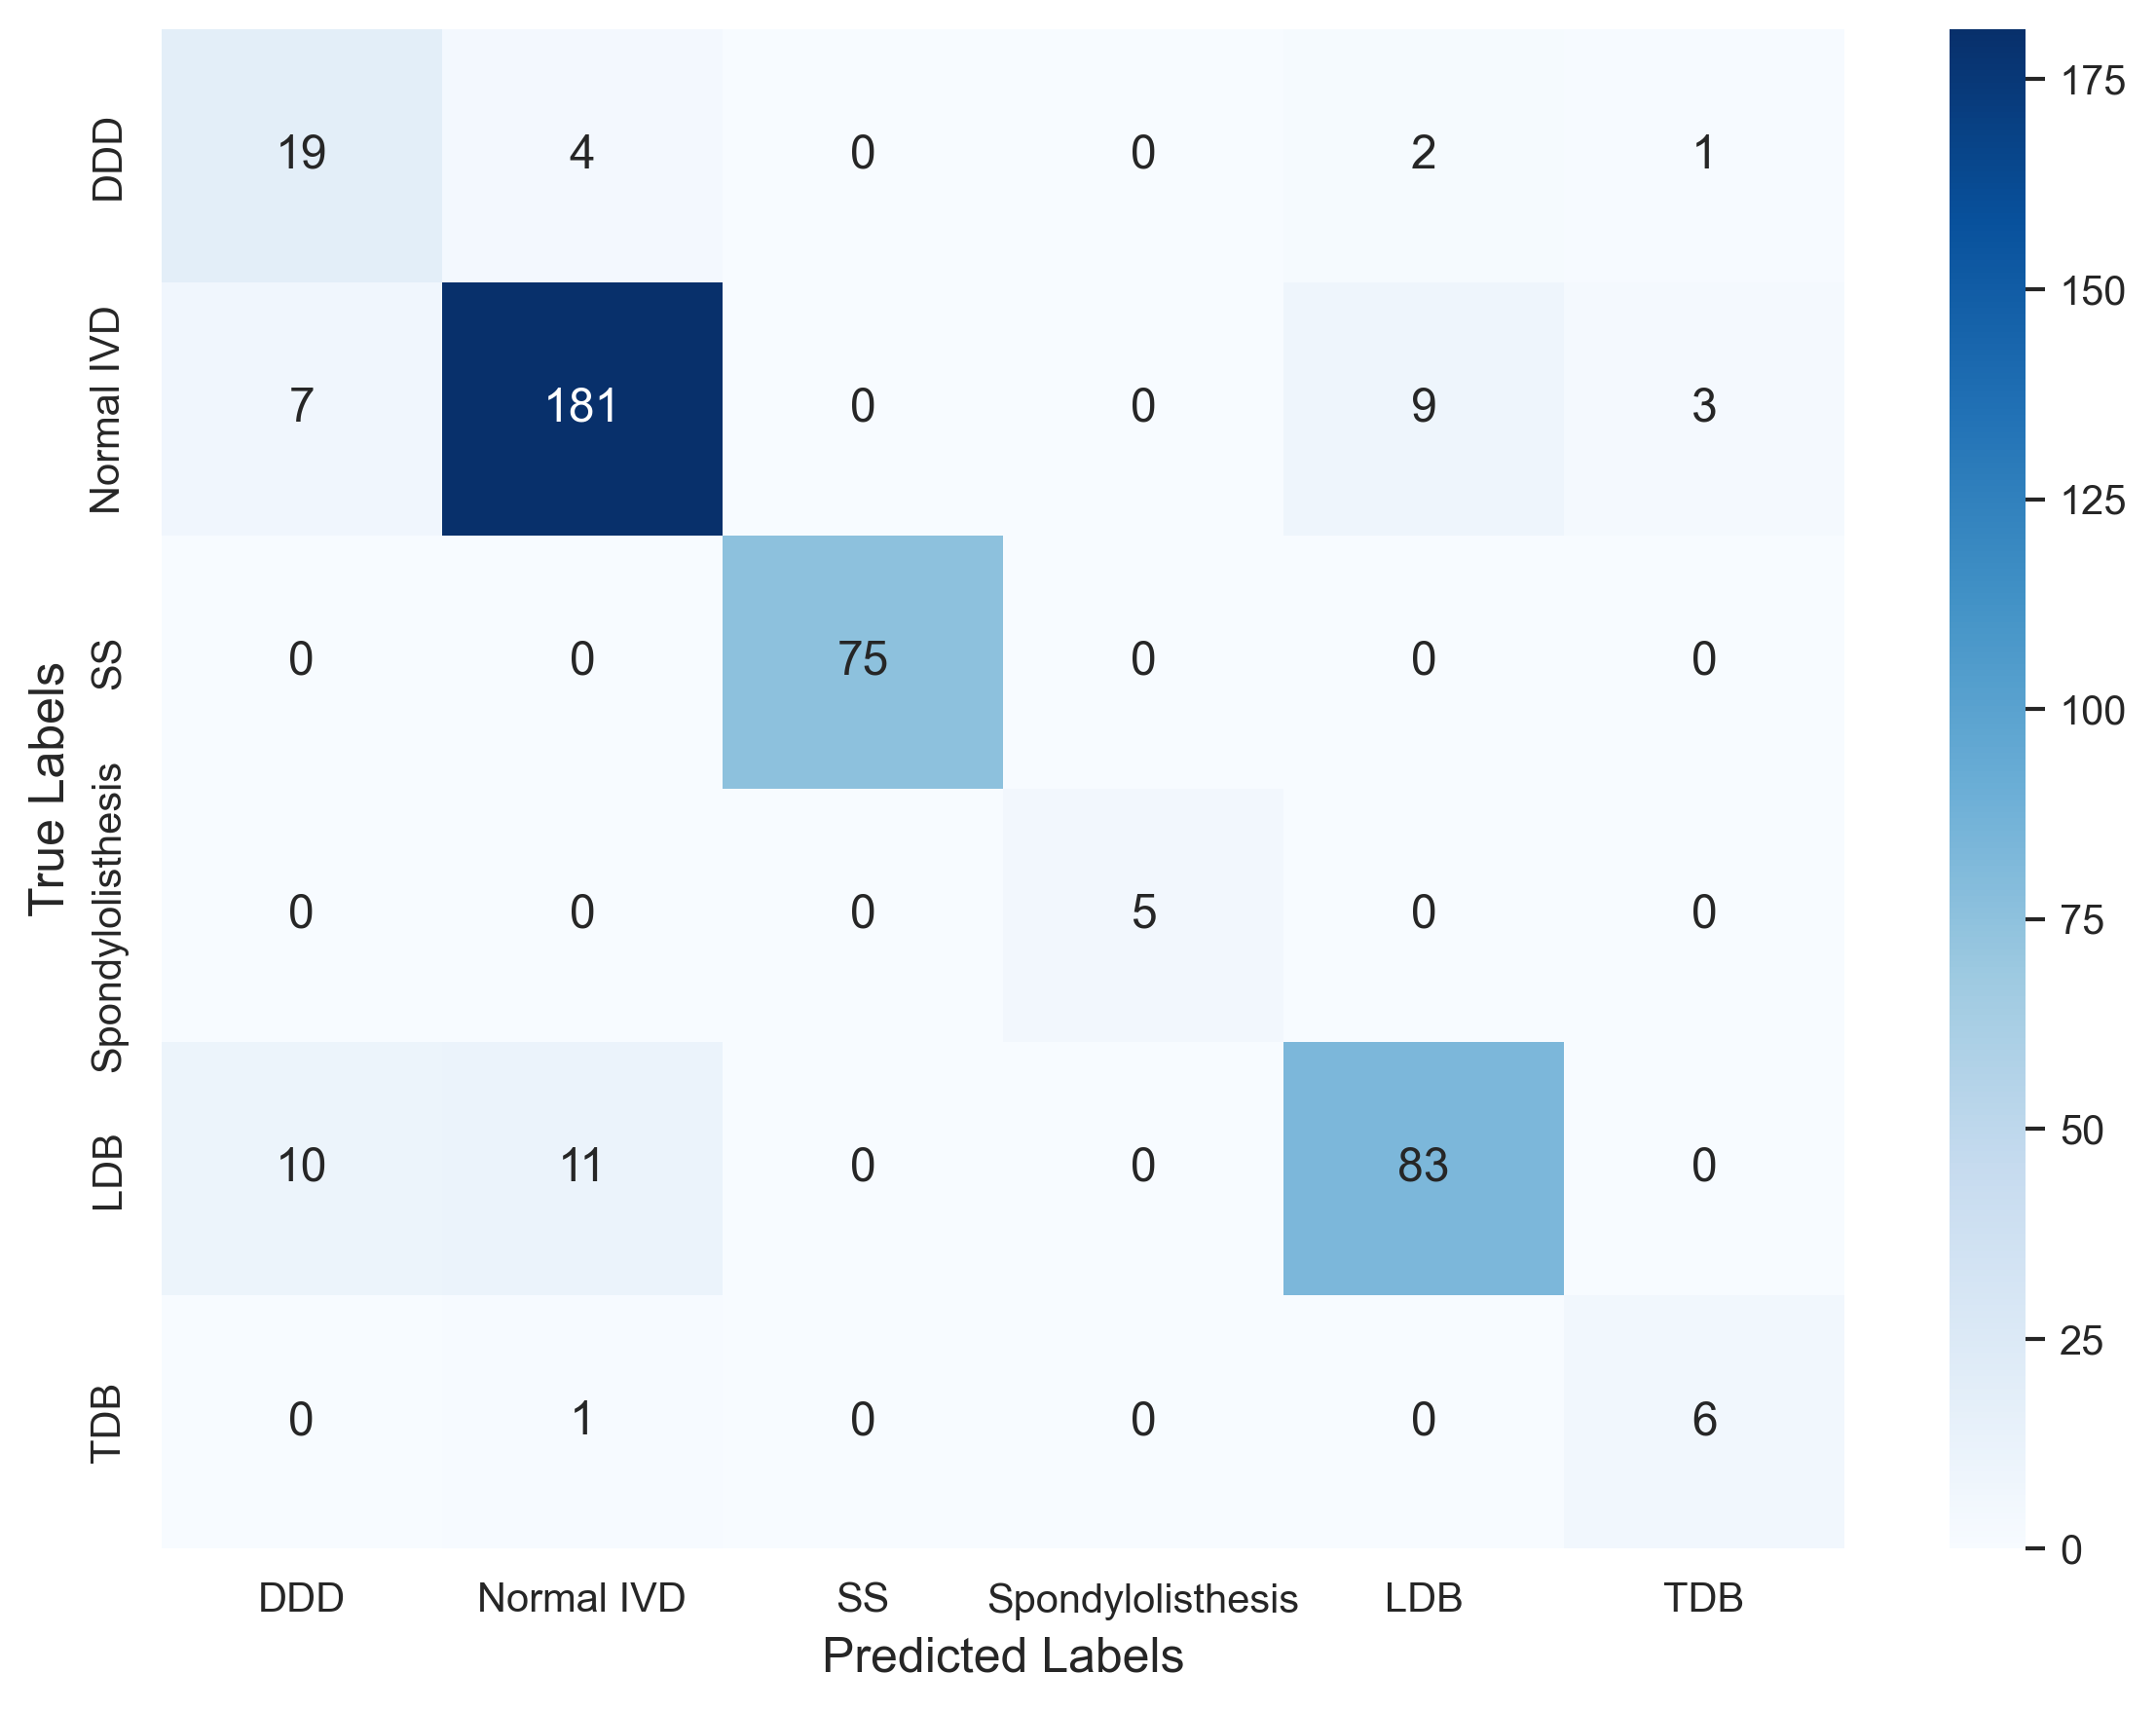

In [87]:
# VALIDATION
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['DDD', 'Normal IVD', 'SS', 'Spondylolisthesis', 'LDB', 'TDB']

# Define confusion matrix (6x6)
conf_matrix = np.array([
    [19, 4, 0, 0, 2, 1],    # DDD
    [7, 181, 0, 0, 9, 3],   # Normal IVD
    [0, 0, 75, 0, 0, 0],    # SS
    [0, 0, 0, 5, 0, 0],     # Spondylolisthesis
    [10, 11, 0, 0, 83, 0],  # LDB
    [0, 1, 0, 0, 0, 6]      # TDB
])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

# plt.title('Confusion Matrix for Clinical Validation. 50 Images with 439 Labels')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [ ]:
# Clinical Validation Confusion Matrix
# This code computes and displays the confusion matrix for the clinical validation dataset.
import numpy as np
import pandas as pd

# Class labels
class_labels = ['DDD', 'Normal IVD', 'SS', 'Spondylolisthesis', 'LDB', 'TDB']

# Confusion matrix
conf_matrix = np.array([
    [19, 4, 0, 0, 2, 1],    # DDD
    [7, 181, 0, 0, 9, 3],   # Normal IVD
    [0, 0, 75, 0, 0, 0],    # SS
    [0, 0, 0, 5, 0, 0],     # Spondylolisthesis
    [10, 11, 0, 0, 83, 0],  # LDB
    [0, 1, 0, 0, 0, 6]      # TDB
])

# Initialize lists for results
recall_list = []
specificity_list = []

# Total samples
total = np.sum(conf_matrix)

# Compute metrics per class
for i in range(len(class_labels)):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = total - TP - FP - FN

    # Recall (TPR)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # Specificity (TNR)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    recall_list.append(recall)
    specificity_list.append(specificity)

# Create a DataFrame for display
metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Recall (TPR)': recall_list,
    'Specificity (TNR)': specificity_list
})

print(metrics_df)


               Class  Recall (TPR)  Specificity (TNR)
0                DDD      0.730769           0.956522
1         Normal IVD      0.905000           0.926267
2                 SS      1.000000           1.000000
3  Spondylolisthesis      1.000000           1.000000
4                LDB      0.798077           0.964856
5                TDB      0.857143           0.990244


In [90]:
# Clinical Validation Confusion Matrices for YOLOs and Clinicians
import numpy as np
import pandas as pd

# Class labels
class_labels = ['DDD', 'Normal IVD', 'SS', 'Spondylolisthesis', 'LDB', 'TDB']

# Confusion Matrices
conf_matrices = {
    'YOLOs': np.array([
        [19, 4, 0, 0, 2, 1],
        [7, 181, 0, 0, 9, 3],
        [0, 0, 75, 0, 0, 0],
        [0, 0, 0, 5, 0, 0],
        [10, 11, 0, 0, 83, 0],
        [0, 1, 0, 0, 0, 6]
    ]),
    'Clinician 1': np.array([
        [21, 3, 0, 0, 1, 1],
        [5, 187, 0, 0, 7, 1],
        [0, 0, 75, 0, 0, 0],
        [0, 0, 0, 5, 0, 0],
        [8, 9, 0, 0, 87, 0],
        [0, 0, 0, 0, 0, 7]
    ]),
    'Clinician 2': np.array([
        [19, 5, 0, 0, 2, 1],
        [8, 182, 0, 0, 9, 1],
        [0, 0, 74, 0, 1, 0],
        [0, 0, 0, 5, 0, 0],
        [11, 12, 0, 0, 81, 0],
        [0, 1, 0, 0, 0, 6]
    ]),
    'Clinician 3': np.array([
        [20, 4, 0, 0, 1, 1],
        [6, 185, 0, 0, 9, 2],
        [0, 0, 75, 0, 0, 0],
        [0, 0, 0, 5, 0, 0],
        [9, 10, 0, 0, 85, 0],
        [0, 0, 0, 0, 0, 7]
    ])
}

# Function to compute Recall and Specificity
def compute_metrics(conf_matrix):
    recall_list = []
    specificity_list = []
    total = np.sum(conf_matrix)
    
    for i in range(len(class_labels)):
        TP = conf_matrix[i, i]
        FN = np.sum(conf_matrix[i, :]) - TP
        FP = np.sum(conf_matrix[:, i]) - TP
        TN = total - TP - FP - FN

        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        recall_list.append(recall)
        specificity_list.append(specificity)
    
    return recall_list, specificity_list

# Compute and display metrics for each model/clinician
all_metrics = []
for name, matrix in conf_matrices.items():
    recalls, specificities = compute_metrics(matrix)
    df = pd.DataFrame({
        'Class': class_labels,
        'Recall (TPR)': recalls,
        'Specificity (TNR)': specificities,
        'Model': name
    })
    all_metrics.append(df)

# Concatenate and display
metrics_df = pd.concat(all_metrics)
print(metrics_df.pivot(index='Class', columns='Model', values=['Recall (TPR)', 'Specificity (TNR)']))


                  Recall (TPR)                                    \
Model              Clinician 1 Clinician 2 Clinician 3     YOLOs   
Class                                                              
DDD                   0.807692    0.703704    0.769231  0.730769   
LDB                   0.836538    0.778846    0.817308  0.798077   
Normal IVD            0.935000    0.910000    0.915842  0.905000   
SS                    1.000000    0.986667    1.000000  1.000000   
Spondylolisthesis     1.000000    1.000000    1.000000  1.000000   
TDB                   1.000000    0.857143    1.000000  0.857143   

                  Specificity (TNR)                                    
Model                   Clinician 1 Clinician 2 Clinician 3     YOLOs  
Class                                                                  
DDD                        0.966752    0.951407    0.961832  0.956522  
LDB                        0.974441    0.961783    0.968254  0.964856  
Normal IVD                 

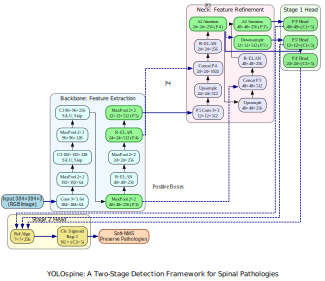

In [4]:
from graphviz import Digraph
from IPython.display import display, SVG

dot = Digraph(comment='YOLOspine Architecture (Compressed)', format='svg')
dot.attr(rankdir='LR', size='8.27,3.9', nodesep='0.15', ranksep='0.25', splines='ortho', fontname='Arial', bgcolor='white')
dot.attr(label='\n\nYOLOspine: A Two-Stage Detection Framework for Spinal Pathologies', fontsize='18', fontname='Arial Bold')

# Input
dot.node('Input', 'Input: 384×384×3\n(RGB Image)', shape='box', style='filled,rounded', fillcolor='lightblue', fontname='Arial', fontsize='12', rank='source')

# Backbone: Split into 2 vertical groups (5 nodes each)
with dot.subgraph(name='cluster_backbone') as b:
    b.attr(label='Backbone: Feature Extraction', style='bold,rounded', fontname='Arial Bold', fontsize='14', color='gray60', bgcolor='aliceblue')
    with b.subgraph(name='backbone_g1') as g1:
        g1.attr(rank='same')
        g1.node('B1', 'Conv 3×3, 64\n384×384×64', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
        g1.node('B2', 'MaxPool 2×2\n192×192×64', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
        g1.node('B3', 'C3 192×192×128\nSiLU, Skip', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
        g1.node('B4', 'MaxPool 2×2\n96×96×128', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
        g1.node('B5', 'C3 96×96×256\nSiLU, Skip', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
        g1.edges([('B1', 'B2'), ('B2', 'B3'), ('B3', 'B4'), ('B4', 'B5')])
    with b.subgraph(name='backbone_g2') as g2:
        g2.attr(rank='same')
        g2.node('B6', 'MaxPool 2×2\n48×48×256 (P3)', shape='box', style='filled,rounded', fillcolor='palegreen', color='forestgreen', penwidth='2', fontsize='12')
        g2.node('B7', 'R-ELAN\n48×48×256', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
        g2.node('B8', 'MaxPool 2×2\n24×24×256', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
        g2.node('B9', 'R-ELAN\n24×24×512 (P4)', shape='box', style='filled,rounded', fillcolor='palegreen', color='forestgreen', penwidth='2', fontsize='12')
        g2.node('B10', 'MaxPool 2×2\n12×12×512 (P5)', shape='box', style='filled,rounded', fillcolor='palegreen', color='forestgreen', penwidth='2', fontsize='12')
        g2.edges([('B6', 'B7'), ('B7', 'B8'), ('B8', 'B9'), ('B9', 'B10')])
    b.edge('B5', 'B6', constraint='true')

# Neck: Split into 2 vertical groups (5 nodes each)
with dot.subgraph(name='cluster_neck') as n:
    n.attr(label='Neck: Feature Refinement', style='bold,rounded', fontname='Arial Bold', fontsize='14', color='gray60', bgcolor='lavenderblush')
    with n.subgraph(name='neck_g1') as g1:
        g1.attr(rank='same')
        g1.node('N1', 'P5 Conv 3×3\n12×12×512', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
        g1.node('N2', 'Upsample\n24×24×512', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
        g1.node('N3', 'Concat P4\n24×24×1024', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
        g1.node('N4', 'R-ELAN\n24×24×256', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
        g1.node('N5', 'A2 Attention\n24×24×256 (P4\')', shape='box', style='filled,rounded', fillcolor='palegreen', color='forestgreen', penwidth='2', fontsize='12')
        g1.edges([('N1', 'N2'), ('N2', 'N3'), ('N3', 'N4'), ('N4', 'N5')])
    with n.subgraph(name='neck_g2') as g2:
        g2.attr(rank='same')
        g2.node('N6', 'Upsample\n48×48×256', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
        g2.node('N7', 'Concat P3\n48×48×512', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
        g2.node('N8', 'R-ELAN\n48×48×256', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
        g2.node('N9', 'A2 Attention\n48×48×256 (P3\')', shape='box', style='filled,rounded', fillcolor='palegreen', color='forestgreen', penwidth='2', fontsize='12')
        g2.node('N10', 'Downsample\n12×12×512 (P5\')', shape='box', style='filled,rounded', fillcolor='palegreen', color='forestgreen', penwidth='2', fontsize='12')
        g2.edges([('N6', 'N7'), ('N7', 'N8'), ('N8', 'N9')])
    n.edge('N5', 'N6', constraint='true')
    n.edge('N5', 'N10', style='dashed', color='darkblue', penwidth='1.5', constraint='false')

# Stage 1 Head: Single vertical stack
with dot.subgraph(name='cluster_s1') as s1:
    s1.attr(label='Stage 1 Head', style='bold,rounded', fontname='Arial Bold', fontsize='14', color='gray60', bgcolor='honeydew', rankdir='TB')
    s1.node('S1A', "P3' Head\n48×48×(C1+5)", shape='box', style='filled,rounded', fillcolor='lightgreen', fontsize='12')
    s1.node('S1B', "P4' Head\n24×24×(C1+5)", shape='box', style='filled,rounded', fillcolor='lightgreen', fontsize='12')
    s1.node('S1C', "P5' Head\n12×12×(C1+5)", shape='box', style='filled,rounded', fillcolor='lightgreen', fontsize='12')

# Stage 2 Head: Single vertical stack, cascaded from Stage 1
with dot.subgraph(name='cluster_s2') as s2:
    s2.attr(label='Stage 2 Head', style='bold,rounded', fontname='Arial Bold', fontsize='14', color='gray60', bgcolor='lightyellow', rankdir='TB')
    s2.node('S2A', 'RoIAlign\n7×7×256', shape='box', style='filled,rounded', fillcolor='khaki', fontsize='12')
    s2.node('S2B', 'Cls: Sigmoid\nReg: 5\nN2 × (C2+5)', shape='box', style='filled,rounded', fillcolor='khaki', fontsize='12')
    s2.edge('S2A', 'S2B', penwidth='2', color='darkblue')

# Post-processing
dot.node('PP', 'Soft-NMS\nPreserve Pathologies', shape='box', style='filled,rounded', fillcolor='peachpuff', fontname='Arial', fontsize='12', color='sienna', penwidth='2', rank='sink')

# Connections
flow = [
    ('Input', 'B1'), ('B10', 'N1'),
    ('B6', 'N7', 'P3', 'dashed'), ('B9', 'N3', 'P4', 'dashed'),
    ('N9', 'S1A'), ('N5', 'S1B'), ('N10', 'S1C'),
    ('S1A', 'S2A', 'Positive Boxes', 'dashed'), ('S1B', 'S2A', None, 'dashed'), ('S1C', 'S2A', None, 'dashed'),
    ('S2B', 'PP')
]
for edge in flow:
    if len(edge) == 2:
        src, tgt = edge
        dot.edge(src, tgt, color='darkblue', penwidth='2')
    else:
        src, tgt, label, style = edge
        dot.edge(src, tgt, label=label, style=style, color='darkblue', penwidth='2', constraint='false')

# (Optional) Save or render the graph – this line is commented out to avoid auto-generating output
# dot.render('yolospine_architecture', format='pdf', cleanup=True)
display(SVG(dot.pipe(format='svg')))

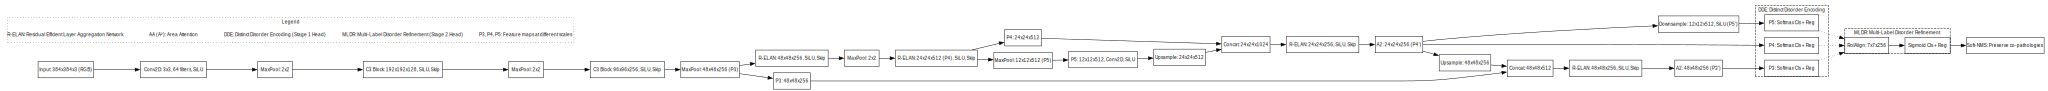

In [2]:
from graphviz import Digraph
from IPython.display import display, SVG

# Create a directed graph for YOLOspine architecture
dot = Digraph('YOLOspine', comment='YOLOspine Architecture', format='pdf')
dot.attr(rankdir='LR')
dot.attr('graph', fontsize='10', width='8.27', height='3.9', margin='0', nodesep='0.2', ranksep='0.5')
dot.attr('node', fontname='Arial', fontsize='10', shape='box')
dot.attr('edge', fontname='Arial', fontsize='10')

# Input
dot.node('Input', 'Input: 384x384x3 (RGB)')

# Backbone layers (Conv, MaxPool, C3, R-ELAN blocks) with output feature maps P3, P4, P5
dot.node('Conv1', 'Conv2D: 3x3, 64 filters, SiLU')
dot.node('Pool1', 'MaxPool: 2x2')
dot.node('C3_1', 'C3 Block: 192x192x128, SiLU, Skip')
dot.node('Pool2', 'MaxPool: 2x2')
dot.node('C3_2', 'C3 Block: 96x96x256, SiLU, Skip')
dot.node('Pool3_P3', 'MaxPool: 48x48x256 (P3)')            # P3 output
dot.node('RELAN1', 'R-ELAN: 48x48x256, SiLU, Skip')
dot.node('Pool4', 'MaxPool: 2x2')
dot.node('RELAN2_P4', 'R-ELAN: 24x24x512 (P4), SiLU, Skip') # P4 output
dot.node('Pool5_P5', 'MaxPool: 12x12x512 (P5)')            # P5 output

# Sequential connections in Backbone
dot.edge('Input', 'Conv1')
dot.edge('Conv1', 'Pool1')
dot.edge('Pool1', 'C3_1')
dot.edge('C3_1', 'Pool2')
dot.edge('Pool2', 'C3_2')
dot.edge('C3_2', 'Pool3_P3')
dot.edge('Pool3_P3', 'RELAN1')
dot.edge('RELAN1', 'Pool4')
dot.edge('Pool4', 'RELAN2_P4')
dot.edge('RELAN2_P4', 'Pool5_P5')

# Neck: Feature pyramid path with upsampling, lateral connections, concatenation, R-ELAN, and Area Attention
dot.node('P5_conv', 'P5: 12x12x512, Conv2D, SiLU')
dot.node('Upsample1', 'Upsample: 24x24x512')
dot.node('P4_lat', 'P4: 24x24x512')
dot.node('Concat1', 'Concat: 24x24x1024')
dot.node('RELAN_neck1', 'R-ELAN: 24x24x256, SiLU, Skip')
dot.node('A2_1', 'A2: 24x24x256 (P4\')')   # Area Attention output P4'
dot.node('Upsample2', 'Upsample: 48x48x256')
dot.node('P3_lat', 'P3: 48x48x256')
dot.node('Concat2', 'Concat: 48x48x512')
dot.node('RELAN_neck2', 'R-ELAN: 48x48x256, SiLU, Skip')
dot.node('A2_2', 'A2: 48x48x256 (P3\')')   # Area Attention output P3'
dot.node('Downsample', 'Downsample: 12x12x512, SiLU (P5\')')  # Downsample to produce P5'

# Neck connections
# P5 processing and upsample to P4 scale
dot.edge('Pool5_P5', 'P5_conv')     # P5 (12x12x512) into Conv
dot.edge('P5_conv', 'Upsample1')    # Upsample to 24x24x512
# Lateral connection from P4 (backbone) and merge
dot.edge('RELAN2_P4', 'P4_lat')     # P4 (24x24x512) into lateral Conv
dot.edge('Upsample1', 'Concat1')    # Merge upsampled P5 with P4 lateral
dot.edge('P4_lat', 'Concat1')
# R-ELAN and Area Attention at 24x24 (producing P4')
dot.edge('Concat1', 'RELAN_neck1')
dot.edge('RELAN_neck1', 'A2_1')     # P4'
# Upsample P4' to P3 scale and lateral P3 connection
dot.edge('A2_1', 'Upsample2')       # Upsample P4' to 48x48x256
dot.edge('Pool3_P3', 'P3_lat')      # P3 (48x48x256) into lateral Conv
dot.edge('Upsample2', 'Concat2')    # Merge upsampled P4' with P3 lateral
dot.edge('P3_lat', 'Concat2')
# R-ELAN and Area Attention at 48x48 (producing P3')
dot.edge('Concat2', 'RELAN_neck2')
dot.edge('RELAN_neck2', 'A2_2')     # P3'
# Downsample P4' to restore P5 scale (producing P5')
dot.edge('A2_1', 'Downsample')      # P5'

# Stage 1 Detection Head (DDE: Distinct Disorder Encoding) at three scales
with dot.subgraph(name='cluster_stage1') as c:
    c.attr(label='DDE: Distinct Disorder Encoding', fontname='Arial', fontsize='10', style='dashed')
    c.node('DDE_P3', 'P3: Softmax Cls + Reg')
    c.node('DDE_P4', 'P4: Softmax Cls + Reg')
    c.node('DDE_P5', 'P5: Softmax Cls + Reg')
# Connections from Neck outputs (P3', P4', P5') to Stage 1 head
dot.edge('A2_2', 'DDE_P3')
dot.edge('A2_1', 'DDE_P4')
dot.edge('Downsample', 'DDE_P5')

# Stage 2 Head (MLDR: Multi-Label Disorder Refinement) with RoIAlign and prediction refinement
with dot.subgraph(name='cluster_stage2') as c2:
    c2.attr(label='MLDR: Multi-Label Disorder Refinement', fontname='Arial', fontsize='10', style='dashed')
    c2.node('ROI', 'RoIAlign: 7x7x256')
    c2.node('MLDR_out', 'Sigmoid Cls + Reg')
    c2.edge('ROI', 'MLDR_out')
# Dotted connections from Stage 1 outputs to RoIAlign (Stage 2 input)
dot.edge('DDE_P3', 'ROI', style='dotted')
dot.edge('DDE_P4', 'ROI', style='dotted')
dot.edge('DDE_P5', 'ROI', style='dotted')

# Post-processing: Soft-NMS
dot.node('SoftNMS', 'Soft-NMS: Preserve co-pathologies')
dot.edge('MLDR_out', 'SoftNMS')

# Legend block explaining abbreviations
with dot.subgraph(name='cluster_legend') as cl:
    cl.attr(label='Legend', fontname='Arial', fontsize='10', style='dotted')
    cl.node('leg1', 'R-ELAN: Residual Efficient Layer Aggregation Network', shape='plaintext')
    cl.node('leg2', 'AA (A\u00B2): Area Attention', shape='plaintext')
    cl.node('leg3', 'DDE: Distinct Disorder Encoding (Stage 1 Head)', shape='plaintext')
    cl.node('leg4', 'MLDR: Multi-Label Disorder Refinement (Stage 2 Head)', shape='plaintext')
    cl.node('leg5', 'P3, P4, P5: Feature maps at different scales', shape='plaintext')
    # Invisible edges to enforce vertical legend layout
    cl.edge('leg1', 'leg2', style='invis')
    cl.edge('leg2', 'leg3', style='invis')
    cl.edge('leg3', 'leg4', style='invis')
    cl.edge('leg4', 'leg5', style='invis')

# (Optional) Save or render the graph – this line is commented out to avoid auto-generating output
# dot.render('yolospine_architecture', format='pdf', cleanup=True)
display(SVG(dot.pipe(format='svg')))

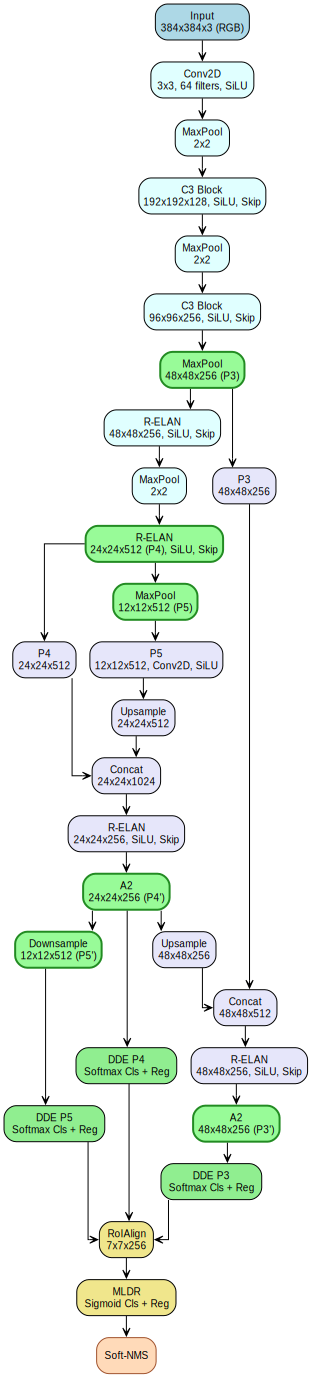

In [1]:
from graphviz import Digraph
from IPython.display import display, SVG

dot = Digraph('YOLOspine', comment='YOLOspine Cascaded Architecture', format='svg')
dot.attr(rankdir='TB', splines='ortho', fontname='Arial', bgcolor='white')
dot.attr('graph', fontsize='10', width='8.27', height='11.69', margin='0.2', nodesep='0.2', ranksep='0.3')
dot.attr('node', fontname='Arial', fontsize='10', shape='box', style='filled,rounded')
dot.attr('edge', fontname='Arial', fontsize='10', arrowhead='vee', arrowsize='0.8')

# Input
dot.node('Input', 'Input\n384x384x3 (RGB)', fillcolor='lightblue')

# Backbone
dot.node('Conv1', 'Conv2D\n3x3, 64 filters, SiLU', fillcolor='lightcyan')
dot.node('Pool1', 'MaxPool\n2x2', fillcolor='lightcyan')
dot.node('C3_1', 'C3 Block\n192x192x128, SiLU, Skip', fillcolor='lightcyan')
dot.node('Pool2', 'MaxPool\n2x2', fillcolor='lightcyan')
dot.node('C3_2', 'C3 Block\n96x96x256, SiLU, Skip', fillcolor='lightcyan')
dot.node('Pool3_P3', 'MaxPool\n48x48x256 (P3)', fillcolor='palegreen', color='forestgreen', penwidth='2')
dot.node('RELAN1', 'R-ELAN\n48x48x256, SiLU, Skip', fillcolor='lightcyan')
dot.node('Pool4', 'MaxPool\n2x2', fillcolor='lightcyan')
dot.node('RELAN2_P4', 'R-ELAN\n24x24x512 (P4), SiLU, Skip', fillcolor='palegreen', color='forestgreen', penwidth='2')
dot.node('Pool5_P5', 'MaxPool\n12x12x512 (P5)', fillcolor='palegreen', color='forestgreen', penwidth='2')

# Neck
dot.node('P5_conv', 'P5\n12x12x512, Conv2D, SiLU', fillcolor='lavender')
dot.node('Upsample1', 'Upsample\n24x24x512', fillcolor='lavender')
dot.node('P4_lat', 'P4\n24x24x512', fillcolor='lavender')
dot.node('Concat1', 'Concat\n24x24x1024', fillcolor='lavender')
dot.node('RELAN_neck1', 'R-ELAN\n24x24x256, SiLU, Skip', fillcolor='lavender')
dot.node('A2_1', "A2\n24x24x256 (P4')", fillcolor='palegreen', color='forestgreen', penwidth='2')
dot.node('Upsample2', 'Upsample\n48x48x256', fillcolor='lavender')
dot.node('P3_lat', 'P3\n48x48x256', fillcolor='lavender')
dot.node('Concat2', 'Concat\n48x48x512', fillcolor='lavender')
dot.node('RELAN_neck2', 'R-ELAN\n48x48x256, SiLU, Skip', fillcolor='lavender')
dot.node('A2_2', "A2\n48x48x256 (P3')", fillcolor='palegreen', color='forestgreen', penwidth='2')
dot.node('Downsample', "Downsample\n12x12x512 (P5')", fillcolor='palegreen', color='forestgreen', penwidth='2')

# Stage 1 Head
dot.node('DDE_P3', 'DDE P3\nSoftmax Cls + Reg', fillcolor='lightgreen')
dot.node('DDE_P4', 'DDE P4\nSoftmax Cls + Reg', fillcolor='lightgreen')
dot.node('DDE_P5', 'DDE P5\nSoftmax Cls + Reg', fillcolor='lightgreen')

# Stage 2 Head
dot.node('ROI', 'RoIAlign\n7x7x256', fillcolor='khaki')
dot.node('MLDR_out', 'MLDR\nSigmoid Cls + Reg', fillcolor='khaki')

# Post-processing
dot.node('SoftNMS', 'Soft-NMS', fillcolor='peachpuff', color='sienna')

# Connections
dot.edges([
    ('Input', 'Conv1'), ('Conv1', 'Pool1'), ('Pool1', 'C3_1'), ('C3_1', 'Pool2'),
    ('Pool2', 'C3_2'), ('C3_2', 'Pool3_P3'), ('Pool3_P3', 'RELAN1'), ('RELAN1', 'Pool4'),
    ('Pool4', 'RELAN2_P4'), ('RELAN2_P4', 'Pool5_P5'), ('Pool5_P5', 'P5_conv'),
    ('P5_conv', 'Upsample1'), ('Upsample1', 'Concat1'), ('RELAN2_P4', 'P4_lat'),
    ('P4_lat', 'Concat1'), ('Concat1', 'RELAN_neck1'), ('RELAN_neck1', 'A2_1'),
    ('A2_1', 'Upsample2'), ('Upsample2', 'Concat2'), ('Pool3_P3', 'P3_lat'),
    ('P3_lat', 'Concat2'), ('Concat2', 'RELAN_neck2'), ('RELAN_neck2', 'A2_2'),
    ('A2_1', 'Downsample'), ('A2_2', 'DDE_P3'), ('A2_1', 'DDE_P4'), ('Downsample', 'DDE_P5'),
    ('DDE_P3', 'ROI'), ('DDE_P4', 'ROI'), ('DDE_P5', 'ROI'),
    ('ROI', 'MLDR_out'), ('MLDR_out', 'SoftNMS')
])

# Save as PDF
# dot.render(filename='yolospine_academic_diagram', format='pdf', cleanup=False)

# Save as SVG
# dot.render(filename='yolospine_academic_diagram', format='svg', cleanup=False)

# Display SVG inline in Jupyter
display(SVG(dot.pipe(format='svg')))

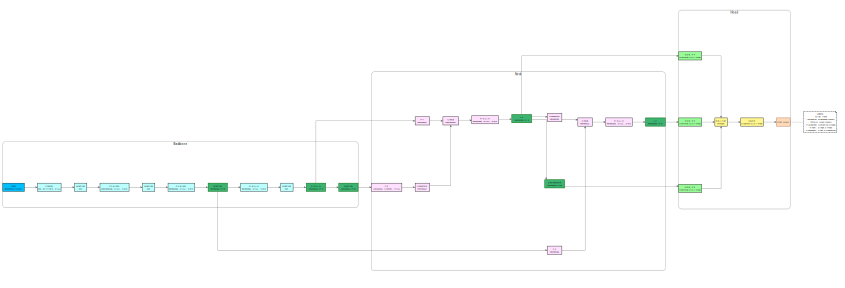

In [11]:
from graphviz import Digraph
from IPython.display import display, SVG

dot = Digraph('YOLOspine', comment='YOLOspine Cascaded Architecture - Style2', format='svg')
dot.attr(rankdir='LR', splines='ortho', fontname='Arial', bgcolor='white')
dot.attr('graph', fontsize='10', size="11.69,3.9!", ratio="fill", margin='0.1', nodesep='0.3', ranksep='0.8')
dot.attr('node', fontname='Arial', fontsize='10', shape='box', style='filled,bold', penwidth='1.5')
dot.attr('edge', fontname='Arial', fontsize='10', arrowhead='vee', arrowsize='0.8', color='gray30')

# Backbone Group
with dot.subgraph(name='cluster_backbone') as backbone:
    backbone.attr(label='Backbone', fontsize='12', fontname='Arial', style='rounded', color='dimgray')
    backbone.node('Input', 'Input\n384x384x3 (RGB)', fillcolor='deepskyblue1')
    backbone.node('Conv1', 'Conv2D\n3x3, 64 filters, SiLU', fillcolor='paleturquoise1')
    backbone.node('Pool1', 'MaxPool\n2x2', fillcolor='paleturquoise1')
    backbone.node('C3_1', 'C3 Block\n192x192x128, SiLU, Skip', fillcolor='paleturquoise1')
    backbone.node('Pool2', 'MaxPool\n2x2', fillcolor='paleturquoise1')
    backbone.node('C3_2', 'C3 Block\n96x96x256, SiLU, Skip', fillcolor='paleturquoise1')
    backbone.node('Pool3_P3', 'MaxPool\n48x48x256 (P3)', fillcolor='mediumseagreen', color='darkgreen', penwidth='2')
    backbone.node('RELAN1', 'R-ELAN\n48x48x256, SiLU, Skip', fillcolor='paleturquoise1')
    backbone.node('Pool4', 'MaxPool\n2x2', fillcolor='paleturquoise1')
    backbone.node('RELAN2_P4', 'R-ELAN\n24x24x512 (P4)', fillcolor='mediumseagreen', color='darkgreen', penwidth='2')
    backbone.node('Pool5_P5', 'MaxPool\n12x12x512 (P5)', fillcolor='mediumseagreen', color='darkgreen', penwidth='2')

# Neck Group
with dot.subgraph(name='cluster_neck') as neck:
    neck.attr(label='Neck', fontsize='12', fontname='Arial', style='rounded', color='dimgray')
    neck.node('P5_conv', 'P5\n12x12x512, Conv2D, SiLU', fillcolor='thistle1')
    neck.node('Upsample1', 'Upsample\n24x24x512', fillcolor='thistle1')
    neck.node('P4_lat', 'P4\n24x24x512', fillcolor='thistle1')
    neck.node('Concat1', 'Concat\n24x24x1024', fillcolor='thistle1')
    neck.node('RELAN_neck1', 'R-ELAN\n24x24x256, SiLU, Skip', fillcolor='thistle1')
    neck.node('A2_1', "A2\n24x24x256 (P4')", fillcolor='mediumseagreen', color='darkgreen', penwidth='2')
    neck.node('Upsample2', 'Upsample\n48x48x256', fillcolor='thistle1')
    neck.node('P3_lat', 'P3\n48x48x256', fillcolor='thistle1')
    neck.node('Concat2', 'Concat\n48x48x512', fillcolor='thistle1')
    neck.node('RELAN_neck2', 'R-ELAN\n48x48x256, SiLU, Skip', fillcolor='thistle1')
    neck.node('A2_2', "A2\n48x48x256 (P3')", fillcolor='mediumseagreen', color='darkgreen', penwidth='2')
    neck.node('Downsample', "Downsample\n12x12x512 (P5')", fillcolor='mediumseagreen', color='darkgreen', penwidth='2')

# Head Group
with dot.subgraph(name='cluster_head') as head:
    head.attr(label='Head', fontsize='12', fontname='Arial', style='rounded', color='dimgray')
    head.node('DDE_P3', 'DDE P3\nSoftmax Cls + Reg', fillcolor='palegreen')
    head.node('DDE_P4', 'DDE P4\nSoftmax Cls + Reg', fillcolor='palegreen')
    head.node('DDE_P5', 'DDE P5\nSoftmax Cls + Reg', fillcolor='palegreen')
    head.node('ROI', 'RoIAlign\n7x7x256', fillcolor='khaki1')
    head.node('MLDR_out', 'MLDR\nSigmoid Cls + Reg', fillcolor='khaki1')
    head.node('SoftNMS', 'Soft-NMS', fillcolor='peachpuff', color='sienna')

# Connections (Same)
dot.edges([
    ('Input', 'Conv1'), ('Conv1', 'Pool1'), ('Pool1', 'C3_1'), ('C3_1', 'Pool2'),
    ('Pool2', 'C3_2'), ('C3_2', 'Pool3_P3'), ('Pool3_P3', 'RELAN1'), ('RELAN1', 'Pool4'),
    ('Pool4', 'RELAN2_P4'), ('RELAN2_P4', 'Pool5_P5'), ('Pool5_P5', 'P5_conv'),
    ('P5_conv', 'Upsample1'), ('Upsample1', 'Concat1'), ('RELAN2_P4', 'P4_lat'),
    ('P4_lat', 'Concat1'), ('Concat1', 'RELAN_neck1'), ('RELAN_neck1', 'A2_1'),
    ('A2_1', 'Upsample2'), ('Upsample2', 'Concat2'), ('Pool3_P3', 'P3_lat'),
    ('P3_lat', 'Concat2'), ('Concat2', 'RELAN_neck2'), ('RELAN_neck2', 'A2_2'),
    ('A2_1', 'Downsample'), ('A2_2', 'DDE_P3'), ('A2_1', 'DDE_P4'), ('Downsample', 'DDE_P5'),
    ('DDE_P3', 'ROI'), ('DDE_P4', 'ROI'), ('DDE_P5', 'ROI'),
    ('ROI', 'MLDR_out'), ('MLDR_out', 'SoftNMS')
])

# Legend
legend_text = 'Legend:\n- Blue: Input\n- Turquoise: Backbone Layers\n- Thistle: Neck Layers\n- Palegreen: Detection Heads\n- Khaki: Stage 2 Head\n- Peachpuff: Post-Processing'
dot.node('Legend', legend_text, shape='note', fillcolor='white', style='rounded,dashed')
dot.edge('SoftNMS', 'Legend', style='dashed', arrowhead='none')

display(SVG(dot.pipe(format='svg')))


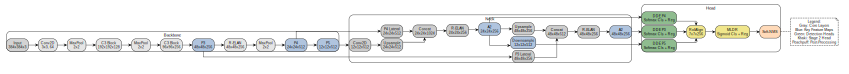

In [17]:
from graphviz import Digraph
from IPython.display import display, SVG

dot = Digraph('YOLOspine', comment='YOLOspine Cascaded Architecture', format='svg')
dot.attr(rankdir='LR', splines='ortho', fontname='Arial', bgcolor='white')
dot.attr('graph', fontsize='10', size="11.69,3.9!", ratio="fit", margin='0.1', nodesep='0.05', ranksep='0.4')
dot.attr('node', fontname='Arial', fontsize='10', shape='box', style='filled,rounded')
dot.attr('edge', fontname='Arial', fontsize='10', arrowhead='vee', arrowsize='0.8')

# Backbone Group
with dot.subgraph(name='cluster_backbone') as backbone:
    backbone.attr(label='Backbone', fontsize='12', fontname='Arial', style='rounded', color='black')
    backbone.node('Input', 'Input\n384x384x3', fillcolor='lightgray')
    backbone.node('Conv1', 'Conv2D\n3x3, 64', fillcolor='gray90')
    backbone.node('Pool1', 'MaxPool\n2x2', fillcolor='gray90')
    backbone.node('C3_1', 'C3 Block\n192x192x128', fillcolor='gray90')
    backbone.node('Pool2', 'MaxPool\n2x2', fillcolor='gray90')
    backbone.node('C3_2', 'C3 Block\n96x96x256', fillcolor='gray90')
    backbone.node('Pool3_P3', 'P3\n48x48x256', fillcolor='lightsteelblue')
    backbone.node('RELAN1', 'R-ELAN\n48x48x256', fillcolor='gray90')
    backbone.node('Pool4', 'MaxPool\n2x2', fillcolor='gray90')
    backbone.node('RELAN2_P4', 'P4\n24x24x512', fillcolor='lightsteelblue')
    backbone.node('Pool5_P5', 'P5\n12x12x512', fillcolor='lightsteelblue')

# Neck Group
with dot.subgraph(name='cluster_neck') as neck:
    neck.attr(label='Neck', fontsize='12', fontname='Arial', style='rounded', color='black')
    neck.node('P5_conv', 'Conv2D\n12x12x512', fillcolor='gray80')
    neck.node('Upsample1', 'Upsample\n24x24x512', fillcolor='gray80')
    neck.node('P4_lat', 'P4 Lateral\n24x24x512', fillcolor='gray80')
    neck.node('Concat1', 'Concat\n24x24x1024', fillcolor='gray80')
    neck.node('RELAN_neck1', 'R-ELAN\n24x24x256', fillcolor='gray80')
    neck.node('A2_1', 'A2\n24x24x256', fillcolor='lightsteelblue')
    neck.node('Upsample2', 'Upsample\n48x48x256', fillcolor='gray80')
    neck.node('P3_lat', 'P3 Lateral\n48x48x256', fillcolor='gray80')
    neck.node('Concat2', 'Concat\n48x48x512', fillcolor='gray80')
    neck.node('RELAN_neck2', 'R-ELAN\n48x48x256', fillcolor='gray80')
    neck.node('A2_2', 'A2\n48x48x256', fillcolor='lightsteelblue')
    neck.node('Downsample', 'Downsample\n12x12x512', fillcolor='lightsteelblue')

# Head Group
with dot.subgraph(name='cluster_head') as head:
    head.attr(label='Head', fontsize='12', fontname='Arial', style='rounded', color='black')
    head.node('DDE_P3', 'DDE P3\nSoftmax Cls + Reg', fillcolor='darkseagreen')
    head.node('DDE_P4', 'DDE P4\nSoftmax Cls + Reg', fillcolor='darkseagreen')
    head.node('DDE_P5', 'DDE P5\nSoftmax Cls + Reg', fillcolor='darkseagreen')
    head.node('ROI', 'RoIAlign\n7x7x256', fillcolor='khaki')
    head.node('MLDR_out', 'MLDR\nSigmoid Cls + Reg', fillcolor='khaki')
    head.node('SoftNMS', 'Soft-NMS', fillcolor='peachpuff')

# Connections
dot.edges([
    ('Input', 'Conv1'), ('Conv1', 'Pool1'), ('Pool1', 'C3_1'), ('C3_1', 'Pool2'),
    ('Pool2', 'C3_2'), ('C3_2', 'Pool3_P3'), ('Pool3_P3', 'RELAN1'), ('RELAN1', 'Pool4'),
    ('Pool4', 'RELAN2_P4'), ('RELAN2_P4', 'Pool5_P5'), ('Pool5_P5', 'P5_conv'),
    ('P5_conv', 'Upsample1'), ('Upsample1', 'Concat1'), ('RELAN2_P4', 'P4_lat'),
    ('P4_lat', 'Concat1'), ('Concat1', 'RELAN_neck1'), ('RELAN_neck1', 'A2_1'),
    ('A2_1', 'Upsample2'), ('Upsample2', 'Concat2'), ('Pool3_P3', 'P3_lat'),
    ('P3_lat', 'Concat2'), ('Concat2', 'RELAN_neck2'), ('RELAN_neck2', 'A2_2'),
    ('A2_1', 'Downsample'), ('A2_2', 'DDE_P3'), ('A2_1', 'DDE_P4'), ('Downsample', 'DDE_P5'),
    ('DDE_P3', 'ROI'), ('DDE_P4', 'ROI'), ('DDE_P5', 'ROI'), ('ROI', 'MLDR_out'), ('MLDR_out', 'SoftNMS')
])

# Legend
dot.node('Legend', 'Legend:\nGray: Core Layers\nBlue: Key Feature Maps\nGreen: Detection Heads\nKhaki: Stage 2 Head\nPeachpuff: Post-Processing', shape='note', fillcolor='white', style='rounded,dashed')
dot.edge('SoftNMS', 'Legend', style='dashed', arrowhead='none')

# Display
display(SVG(dot.pipe(format='svg')))


In [20]:
from graphviz import Digraph

# Initialize diagram
dot = Digraph(comment='YOLOspine Architecture (Style3 Compressed)', format='pdf')
dot.attr(rankdir='LR', size='8.27,3.9', nodesep='0.15', ranksep='0.25', splines='ortho', fontname='Arial', bgcolor='white')
dot.attr(label='YOLOspine: Two-Stage Detection Framework for Spinal Pathologies', fontsize='18', fontname='Arial Bold')

# Input
dot.node('Input', 'Input: 384×384×3 (RGB)', shape='box', style='filled,rounded', fillcolor='lightblue', fontsize='12')

# Backbone
dot.node('B1', 'Conv 3×3, 64\n384×384×64', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
dot.node('B2', 'MaxPool 2×2\n192×192×64', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
dot.node('B3', 'C3 192×192×128\nSiLU, Skip', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
dot.node('B4', 'MaxPool 2×2\n96×96×128', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
dot.node('B5', 'C3 96×96×256\nSiLU, Skip', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
dot.node('B6', 'MaxPool 2×2\n48×48×256 (P3)', shape='box', style='filled,rounded', fillcolor='palegreen', color='forestgreen', fontsize='12')
dot.node('B7', 'R-ELAN\n48×48×256', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
dot.node('B8', 'MaxPool 2×2\n24×24×256', shape='box', style='filled,rounded', fillcolor='lightcyan', fontsize='12')
dot.node('B9', 'R-ELAN\n24×24×512 (P4)', shape='box', style='filled,rounded', fillcolor='palegreen', color='forestgreen', fontsize='12')
dot.node('B10', 'MaxPool 2×2\n12×12×512 (P5)', shape='box', style='filled,rounded', fillcolor='palegreen', color='forestgreen', fontsize='12')

# Neck
dot.node('N1', 'P5 Conv 3×3\n12×12×512', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
dot.node('N2', 'Upsample\n24×24×512', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
dot.node('N3', 'Concat P4\n24×24×1024', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
dot.node('N4', 'R-ELAN\n24×24×256', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
dot.node('N5', "A2 Attention\n24×24×256 (P4')", shape='box', style='filled,rounded', fillcolor='palegreen', fontsize='12')
dot.node('N6', 'Upsample\n48×48×256', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
dot.node('N7', 'Concat P3\n48×48×512', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
dot.node('N8', 'R-ELAN\n48×48×256', shape='box', style='filled,rounded', fillcolor='lavender', fontsize='12')
dot.node('N9', "A2 Attention\n48×48×256 (P3')", shape='box', style='filled,rounded', fillcolor='palegreen', fontsize='12')
dot.node('N10', "Downsample\n12×12×512 (P5')", shape='box', style='filled,rounded', fillcolor='palegreen', fontsize='12')

# Heads
dot.node('S1A', "P3' Head\n48×48×(C1+5)", shape='box', style='filled,rounded', fillcolor='lightgreen', fontsize='12')
dot.node('S1B', "P4' Head\n24×24×(C1+5)", shape='box', style='filled,rounded', fillcolor='lightgreen', fontsize='12')
dot.node('S1C', "P5' Head\n12×12×(C1+5)", shape='box', style='filled,rounded', fillcolor='lightgreen', fontsize='12')
dot.node('S2A', 'RoIAlign\n7×7×256', shape='box', style='filled,rounded', fillcolor='khaki', fontsize='12')
dot.node('S2B', 'Cls: Sigmoid\nReg: 5\nN2 × (C2+5)', shape='box', style='filled,rounded', fillcolor='khaki', fontsize='12')
dot.node('PP', 'Soft-NMS\nPreserve Pathologies', shape='box', style='filled,rounded', fillcolor='peachpuff', color='sienna', fontsize='12')

# Connections
connections = [
    ('Input', 'B1'), ('B1', 'B2'), ('B2', 'B3'), ('B3', 'B4'), ('B4', 'B5'), ('B5', 'B6'),
    ('B6', 'B7'), ('B7', 'B8'), ('B8', 'B9'), ('B9', 'B10'),
    ('B10', 'N1'), ('N1', 'N2'), ('N2', 'N3'), ('N3', 'N4'), ('N4', 'N5'),
    ('N5', 'N6'), ('N6', 'N7'), ('N7', 'N8'), ('N8', 'N9'),
    ('N5', 'N10', 'dashed'), ('N9', 'S1A'), ('N5', 'S1B'), ('N10', 'S1C'),
    ('S1A', 'S2A', 'dashed'), ('S1B', 'S2A', 'dashed'), ('S1C', 'S2A', 'dashed'),
    ('S2A', 'S2B'), ('S2B', 'PP')
]

for edge in connections:
    if len(edge) == 2:
        src, tgt = edge
        dot.edge(src, tgt, color='darkblue', penwidth='2')
    else:
        src, tgt, style = edge
        dot.edge(src, tgt, color='darkblue', penwidth='2', style=style)

# Render diagram
dot.render(filename='yolospine_architecture_style3', format='pdf', cleanup=False)


'yolospine_architecture_style3.pdf'